In [1]:
import gym
from gym import spaces
import numpy as np

class TrafficGenerator(gym.Env):   
    def __init__(self):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,2), dtype=int)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        
        self.dataType = [0, 1, 2]
        self.arrival_rate = [0.3, 0.25, 0.4]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = 0
        
        # Initialize the queues
        self.queues = [[-1], [-1], [-1]]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print("=====Action==== is", action)
        #print(self.queues)
        #packet generator
        for i in range(len(self.packetInfo)):
            for sublist in self.packetInfo:
                if sublist[0] == i and np.random.uniform() < sublist[1]:
                    self.queues[i].append(self.packet)
                   # print("Appending to queue", i)
        
        for i in range(len(self.queues)):
            for j in range(len(self.queues[i])):
                self.queues[i][j] -= self.timeslot
                
        
        # services the queues
        #for i in range(len(self.queues)):
            #print("queue ", i, ": has a length of", len(self.queues[i]))
        #print("ACTION queue ", action, ": has a length of", len(self.queues[action]))
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
            for i in range(len(self.queues[action])):
                self.queues[action][i] -= 1
      
        observation = []
        for i in range(len(self.mean_delay_req)):

            # Get the current queue for the packet type
            current_queue = self.queues[i]

            # Calculate the length and average waiting time of the current queue
            current_length = len(current_queue)
            current_waiting_time = np.average(current_queue) if current_length > 0 else 0.0
            #print(np.average(current_queue), current_length, current_waiting_time )
            
            
    
            observation.append([current_length, current_waiting_time])

        observation = np.array(observation)
        
       # print(f"observation \n{observation}")
        #print(observation[0][0], "and" , observation[1][0])
       
        """
        #Rewards Options
        if observation[0][1] < -4 and observation[0][0] != 0 :
            reward = 10
        elif observation[1][1] < -6 and observation[1][0] != 0:
            reward = 10
        else:
            reward = 1
        """
        
        if observation[0][0] > 0 or observation[1][0] > 0:
            reward = 30
            if observation[0][1] < -4:
                reward = -35
            elif observation[1][1] < -6:
                reward = -35
        if observation[0][0] == 0 or observation[1][0] == 0 or observation[2][0] == 0:
            reward = -100
        else:
            reward = 30
        

        info = {"mean_delay_0": self.mean_delay_req[0],
        "mean_delay_1": self.mean_delay_req[1],
        "mean_delay_2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        return observation, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.totaltime = 0
        self.queues = [[-1], [-1], [-1]]
        return np.array([[len(self.queues[i]), 0.0] for i in range(len(self.mean_delay_req))])
        
    def render(self):
        pass

env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    print(obs[:, 0])
    
    if obs[:, 0][0] > 0 or obs[:, 0][1] > 0:
        action = np.argmax(obs[:2, 0])
    else:
        action = 2 
    
    print("chosen", action)
    obs,reward, done, info = env.step(action)
    print("reward", reward)
    
    x = x +1

In [2]:
env = TrafficGenerator() 

# Training the DQN agent dude

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [4]:
#states = env.observation_space.shape
states = (1,3,2)
actions = env.action_space.n

In [5]:
def build_model(states, actions):
    model = Sequential() 
    model.add(Flatten(input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    model.compile(optimizer=Adam(), loss='mse')
    print(states)
    
    return model

In [6]:
model = build_model(states, actions)


(1, 3, 2)


In [7]:
states

(1, 3, 2)

In [8]:
actions

3

In [9]:
def build_agent(model, actions, states):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

In [10]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.9.0
Keras version: 2.9.0


In [11]:
optimizer = Adam(learning_rate=1e-3)
Adam._name = "adam"
dqn = build_agent(model, actions, states)
dqn.compile(optimizer, metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, visualize=False, verbose=2, nb_max_episode_steps = 1000)

Training for 10000 steps ...
observation 
[[ 1. -2.]
 [ 2. -1.]
 [ 1. -1.]]
observation 
[[ 2.  -1.5]
 [ 1.  -2. ]
 [ 1.  -2. ]]
observation 
[[ 1.  -2. ]
 [ 1.  -3. ]
 [ 2.  -1.5]]
observation 
[[ 1. -3.]
 [ 2. -2.]
 [ 1. -2.]]
observation 
[[ 2. -2.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 2.  -1.5]
 [ 2.  -4. ]
 [ 0.   0. ]]
observation 
[[ 1. -3.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 1. -4.]
 [ 1. -5.]
 [ 1.  0.]]
observation 
[[ 1.  -5. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
observation 
[[ 2.  -3. ]
 [ 0.   0. ]
 [ 2.  -1.5]]
observation 
[[ 1.  -2. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
observation 
[[ 1.  -1. ]
 [ 0.   0. ]
 [ 2.  -3.5]]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 1. -5.]]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1. -6.]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1. -7.]]
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 1. -2.]]
observation 
[[ 1.  -3. ]
 [ 0.   0. ]
 [ 2.  -1.5]]
observation 
[[ 1.  -1. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
observation 
[[ 1.

C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



observation 
[[ 0.   0. ]
 [ 1.  -1. ]
 [ 5.  -3.6]]
observation 
[[ 0.   0. ]
 [ 1.  -2. ]
 [ 5.  -4.6]]
observation 
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 6.         -4.66666667]]
observation 
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 7.         -4.85714286]]
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 7.         -5.14285714]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.        ]
 [ 7.         -6.14285714]]
observation 
[[ 0.          0.        ]
 [ 1.         -2.        ]
 [ 7.         -6.42857143]]
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 8.  -6.5]]
observation 
[[ 1.  -1. ]
 [ 0.   0. ]
 [ 8.  -7.5]]
observation 
[[ 1.   -2.  ]
 [ 0.    0.  ]
 [ 8.   -7.75]]
observation 
[[ 1.    -3.   ]
 [ 0.     0.   ]
 [ 8.    -7.875]]
observation 
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 8.    -8.875]]
observation 
[[ 1.     0.   ]
 [ 0.     0.   ]
 [ 8.    -9.875]]
observation 
[[ 2.         -0.5       ]
 [ 0.          0. 

 [ 42.         -54.19047619]]
observation 
[[ 15.         -36.26666667]
 [  0.           0.        ]
 [ 41.         -54.7804878 ]]
observation 
[[ 15.         -37.26666667]
 [  0.           0.        ]
 [ 42.         -54.45238095]]
observation 
[[ 16.        -35.875    ]
 [  0.          0.       ]
 [ 43.        -54.1627907]]
observation 
[[ 16.         -36.875     ]
 [  0.           0.        ]
 [ 44.         -53.90909091]]
observation 
[[ 15.         -36.66666667]
 [  1.           0.        ]
 [ 44.         -54.90909091]]
observation 
[[ 15.         -37.66666667]
 [  0.           0.        ]
 [ 45.         -54.66666667]]
observation 
[[ 15.         -34.86666667]
 [  0.           0.        ]
 [ 45.         -55.66666667]]
observation 
[[ 16.         -33.625     ]
 [  0.           0.        ]
 [ 45.         -56.66666667]]
observation 
[[ 16.         -34.625     ]
 [  0.           0.        ]
 [ 46.         -56.41304348]]
observation 
[[ 16.         -35.625     ]
 [  0.           0.      

 [ 84.         -96.72619048]]
observation 
[[ 25.         -48.8       ]
 [  0.           0.        ]
 [ 84.         -97.72619048]]
observation 
[[ 26.         -47.88461538]
 [  0.           0.        ]
 [ 85.         -97.56470588]]
observation 
[[ 27.         -47.07407407]
 [  0.           0.        ]
 [ 85.         -98.56470588]]
observation 
[[ 27.         -48.07407407]
 [  0.           0.        ]
 [ 85.         -99.56470588]]
observation 
[[ 27.         -49.07407407]
 [  0.           0.        ]
 [ 86.         -99.39534884]]
observation 
[[  28.          -48.28571429]
 [   0.            0.        ]
 [  86.         -100.39534884]]
observation 
[[  29.          -47.5862069 ]
 [   0.            0.        ]
 [  87.         -100.22988506]]
observation 
[[  29.          -48.5862069 ]
 [   0.            0.        ]
 [  87.         -101.22988506]]
observation 
[[  30.          -47.93333333]
 [   0.            0.        ]
 [  88.         -101.06818182]]
observation 
[[  30.          -48.933

observation 
[[  53.          -79.24528302]
 [   0.            0.        ]
 [ 123.         -140.12195122]]
observation 
[[  54.          -78.75925926]
 [   0.            0.        ]
 [ 123.         -141.12195122]]
observation 
[[  54.          -79.75925926]
 [   0.            0.        ]
 [ 123.         -142.12195122]]
observation 
[[  55.          -79.29090909]
 [   0.            0.        ]
 [ 124.         -141.96774194]]
observation 
[[  55.          -80.29090909]
 [   0.            0.        ]
 [ 124.         -142.96774194]]
observation 
[[  56.          -79.83928571]
 [   0.            0.        ]
 [ 124.         -143.96774194]]
observation 
[[  56.          -80.83928571]
 [   0.            0.        ]
 [ 125.         -143.808     ]]
observation 
[[  57.          -80.40350877]
 [   0.            0.        ]
 [ 125.         -144.808     ]]
observation 
[[  58.     -80.   ]
 [   0.       0.   ]
 [ 125.    -145.808]]
observation 
[[  58.          -81.        ]
 [   0.            0.  

 [ 169.         -188.5147929 ]]
observation 
[[  84.         -117.94047619]
 [   0.            0.        ]
 [ 169.         -189.5147929 ]]
observation 
[[  84.         -118.94047619]
 [   0.            0.        ]
 [ 169.         -190.5147929 ]]
observation 
[[  84.         -118.04761905]
 [   0.            0.        ]
 [ 169.         -191.5147929 ]]
observation 
[[  84.         -119.04761905]
 [   0.            0.        ]
 [ 169.         -192.5147929 ]]
observation 
[[  84.         -120.04761905]
 [   0.            0.        ]
 [ 170.         -192.37647059]]
observation 
[[  84.         -121.04761905]
 [   0.            0.        ]
 [ 170.         -193.37647059]]
observation 
[[  84.         -120.1547619 ]
 [   0.            0.        ]
 [ 170.         -194.37647059]]
observation 
[[  85.         -119.72941176]
 [   0.            0.        ]
 [ 170.         -195.37647059]]
observation 
[[  86.         -119.3255814 ]
 [   0.            0.        ]
 [ 171.         -195.22807018]]
obser

 [ 216.         -240.89814815]]
observation 
[[  78.         -159.70512821]
 [   8.           -9.375     ]
 [ 216.         -241.89814815]]
observation 
[[  78.         -158.23076923]
 [   8.          -10.375     ]
 [ 216.         -242.89814815]]
observation 
[[  78.         -156.74358974]
 [   8.          -11.375     ]
 [ 217.         -242.77419355]]
observation 
[[  78.         -157.74358974]
 [   7.          -12.        ]
 [ 217.         -243.77419355]]
observation 
[[  78.         -158.74358974]
 [   6.          -12.66666667]
 [ 217.         -244.77419355]]
observation 
[[  78.         -159.74358974]
 [   6.          -11.33333333]
 [ 217.         -245.77419355]]
observation 
[[  78.         -160.74358974]
 [   5.          -12.        ]
 [ 217.         -246.77419355]]
observation 
[[  78.         -161.74358974]
 [   4.          -12.25      ]
 [ 217.         -247.77419355]]
observation 
[[  79.         -160.6835443 ]
 [   3.          -12.66666667]
 [ 217.         -248.77419355]]
obser

 [ 250.         -294.936     ]]
observation 
[[  89.         -190.86516854]
 [   1.           -1.        ]
 [ 250.         -295.936     ]]
observation 
[[  90.         -189.73333333]
 [   0.            0.        ]
 [ 251.         -295.75298805]]
observation 
[[  90.         -190.73333333]
 [   0.            0.        ]
 [ 252.         -295.57539683]]
observation 
[[  91.         -189.62637363]
 [   0.            0.        ]
 [ 252.         -296.57539683]]
observation 
[[  91.         -190.62637363]
 [   0.            0.        ]
 [ 252.         -297.57539683]]
observation 
[[  91.         -191.62637363]
 [   0.            0.        ]
 [ 253.         -297.39525692]]
observation 
[[  91.         -192.62637363]
 [   0.            0.        ]
 [ 254.         -297.22047244]]
observation 
[[  91.         -193.62637363]
 [   0.            0.        ]
 [ 254.         -298.22047244]]
observation 
[[  91.         -194.62637363]
 [   0.            0.        ]
 [ 255.         -298.04705882]]
obser

 [ 290.         -343.37241379]]
observation 
[[ 117.         -206.03418803]
 [   0.            0.        ]
 [ 290.         -344.37241379]]
observation 
[[ 117.         -207.03418803]
 [   0.            0.        ]
 [ 290.         -345.37241379]]
observation 
[[ 117.         -208.03418803]
 [   0.            0.        ]
 [ 290.         -346.37241379]]
observation 
[[ 117.         -209.03418803]
 [   0.            0.        ]
 [ 291.         -346.17869416]]
observation 
[[ 118.         -208.25423729]
 [   0.            0.        ]
 [ 291.         -347.17869416]]
observation 
[[ 119.         -207.49579832]
 [   0.            0.        ]
 [ 291.         -348.17869416]]
observation 
[[ 120.         -206.75833333]
 [   0.            0.        ]
 [ 291.         -349.17869416]]
observation 
[[ 120.         -207.75833333]
 [   0.            0.        ]
 [ 291.         -350.17869416]]
observation 
[[ 120.         -208.75833333]
 [   0.            0.        ]
 [ 292.         -349.9760274 ]]
obser

 [ 331.         -389.49546828]]
observation 
[[ 144.         -251.25      ]
 [   0.            0.        ]
 [ 331.         -390.49546828]]
observation 
[[ 144.         -252.25      ]
 [   0.            0.        ]
 [ 331.         -391.49546828]]
observation 
[[ 145.         -251.50344828]
 [   0.            0.        ]
 [ 331.         -392.49546828]]
observation 
[[ 145.         -252.50344828]
 [   0.            0.        ]
 [ 332.         -392.31024096]]
observation 
[[ 145.         -253.50344828]
 [   0.            0.        ]
 [ 333.         -392.12912913]]
observation 
[[ 145.         -254.50344828]
 [   0.            0.        ]
 [ 333.         -393.12912913]]
observation 
[[ 145.         -255.50344828]
 [   0.            0.        ]
 [ 333.         -394.12912913]]
observation 
[[ 145.         -256.50344828]
 [   0.            0.        ]
 [ 333.         -395.12912913]]
observation 
[[ 145.         -257.50344828]
 [   0.            0.        ]
 [ 333.         -396.12912913]]
obser

 [ 371.         -446.17520216]]
observation 
[[ 170.         -297.35294118]
 [   0.            0.        ]
 [ 372.         -445.97311828]]
observation 
[[ 170.         -298.35294118]
 [   0.            0.        ]
 [ 372.         -446.97311828]]
observation 
[[ 170.         -299.35294118]
 [   0.            0.        ]
 [ 373.         -446.77211796]]
observation 
[[ 170.         -300.35294118]
 [   0.            0.        ]
 [ 373.         -447.77211796]]
observation 
[[ 171.         -299.59064327]
 [   0.            0.        ]
 [ 373.         -448.77211796]]
observation 
[[ 171.         -300.59064327]
 [   0.            0.        ]
 [ 373.         -449.77211796]]
observation 
[[ 171.         -301.59064327]
 [   0.            0.        ]
 [ 374.         -449.56684492]]
observation 
[[ 171.         -302.59064327]
 [   0.            0.        ]
 [ 374.         -450.56684492]]
observation 
[[ 171.         -303.59064327]
 [   0.            0.        ]
 [ 375.         -450.36266667]]
obser

 1000/10000: episode: 1, duration: 4.117s, episode steps: 1000, steps per second: 243, episode reward: -88950.000, mean reward: -88.950 [-100.000, 30.000], mean action: 0.883 [0.000, 2.000],  loss: --, mae: --, mean_q: --
observation 
[[ 1. -2.]
 [ 1. -2.]
 [ 1. -1.]]
observation 
[[ 2.  -1.5]
 [ 1.  -3. ]
 [ 1.  -1. ]]


C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.  -2. ]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1. -2.]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1. -3.]]
observation 
[[ 1. -6.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 1. -1.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -1.]
 [ 2. -1.]
 [ 0.  0.]]
observation 
[[ 3.         -1.33333333]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -2.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.33333333]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 4.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -6.5]
 [ 0.   0.

observation 
[[  0.           0.        ]
 [  8.         -16.625     ]
 [ 29.         -32.75862069]]
observation 
[[  0.           0.        ]
 [  7.         -16.57142857]
 [ 30.         -32.63333333]]
observation 
[[  0.          0.       ]
 [  8.        -15.375    ]
 [ 31.        -32.5483871]]
observation 
[[  0.      0.   ]
 [  8.    -16.375]
 [ 32.    -32.5  ]]
observation 
[[  0.           0.        ]
 [  8.         -17.375     ]
 [ 33.         -32.48484848]]
observation 
[[  0.      0.   ]
 [  8.    -18.375]
 [ 34.    -32.5  ]]
observation 
[[  0.      0.   ]
 [  8.    -19.375]
 [ 34.    -33.5  ]]
observation 
[[  0.           0.        ]
 [  8.         -20.375     ]
 [ 35.         -33.51428571]]
observation 
[[  0.           0.        ]
 [  7.         -21.        ]
 [ 35.         -34.51428571]]
observation 
[[  1.           0.        ]
 [  6.         -21.5       ]
 [ 35.         -35.51428571]]
observation 
[[  1.   -1. ]
 [  5.  -21.6]
 [ 36.  -35.5]]
observation 
[[  1.   -2. ]

 [ 68.         -76.72058824]]
observation 
[[  3.          -8.        ]
 [  0.           0.        ]
 [ 68.         -77.72058824]]
observation 
[[  3.          -9.        ]
 [  0.           0.        ]
 [ 68.         -78.72058824]]
observation 
[[  2.          -8.        ]
 [  0.           0.        ]
 [ 69.         -78.56521739]]
observation 
[[  2.          -9.        ]
 [  0.           0.        ]
 [ 69.         -79.56521739]]
observation 
[[  2.         -10.        ]
 [  0.           0.        ]
 [ 70.         -79.41428571]]
observation 
[[  2.         -11.        ]
 [  0.           0.        ]
 [ 70.         -80.41428571]]
observation 
[[  1.         -12.        ]
 [  0.           0.        ]
 [ 70.         -81.41428571]]
observation 
[[  1.         -13.        ]
 [  0.           0.        ]
 [ 70.         -82.41428571]]
observation 
[[  1.         -14.        ]
 [  0.           0.        ]
 [ 71.         -82.23943662]]
observation 
[[  0.           0.        ]
 [  0.           0.

 [  98.         -118.21428571]]
observation 
[[   6.          -21.66666667]
 [   1.           -3.        ]
 [  98.         -119.21428571]]
observation 
[[   5.  -21.]
 [   1.   -4.]
 [  99. -119.]]
observation 
[[   4.   -20.5]
 [   1.    -5. ]
 [  99.  -120. ]]
observation 
[[   3.          -18.66666667]
 [   1.           -6.        ]
 [  99.         -121.        ]]
observation 
[[   3.          -19.66666667]
 [   0.            0.        ]
 [  99.         -122.        ]]
observation 
[[   2.    -16.  ]
 [   0.      0.  ]
 [ 100.   -121.77]]
observation 
[[   1.    -16.  ]
 [   0.      0.  ]
 [ 100.   -122.77]]
observation 
[[   0.      0.  ]
 [   0.      0.  ]
 [ 100.   -123.77]]
observation 
[[   0.            0.        ]
 [   0.            0.        ]
 [ 101.         -123.53465347]]
observation 
[[   0.            0.        ]
 [   0.            0.        ]
 [ 101.         -124.53465347]]
observation 
[[   1.            0.        ]
 [   0.            0.        ]
 [ 102.         -124.

 [ 140.         -159.85      ]]
observation 
[[   0.            0.        ]
 [  15.          -21.46666667]
 [ 141.         -159.70921986]]
observation 
[[   0.            0.        ]
 [  15.          -22.46666667]
 [ 141.         -160.70921986]]
observation 
[[   0.            0.        ]
 [  15.          -23.46666667]
 [ 141.         -161.70921986]]
observation 
[[   0.            0.        ]
 [  15.          -24.46666667]
 [ 141.         -162.70921986]]
observation 
[[   0.            0.        ]
 [  15.          -25.46666667]
 [ 141.         -163.70921986]]
observation 
[[   0.            0.        ]
 [  15.          -26.46666667]
 [ 142.         -163.54929577]]
observation 
[[   0.            0.        ]
 [  15.          -27.46666667]
 [ 143.         -163.3986014 ]]
observation 
[[   0.            0.        ]
 [  15.          -28.46666667]
 [ 144.         -163.25694444]]
observation 
[[   0.            0.        ]
 [  15.          -29.46666667]
 [ 145.         -163.12413793]]
obser

 [ 160.      -202.74375]]
observation 
[[   2.           -1.5       ]
 [   3.           -6.66666667]
 [ 160.         -202.33125   ]]
observation 
[[   3.           -1.66666667]
 [   3.           -7.66666667]
 [ 159.         -203.18238994]]
observation 
[[   2.           -3.        ]
 [   3.           -8.66666667]
 [ 160.         -202.90625   ]]
observation 
[[   2.           -4.        ]
 [   3.           -5.66666667]
 [ 160.         -203.90625   ]]
observation 
[[   3.           -3.33333333]
 [   3.           -3.33333333]
 [ 161.         -203.63354037]]
observation 
[[   4.           -3.25      ]
 [   2.           -4.        ]
 [ 161.         -204.63354037]]
observation 
[[   3.           -4.        ]
 [   2.           -5.        ]
 [ 161.         -205.63354037]]
observation 
[[   3.           -5.        ]
 [   2.           -3.5       ]
 [ 161.         -206.63354037]]
observation 
[[   3.           -6.        ]
 [   1.           -3.        ]
 [ 161.         -207.63354037]]
observation

 [ 149.         -227.14765101]]
observation 
[[  13.          -25.07692308]
 [   6.          -22.5       ]
 [ 149.         -226.37583893]]
observation 
[[  13.          -26.07692308]
 [   6.          -23.5       ]
 [ 148.         -227.12162162]]
observation 
[[  14.          -25.14285714]
 [   6.          -24.5       ]
 [ 147.         -227.85714286]]
observation 
[[  14.          -26.14285714]
 [   6.          -25.5       ]
 [ 146.         -228.60273973]]
observation 
[[  14.          -27.14285714]
 [   7.          -22.71428571]
 [ 145.         -229.34482759]]
observation 
[[  15.          -26.26666667]
 [   8.          -20.75      ]
 [ 145.         -228.49655172]]
observation 
[[  16.          -25.5625    ]
 [   8.          -21.75      ]
 [ 145.         -227.66206897]]
observation 
[[  16.          -26.5625    ]
 [   9.          -20.22222222]
 [ 144.         -228.39583333]]
observation 
[[  15.          -26.6       ]
 [   9.          -21.22222222]
 [ 145.         -227.8137931 ]]
obser

 [ 107.         -225.89719626]]
observation 
[[  34.          -53.79411765]
 [  29.          -52.51724138]
 [ 107.         -224.24299065]]
observation 
[[  34.          -54.79411765]
 [  30.          -51.73333333]
 [ 106.         -224.66981132]]
observation 
[[  34.          -55.79411765]
 [  31.          -51.03225806]
 [ 106.         -222.97169811]]
observation 
[[  35.          -55.17142857]
 [  32.          -50.40625   ]
 [ 105.         -223.38095238]]
observation 
[[  36.          -54.61111111]
 [  32.          -51.40625   ]
 [ 104.         -223.76923077]]
observation 
[[  36.          -55.61111111]
 [  32.          -52.40625   ]
 [ 103.         -224.15533981]]
observation 
[[  37.          -55.08108108]
 [  33.          -51.78787879]
 [ 103.         -222.38834951]]
observation 
[[  37.          -56.08108108]
 [  33.          -52.78787879]
 [ 103.         -220.61165049]]
observation 
[[  37.          -57.08108108]
 [  33.          -53.78787879]
 [ 103.         -218.82524272]]
obser

 [  59.         -131.98305085]]
observation 
[[  63.          -96.88888889]
 [  59.          -92.38983051]
 [  58.         -131.44827586]]
observation 
[[  63.          -97.88888889]
 [  60.          -91.83333333]
 [  57.         -130.89473684]]
observation 
[[  63.          -98.88888889]
 [  60.          -92.83333333]
 [  56.         -130.42857143]]
observation 
[[  63.          -99.88888889]
 [  61.          -92.29508197]
 [  56.         -127.75      ]]
observation 
[[  64.          -99.3125    ]
 [  61.          -93.29508197]
 [  55.         -127.32727273]]
observation 
[[  64.         -100.3125    ]
 [  61.          -94.29508197]
 [  54.         -126.96296296]]
observation 
[[  65.          -99.75384615]
 [  61.          -95.29508197]
 [  53.         -126.58490566]]
observation 
[[  65.         -100.75384615]
 [  61.          -96.29508197]
 [  52.         -126.19230769]]
observation 
[[  66.         -100.21212121]
 [  61.          -97.29508197]
 [  52.         -123.5       ]]
obser

 [  11.          -20.27272727]]
observation 
[[  85.         -138.04705882]
 [  76.         -135.18421053]
 [  10.          -19.4       ]]
observation 
[[  84.         -138.38095238]
 [  76.         -136.18421053]
 [  11.          -18.54545455]]
observation 
[[  84.         -139.38095238]
 [  76.         -137.18421053]
 [  10.          -18.4       ]]
observation 
[[  85.         -138.72941176]
 [  76.         -138.18421053]
 [   9.          -18.44444444]]
observation 
[[  86.         -138.10465116]
 [  76.         -139.18421053]
 [   8.          -18.75      ]]
observation 
[[  87.         -137.50574713]
 [  75.         -139.48      ]
 [   8.          -19.75      ]]
observation 
[[  87.         -138.50574713]
 [  74.         -139.75675676]
 [   8.          -20.75      ]]
observation 
[[  86.         -138.8372093 ]
 [  74.         -140.75675676]
 [   9.          -19.33333333]]
observation 
[[  85.         -139.27058824]
 [  74.         -141.75675676]
 [  10.          -18.3       ]]
obser

 [   8.           -7.625     ]]
observation 
[[  83.         -168.46987952]
 [  70.         -167.82857143]
 [   9.           -7.66666667]]
observation 
[[  83.         -169.46987952]
 [  70.         -165.68571429]
 [   9.           -8.66666667]]
observation 
[[  83.         -170.46987952]
 [  69.         -165.94202899]
 [  10.           -8.7       ]]
observation 
[[  84.         -169.42857143]
 [  68.         -166.16176471]
 [  10.           -9.7       ]]
observation 
[[  84.         -170.42857143]
 [  69.         -164.73913043]
 [   9.          -10.66666667]]
observation 
[[  85.         -169.41176471]
 [  69.         -165.73913043]
 [   8.          -11.625     ]]
observation 
[[  85.         -170.41176471]
 [  68.         -165.91176471]
 [   9.          -11.22222222]]
observation 
[[  85.         -168.81176471]
 [  68.         -166.91176471]
 [  10.          -11.        ]]
observation 
[[  86.         -167.8372093 ]
 [  69.         -165.47826087]
 [  10.          -10.8       ]]
obser

 [  29.          -38.82758621]]
observation 
[[  95.         -169.42105263]
 [  59.         -134.23728814]
 [  29.          -39.82758621]]
observation 
[[  95.         -170.42105263]
 [  58.         -133.65517241]
 [  29.          -40.82758621]]
observation 
[[  95.         -168.83157895]
 [  58.         -134.65517241]
 [  29.          -41.82758621]]
observation 
[[  95.         -169.83157895]
 [  58.         -131.70689655]
 [  29.          -42.82758621]]
observation 
[[  94.         -170.        ]
 [  58.         -132.70689655]
 [  29.          -43.82758621]]
observation 
[[  95.         -169.2       ]
 [  57.         -132.03508772]
 [  30.          -43.33333333]]
observation 
[[  95.         -170.2       ]
 [  56.         -131.33928571]
 [  30.          -44.33333333]]
observation 
[[  94.         -170.35106383]
 [  56.         -132.33928571]
 [  30.          -45.33333333]]
observation 
[[  93.         -170.48387097]
 [  57.         -131.        ]
 [  30.          -46.33333333]]
obser

 [  0.           0.        ]]
observation 
[[  9.         -16.33333333]
 [  5.         -14.8       ]
 [  0.           0.        ]]
observation 
[[  8.  -17. ]
 [  5.  -15.8]
 [  0.    0. ]]
observation 
[[  9.  -16. ]
 [  5.  -16.8]
 [  0.    0. ]]
observation 
[[ 10.  -15.3]
 [  5.  -17.8]
 [  0.    0. ]]
observation 
[[ 11.         -14.81818182]
 [  5.         -18.8       ]
 [  0.           0.        ]]
observation 
[[ 10.  -15.3]
 [  5.  -19.8]
 [  0.    0. ]]
observation 
[[ 10.         -16.3       ]
 [  6.         -17.33333333]
 [  0.           0.        ]]
observation 
[[ 10.         -17.3       ]
 [  6.         -18.33333333]
 [  0.           0.        ]]
observation 
[[ 11.         -16.63636364]
 [  7.         -16.57142857]
 [  0.           0.        ]]
observation 
[[ 10.         -17.1       ]
 [  7.         -17.57142857]
 [  0.           0.        ]]
observation 
[[ 10.         -18.1       ]
 [  7.         -18.57142857]
 [  0.           0.        ]]
observation 
[[ 10.  -19.1]

 [  7.          -3.71428571]]
observation 
[[ 13.         -29.76923077]
 [  9.         -36.33333333]
 [  7.          -4.71428571]]
observation 
[[ 13.         -30.76923077]
 [  8.         -36.75      ]
 [  7.          -5.71428571]]
observation 
[[ 14.         -29.5       ]
 [  7.         -36.85714286]
 [  7.          -6.71428571]]
observation 
[[ 15.         -28.46666667]
 [  7.         -37.85714286]
 [  6.          -8.        ]]
observation 
[[ 16.         -27.625     ]
 [  6.         -37.66666667]
 [  6.          -9.        ]]
observation 
[[ 16.         -28.625     ]
 [  5.         -38.        ]
 [  7.          -8.57142857]]
observation 
[[ 16.         -29.625     ]
 [  4.         -38.5       ]
 [  7.          -9.57142857]]
observation 
[[ 15.         -29.8       ]
 [  4.         -39.5       ]
 [  7.         -10.57142857]]
observation 
[[ 15.         -30.8       ]
 [  3.         -39.66666667]
 [  7.         -11.57142857]]
observation 
[[ 15.         -31.8       ]
 [  2.         -38.

 [  2.         -10.        ]]
observation 
[[ 16.    -23.875]
 [  8.    -15.   ]
 [  1.     -6.   ]]
observation 
[[ 16.    -24.875]
 [  8.    -16.   ]
 [  1.     -1.   ]]
observation 
[[ 15.         -25.33333333]
 [  8.         -17.        ]
 [  1.          -2.        ]]
observation 
[[ 14.         -25.78571429]
 [  9.         -16.        ]
 [  1.          -3.        ]]
observation 
[[ 14.         -24.42857143]
 [ 10.         -15.3       ]
 [  1.          -4.        ]]
observation 
[[ 13.         -24.92307692]
 [ 10.         -16.3       ]
 [  2.          -2.5       ]]
observation 
[[ 13.         -23.38461538]
 [ 10.         -17.3       ]
 [  2.          -3.5       ]]
observation 
[[ 12.  -24. ]
 [ 10.  -18.3]
 [  3.   -3. ]]
observation 
[[ 11.         -24.54545455]
 [ 10.         -19.3       ]
 [  3.          -4.        ]]
observation 
[[ 12.         -23.41666667]
 [ 10.         -20.3       ]
 [  3.          -3.        ]]
observation 
[[ 11.         -23.72727273]
 [ 10.         -21.3

observation 
[[ 11.         -18.27272727]
 [  6.         -18.66666667]
 [  6.          -8.83333333]]
observation 
[[ 12.         -17.66666667]
 [  5.         -19.6       ]
 [  6.          -9.83333333]]
observation 
[[ 12.         -18.66666667]
 [  4.         -20.5       ]
 [  6.         -10.83333333]]
observation 
[[ 12.         -19.66666667]
 [  3.         -21.66666667]
 [  6.         -11.83333333]]
observation 
[[ 13.         -19.07692308]
 [  2.         -22.5       ]
 [  7.         -11.        ]]
observation 
[[ 13.         -20.07692308]
 [  2.         -23.5       ]
 [  6.         -11.5       ]]
observation 
[[ 13.         -18.61538462]
 [  2.         -24.5       ]
 [  6.         -12.5       ]]
observation 
[[ 12.  -18.5]
 [  3.  -17. ]
 [  6.  -13.5]]
observation 
[[ 12.         -19.5       ]
 [  2.         -14.        ]
 [  7.         -12.42857143]]
observation 
[[ 11.         -19.09090909]
 [  2.         -15.        ]
 [  7.         -13.42857143]]
observation 
[[ 11.         -20.

 [  0.           0.        ]]
observation 
[[  7.         -30.85714286]
 [ 16.         -27.4375    ]
 [  0.           0.        ]]
observation 
[[  7.         -31.85714286]
 [ 17.         -26.76470588]
 [  0.           0.        ]]
observation 
[[  7.         -32.85714286]
 [ 18.         -26.22222222]
 [  0.           0.        ]]
observation 
[[  7.         -33.85714286]
 [ 18.         -27.22222222]
 [  0.           0.        ]]
observation 
[[  7.         -34.85714286]
 [ 17.         -27.58823529]
 [  0.           0.        ]]
observation 
[[  7.         -35.85714286]
 [ 18.         -27.        ]
 [  0.           0.        ]]
observation 
[[  7.         -36.85714286]
 [ 18.         -28.        ]
 [  0.           0.        ]]
observation 
[[  7.         -37.85714286]
 [ 17.         -28.52941176]
 [  0.           0.        ]]
observation 
[[  8.         -34.        ]
 [ 17.         -29.52941176]
 [  0.           0.        ]]
observation 
[[  8.         -35.        ]
 [ 17.         -28.

 [  1.          -1.        ]]
observation 
[[  7.         -20.28571429]
 [ 10.         -23.8       ]
 [  2.          -1.        ]]
observation 
[[  8.    -18.625]
 [ 10.    -20.6  ]
 [  2.     -2.   ]]
observation 
[[  8.         -19.625     ]
 [  9.         -19.44444444]
 [  2.          -3.        ]]
observation 
[[  9.         -18.33333333]
 [  8.         -19.25      ]
 [  3.          -2.66666667]]
observation 
[[ 10.         -17.4       ]
 [  9.         -18.        ]
 [  3.          -2.66666667]]
observation 
[[  9.         -17.11111111]
 [ 10.         -17.1       ]
 [  3.          -3.66666667]]
observation 
[[  8.  -16.5]
 [ 10.  -18.1]
 [  4.   -3.5]]
observation 
[[  8.         -17.5       ]
 [  9.         -17.66666667]
 [  4.          -4.5       ]]
observation 
[[  8.   -18.5 ]
 [  8.   -17.25]
 [  4.    -5.5 ]]
observation 
[[  8.         -19.5       ]
 [  7.         -16.28571429]
 [  4.          -6.5       ]]
observation 
[[  8.         -20.5       ]
 [  7.         -13.4285714

 [  1.          -1.        ]]
observation 
[[  3.         -18.33333333]
 [  7.         -14.85714286]
 [  1.          -2.        ]]
observation 
[[  3.         -19.33333333]
 [  7.         -15.85714286]
 [  0.           0.        ]]
observation 
[[  3.         -13.        ]
 [  7.         -16.85714286]
 [  0.           0.        ]]
observation 
[[  3. -14.]
 [  6. -17.]
 [  0.   0.]]
observation 
[[  2.  -11.5]
 [  6.  -18. ]
 [  1.    0. ]]
observation 
[[  3.          -8.33333333]
 [  5.         -18.2       ]
 [  2.          -0.5       ]]
observation 
[[  3.          -9.33333333]
 [  4.         -18.75      ]
 [  3.          -1.        ]]
observation 
[[  3.         -10.33333333]
 [  3.         -19.33333333]
 [  4.          -1.5       ]]
observation 
[[  2.          -6.5       ]
 [  3.         -20.33333333]
 [  4.          -2.5       ]]
observation 
[[  3.   -5. ]
 [  2.  -21.5]
 [  5.   -2.8]]
observation 
[[  4.          -4.5       ]
 [  1.         -22.        ]
 [  6.          -3.16

 [ 0.   0. ]]
observation 
[[ 1.  0.]
 [ 6. -7.]
 [ 0.  0.]]
observation 
[[ 2.  -0.5]
 [ 6.  -8. ]
 [ 0.   0. ]]
observation 
[[ 2.  -1.5]
 [ 6.  -9. ]
 [ 0.   0. ]]
observation 
[[ 2.         -2.5       ]
 [ 7.         -8.57142857]
 [ 0.          0.        ]]
observation 
[[ 2.         -3.5       ]
 [ 7.         -7.71428571]
 [ 0.          0.        ]]
observation 
[[ 3.    -3.   ]
 [ 8.    -7.625]
 [ 0.     0.   ]]
observation 
[[ 3.    -3.   ]
 [ 8.    -8.625]
 [ 1.     0.   ]]
observation 
[[ 3. -4.]
 [ 7. -9.]
 [ 1. -1.]]
observation 
[[  3.  -5.]
 [  7. -10.]
 [  0.   0.]]
observation 
[[ 3.    -4.   ]
 [ 8.    -9.625]
 [ 1.     0.   ]]
observation 
[[  3.          -3.66666667]
 [  8.         -10.625     ]
 [  1.          -1.        ]]
observation 
[[  4.   -3.5]
 [  8.  -10. ]
 [  1.   -2. ]]
observation 
[[ 4.         -4.5       ]
 [ 9.         -9.77777778]
 [ 1.         -1.        ]]
observation 
[[  4.          -5.5       ]
 [  9.         -10.77777778]
 [  0.           0.   

 [  1.     -1.   ]]
observation 
[[  5.     -6.8  ]
 [  8.    -10.875]
 [  1.     -2.   ]]
observation 
[[  5.     -7.8  ]
 [  8.    -11.875]
 [  0.      0.   ]]
observation 
[[  4.          -8.25      ]
 [  9.         -11.44444444]
 [  0.           0.        ]]
observation 
[[  3.   -9. ]
 [ 10.  -11.2]
 [  1.    0. ]]
observation 
[[  3.          -6.66666667]
 [ 10.         -12.2       ]
 [  1.          -1.        ]]
observation 
[[  3.          -7.66666667]
 [  9.         -12.88888889]
 [  2.          -1.        ]]
observation 
[[  3.          -8.66666667]
 [  8.         -13.75      ]
 [  3.          -1.33333333]]
observation 
[[  2.          -9.        ]
 [  9.         -13.11111111]
 [  4.          -1.75      ]]
observation 
[[  2.   -10.  ]
 [  8.   -13.75]
 [  4.    -2.75]]
observation 
[[  2.         -11.        ]
 [  7.         -14.42857143]
 [  4.          -3.75      ]]
observation 
[[  2.  -12. ]
 [  6.  -15. ]
 [  5.   -3.8]]
observation 
[[  3.          -8.66666667]
 [  5. 

 [  1.    -3.  ]]
observation 
[[  4.  -12. ]
 [  5.   -8.2]
 [  1.   -4. ]]
observation 
[[  3.         -12.33333333]
 [  5.          -9.2       ]
 [  2.          -2.5       ]]
observation 
[[  3.   -8. ]
 [  5.  -10.2]
 [  2.   -3.5]]
observation 
[[  4.    -6.75]
 [  5.   -11.2 ]
 [  1.    -3.  ]]
observation 
[[ 5.  -6.2]
 [ 5.  -9.6]
 [ 2.  -2. ]]
observation 
[[  4.    -5.75]
 [  5.   -10.6 ]
 [  2.    -3.  ]]
observation 
[[ 3.         -5.33333333]
 [ 6.         -9.66666667]
 [ 2.         -4.        ]]
observation 
[[  3.          -6.33333333]
 [  6.         -10.66666667]
 [  1.          -4.        ]]
observation 
[[  3.          -7.33333333]
 [  5.         -10.6       ]
 [  1.          -5.        ]]
observation 
[[  3.          -8.33333333]
 [  5.         -11.6       ]
 [  0.           0.        ]]
observation 
[[  2.   -9.5]
 [  6.  -10.5]
 [  0.    0. ]]
observation 
[[  1.  -11. ]
 [  6.  -11.5]
 [  0.    0. ]]
observation 
[[  0.    0. ]
 [  6.  -12.5]
 [  0.    0. ]]
obser

 [ 2.  -2. ]]
observation 
[[ 1.  -6. ]
 [ 5.  -7.6]
 [ 2.  -3. ]]
observation 
[[ 2.  -3.5]
 [ 5.  -8.6]
 [ 1.  -3. ]]
observation 
[[ 2.   -4.5 ]
 [ 4.   -8.75]
 [ 1.   -4.  ]]
observation 
[[ 3.         -3.66666667]
 [ 3.         -9.33333333]
 [ 1.         -5.        ]]
observation 
[[  2.          -3.        ]
 [  3.         -10.33333333]
 [  1.          -6.        ]]
observation 
[[  3.          -2.66666667]
 [  2.         -11.5       ]
 [  1.          -7.        ]]
observation 
[[  3.          -3.66666667]
 [  1.         -12.        ]
 [  1.          -8.        ]]
observation 
[[  3.          -4.66666667]
 [  1.         -13.        ]
 [  0.           0.        ]]
observation 
[[  3.  -4.]
 [  1. -14.]
 [  1.   0.]]
observation 
[[  2.   -4.5]
 [  1.  -15. ]
 [  1.   -1. ]]
observation 
[[ 1. -5.]
 [ 2. -8.]
 [ 2. -1.]]
observation 
[[ 0.          0.        ]
 [ 2.         -9.        ]
 [ 3.         -1.33333333]]
observation 
[[ 0.          0.        ]
 [ 3.         -6.66666667]
 

 [ 3.         -4.33333333]]
observation 
[[ 0.          0.        ]
 [ 2.         -2.5       ]
 [ 3.         -3.66666667]]
observation 
[[ 1.          0.        ]
 [ 3.         -2.33333333]
 [ 2.         -4.5       ]]
observation 
[[ 2.  -0.5]
 [ 4.  -2.5]
 [ 1.  -5. ]]
observation 
[[ 2.  -1.5]
 [ 5.  -2.8]
 [ 0.   0. ]]
observation 
[[ 1.  -3. ]
 [ 5.  -3.8]
 [ 0.   0. ]]
observation 
[[ 1. -1.]
 [ 6. -4.]
 [ 1.  0.]]
observation 
[[ 0.          0.        ]
 [ 7.         -4.28571429]
 [ 1.         -1.        ]]
observation 
[[ 0.     0.   ]
 [ 8.    -4.625]
 [ 0.     0.   ]]
observation 
[[ 1.          0.        ]
 [ 7.         -5.57142857]
 [ 1.          0.        ]]
observation 
[[ 0.          0.        ]
 [ 7.         -6.57142857]
 [ 2.         -0.5       ]]
observation 
[[ 0.          0.        ]
 [ 7.         -7.57142857]
 [ 3.         -1.        ]]
observation 
[[ 1.          0.        ]
 [ 7.         -8.57142857]
 [ 2.         -2.5       ]]
observation 
[[  1.   -1. ]
 [  6.  

 [  5.         -22.        ]]
observation 
[[  5.          -7.        ]
 [  9.         -12.55555556]
 [  5.         -17.6       ]]
observation 
[[  5.          -8.        ]
 [  9.         -13.55555556]
 [  4.         -16.5       ]]
observation 
[[  5.          -9.        ]
 [  9.         -14.55555556]
 [  3.         -13.66666667]]
observation 
[[  5.         -10.        ]
 [  9.         -15.55555556]
 [  2.         -10.        ]]
observation 
[[  6.          -9.16666667]
 [ 10.         -14.9       ]
 [  2.          -5.        ]]
observation 
[[  7.          -8.71428571]
 [ 11.         -14.45454545]
 [  1.          -3.        ]]
observation 
[[  7.          -9.71428571]
 [ 10.         -15.        ]
 [  2.          -2.        ]]
observation 
[[  6.         -10.33333333]
 [ 10.         -16.        ]
 [  2.          -3.        ]]
observation 
[[  6.         -11.33333333]
 [ 10.         -15.2       ]
 [  2.          -4.        ]]
observation 
[[  6.         -12.33333333]
 [  9.         -15.

 [  6.         -11.16666667]]
observation 
[[  8.         -17.375     ]
 [  6.         -10.33333333]
 [  5.         -12.        ]]
observation 
[[  8.         -18.375     ]
 [  7.          -9.71428571]
 [  5.         -10.2       ]]
observation 
[[  8.         -19.375     ]
 [  7.         -10.71428571]
 [  4.         -10.5       ]]
observation 
[[  9.         -18.11111111]
 [  7.         -11.71428571]
 [  3.         -10.33333333]]
observation 
[[ 10.    -17.2  ]
 [  8.    -11.125]
 [  2.    -10.   ]]
observation 
[[ 11.         -16.54545455]
 [  7.         -11.42857143]
 [  2.         -11.        ]]
observation 
[[ 11.         -14.63636364]
 [  7.         -12.42857143]
 [  2.         -12.        ]]
observation 
[[ 11.         -15.63636364]
 [  8.         -11.75      ]
 [  1.         -11.        ]]
observation 
[[ 11.         -16.63636364]
 [  8.         -12.75      ]
 [  1.          -1.        ]]
observation 
[[ 11.         -15.45454545]
 [  8.         -13.75      ]
 [  2.          -1. 

 [  7.          -9.14285714]]
observation 
[[  9.         -19.55555556]
 [  3.         -11.33333333]
 [  7.          -8.42857143]]
observation 
[[ 10.   -18.5 ]
 [  2.    -9.5 ]
 [  8.    -8.25]]
observation 
[[  9.   -19.  ]
 [  3.    -7.  ]
 [  8.    -9.25]]
observation 
[[  8.   -19.25]
 [  3.    -8.  ]
 [  8.   -10.25]]
observation 
[[  8.   -20.25]
 [  3.    -9.  ]
 [  8.    -9.5 ]]
observation 
[[  7.         -20.42857143]
 [  3.         -10.        ]
 [  9.          -9.33333333]]
observation 
[[  7.         -21.42857143]
 [  2.          -8.5       ]
 [  9.         -10.33333333]]
observation 
[[  8.    -19.625]
 [  1.     -7.   ]
 [ 10.    -10.2  ]]
observation 
[[  7.         -19.42857143]
 [  1.          -8.        ]
 [ 11.         -10.18181818]]
observation 
[[  6.         -19.16666667]
 [  1.          -9.        ]
 [ 11.         -11.18181818]]
observation 
[[  6.         -20.16666667]
 [  1.         -10.        ]
 [ 10.         -11.7       ]]
observation 
[[  6.         -21.1

 [  9.         -11.66666667]]
observation 
[[ 12.         -21.        ]
 [  6.          -7.83333333]
 [  9.         -12.66666667]]
observation 
[[ 12.         -22.        ]
 [  6.          -8.83333333]
 [  9.         -12.11111111]]
observation 
[[ 12.         -23.        ]
 [  6.          -9.83333333]
 [  8.         -12.875     ]]
observation 
[[ 12.         -24.        ]
 [  7.          -9.28571429]
 [  7.         -13.42857143]]
observation 
[[ 12.         -25.        ]
 [  7.         -10.28571429]
 [  7.         -12.        ]]
observation 
[[ 12.         -26.        ]
 [  7.         -11.28571429]
 [  6.         -12.16666667]]
observation 
[[ 12.         -27.        ]
 [  7.         -12.28571429]
 [  5.         -12.8       ]]
observation 
[[ 13.         -25.84615385]
 [  7.         -13.28571429]
 [  4.         -13.        ]]
observation 
[[ 14.         -24.92857143]
 [  7.         -14.28571429]
 [  3.         -13.66666667]]
observation 
[[ 14.         -25.92857143]
 [  8.         -13.

observation 
[[  8.    -14.375]
 [  8.    -17.125]
 [  6.     -3.5  ]]
observation 
[[  8.         -12.625     ]
 [  9.         -16.11111111]
 [  7.          -3.85714286]]
observation 
[[  8.    -13.625]
 [  8.    -16.75 ]
 [  8.     -4.25 ]]
observation 
[[  9.         -13.        ]
 [  7.         -17.14285714]
 [  9.          -4.66666667]]
observation 
[[  8.         -13.25      ]
 [  7.         -18.14285714]
 [  9.          -5.66666667]]
observation 
[[  8.         -14.25      ]
 [  6.         -18.16666667]
 [ 10.          -6.        ]]
observation 
[[  8.         -15.25      ]
 [  6.         -19.16666667]
 [  9.          -7.11111111]]
observation 
[[  8.         -16.25      ]
 [  6.         -16.        ]
 [  9.          -8.11111111]]
observation 
[[  8.         -17.25      ]
 [  7.         -14.57142857]
 [  8.          -9.5       ]]
observation 
[[  8.         -18.25      ]
 [  7.         -15.57142857]
 [  8.          -9.625     ]]
observation 
[[  9.         -17.11111111]
 [  7.  

 [ 5.  -7.2]]
observation 
[[ 1.  -6. ]
 [ 2.  -9.5]
 [ 5.  -8.2]]
observation 
[[  1.   -7. ]
 [  2.  -10.5]
 [  4.   -9. ]]
observation 
[[  1.    -8.  ]
 [  2.   -11.5 ]
 [  4.    -7.75]]
observation 
[[  1.          -9.        ]
 [  2.         -12.5       ]
 [  3.          -8.33333333]]
observation 
[[  1.         -10.        ]
 [  1.          -9.        ]
 [  3.          -9.33333333]]
observation 
[[  2.          -5.5       ]
 [  1.         -10.        ]
 [  3.          -6.66666667]]
observation 
[[  1.          -2.        ]
 [  1.         -11.        ]
 [  3.          -7.66666667]]
observation 
[[ 1.         -3.        ]
 [ 1.         -1.        ]
 [ 3.         -8.66666667]]
observation 
[[ 1.         -1.        ]
 [ 2.         -1.        ]
 [ 3.         -9.66666667]]
observation 
[[  0.           0.        ]
 [  3.          -1.33333333]
 [  3.         -10.66666667]]
observation 
[[  0.           0.        ]
 [  4.          -1.75      ]
 [  3.         -11.66666667]]
observation 


 [ 10.  -35.4]]
observation 
[[  4.   -9.5]
 [  5.  -16.8]
 [ 10.  -32.5]]
observation 
[[  4.  -10.5]
 [  5.  -17.8]
 [ 10.  -29.5]]
observation 
[[  4.         -11.5       ]
 [  5.         -18.8       ]
 [  9.         -29.22222222]]
observation 
[[  4.    -12.5  ]
 [  6.    -16.5  ]
 [  8.    -28.875]]
observation 
[[  4.         -13.5       ]
 [  6.         -17.5       ]
 [  7.         -28.28571429]]
observation 
[[  4.  -14.5]
 [  6.  -18.5]
 [  6.  -27.5]]
observation 
[[  5.         -12.4       ]
 [  6.         -19.5       ]
 [  6.         -21.66666667]]
observation 
[[  5.  -13.4]
 [  6.  -20.5]
 [  5.  -18.6]]
observation 
[[  5.  -14.4]
 [  6.  -21.5]
 [  5.  -13.4]]
observation 
[[  6.         -12.83333333]
 [  5.         -21.6       ]
 [  5.         -14.4       ]]
observation 
[[  7.         -11.85714286]
 [  5.         -22.6       ]
 [  4.         -12.5       ]]
observation 
[[  8.   -11.25]
 [  5.   -23.6 ]
 [  3.   -12.  ]]
observation 
[[  8.   -12.25]
 [  5.   -24.6 ]
 

 [  2.          -4.        ]]
observation 
[[  6.         -17.83333333]
 [  5.         -11.2       ]
 [  2.          -5.        ]]
observation 
[[  6.  -14. ]
 [  5.  -12.2]
 [  3.   -4. ]]
observation 
[[  6.         -15.        ]
 [  5.         -13.2       ]
 [  3.          -3.33333333]]
observation 
[[  5.         -14.8       ]
 [  5.         -14.2       ]
 [  3.          -4.33333333]]
observation 
[[  6.         -13.16666667]
 [  4.         -13.25      ]
 [  3.          -5.33333333]]
observation 
[[  7.         -12.14285714]
 [  4.         -14.25      ]
 [  2.          -5.5       ]]
observation 
[[  7.         -13.14285714]
 [  4.         -15.25      ]
 [  2.          -4.        ]]
observation 
[[  6.         -13.        ]
 [  4.         -16.25      ]
 [  3.          -3.33333333]]
observation 
[[  7.         -12.        ]
 [  4.         -17.25      ]
 [  3.          -2.33333333]]
observation 
[[  6.         -11.83333333]
 [  5.         -14.6       ]
 [  4.          -2.5       ]]
ob

 [ 7.         -5.14285714]]
observation 
[[ 1.         -1.        ]
 [ 1.          0.        ]
 [ 7.         -6.14285714]]
observation 
[[ 0.          0.        ]
 [ 2.         -0.5       ]
 [ 7.         -7.14285714]]
observation 
[[ 0.          0.        ]
 [ 2.         -1.5       ]
 [ 7.         -8.14285714]]
observation 
[[ 0.          0.        ]
 [ 2.         -2.5       ]
 [ 7.         -7.57142857]]
observation 
[[ 0.   0. ]
 [ 1.  -4. ]
 [ 8.  -7.5]]
observation 
[[ 1.   0. ]
 [ 1.  -1. ]
 [ 8.  -8.5]]
observation 
[[ 1.  -1. ]
 [ 1.  -2. ]
 [ 8.  -9.5]]
observation 
[[  0.    0. ]
 [  1.   -3. ]
 [  8.  -10.5]]
observation 
[[  1.           0.        ]
 [  0.           0.        ]
 [  9.         -10.22222222]]
observation 
[[  0.           0.        ]
 [  0.           0.        ]
 [  9.         -11.22222222]]
observation 
[[  0.   0.]
 [  1.   0.]
 [ 10. -11.]]
observation 
[[  0.   0.]
 [  1.  -1.]
 [ 10. -12.]]
observation 
[[  0.   0.]
 [  2.  -1.]
 [ 10. -13.]]
observation 


 [ 15.         -15.06666667]]
observation 
[[  2.          -2.        ]
 [  1.           0.        ]
 [ 15.         -16.06666667]]
observation 
[[  1.          -3.        ]
 [  1.          -1.        ]
 [ 15.         -17.06666667]]
observation 
[[  0.           0.        ]
 [  1.          -2.        ]
 [ 15.         -18.06666667]]
observation 
[[  0.           0.        ]
 [  1.          -3.        ]
 [ 15.         -17.73333333]]
observation 
[[  0.           0.        ]
 [  1.          -4.        ]
 [ 14.         -18.64285714]]
observation 
[[  0.           0.        ]
 [  1.          -5.        ]
 [ 14.         -18.21428571]]
observation 
[[  0.           0.        ]
 [  1.          -1.        ]
 [ 15.         -17.93333333]]
observation 
[[  0.           0.        ]
 [  1.          -2.        ]
 [ 15.         -18.93333333]]
observation 
[[  0.    0. ]
 [  1.   -3. ]
 [ 15.  -18.6]]
observation 
[[  0.           0.        ]
 [  1.          -4.        ]
 [ 15.         -18.26666667]]
ob

 [  1.           0.        ]]
observation 
[[  5.         -11.4       ]
 [  6.         -10.66666667]
 [  2.          -0.5       ]]
observation 
[[  5.          -9.6       ]
 [  6.         -11.66666667]
 [  2.          -1.5       ]]
observation 
[[  5.  -10.6]
 [  5.  -11.4]
 [  2.   -2.5]]
observation 
[[  5.   -8.6]
 [  5.  -12.4]
 [  2.   -3.5]]
observation 
[[ 5.  -9.6]
 [ 5.  -9.6]
 [ 3.  -3. ]]
observation 
[[  4.   -10.25]
 [  5.   -10.6 ]
 [  3.    -4.  ]]
observation 
[[  4.   -11.25]
 [  4.    -9.5 ]
 [  3.    -5.  ]]
observation 
[[  4.         -12.25      ]
 [  3.          -9.66666667]
 [  3.          -6.        ]]
observation 
[[  4.         -13.25      ]
 [  3.         -10.66666667]
 [  2.          -7.        ]]
observation 
[[  4.         -14.25      ]
 [  3.         -11.66666667]
 [  1.          -7.        ]]
observation 
[[  5.  -12.2]
 [  2.  -12.5]
 [  1.   -8. ]]
observation 
[[  5.  -13.2]
 [  2.  -13.5]
 [  0.    0. ]]
observation 
[[  4.  -13. ]
 [  2.  -14.5]
 [ 

 [ 3.         -3.66666667]]
observation 
[[ 4.         -2.75      ]
 [ 2.         -5.        ]
 [ 3.         -4.66666667]]
observation 
[[ 5.   -3.  ]
 [ 1.   -6.  ]
 [ 4.   -4.25]]
observation 
[[ 5.  -4. ]
 [ 0.   0. ]
 [ 5.  -4.2]]
observation 
[[ 6.         -4.16666667]
 [ 0.          0.        ]
 [ 5.         -5.2       ]]
observation 
[[ 6.         -4.66666667]
 [ 1.          0.        ]
 [ 5.         -6.2       ]]
observation 
[[ 5. -6.]
 [ 1. -1.]
 [ 6. -6.]]
observation 
[[ 4.   -7.25]
 [ 1.   -2.  ]
 [ 6.   -7.  ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -3.        ]
 [ 6.         -8.        ]]
observation 
[[ 2.         -9.5       ]
 [ 1.         -4.        ]
 [ 7.         -7.71428571]]
observation 
[[  1.    -11.   ]
 [  2.     -2.5  ]
 [  8.     -7.625]]
observation 
[[ 0.     0.   ]
 [ 2.    -3.5  ]
 [ 8.    -8.625]]
observation 
[[ 0.          0.        ]
 [ 1.         -3.        ]
 [ 9.         -8.55555556]]
observation 
[[ 0.          0.        ]
 [ 0.   

 [  3.          -5.33333333]]
observation 
[[  7.         -11.42857143]
 [  8.         -11.5       ]
 [  2.          -6.        ]]
observation 
[[  7.         -12.42857143]
 [  7.         -12.28571429]
 [  3.          -4.66666667]]
observation 
[[  7.         -13.42857143]
 [  7.         -13.28571429]
 [  3.          -3.66666667]]
observation 
[[  6.         -13.66666667]
 [  8.         -12.5       ]
 [  3.          -4.66666667]]
observation 
[[  7.         -12.57142857]
 [  8.         -11.625     ]
 [  3.          -5.66666667]]
observation 
[[  7.         -13.57142857]
 [  8.         -12.625     ]
 [  2.          -5.5       ]]
observation 
[[  8.   -12.75]
 [  8.   -11.5 ]
 [  2.    -6.5 ]]
observation 
[[  8.   -13.75]
 [  8.   -12.5 ]
 [  1.    -8.  ]]
observation 
[[  9.         -13.11111111]
 [  7.         -12.85714286]
 [  2.          -4.5       ]]
observation 
[[  9.         -11.88888889]
 [  7.         -13.85714286]
 [  2.          -5.5       ]]
observation 
[[  9.         -12.

observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 4.   -6.75]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 4.   -7.75]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 5. -7.]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 5. -8.]]
observation 
[[ 0.   0. ]
 [ 0.   0. ]
 [ 6.  -7.5]]
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 7.         -7.28571429]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.        ]
 [ 7.         -8.28571429]]
observation 
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 8.    -8.125]]
observation 
[[ 0.     0.   ]
 [ 0.     0.   ]
 [ 8.    -9.125]]
observation 
[[  0.      0.   ]
 [  1.      0.   ]
 [  8.    -10.125]]
observation 
[[ 0.          0.        ]
 [ 2.         -0.5       ]
 [ 9.         -9.88888889]]
observation 
[[  0.      0.   ]
 [  2.     -1.5  ]
 [  8.    -10.625]]
observation 
[[  0.           0.        ]
 [  2.          -2.5       ]
 [  7.         -11.28571429]]
observation 
[[  0.           0.        ]
 [  2.          -3.5       ]
 [  6.

 [  3.          -7.        ]]
observation 
[[ 12.         -27.83333333]
 [  9.         -16.55555556]
 [  3.          -8.        ]]
observation 
[[ 11.         -28.        ]
 [  9.         -17.55555556]
 [  4.          -6.75      ]]
observation 
[[ 11.         -25.81818182]
 [ 10.         -16.7       ]
 [  4.          -7.75      ]]
observation 
[[ 12.         -24.58333333]
 [ 11.         -16.09090909]
 [  4.          -6.5       ]]
observation 
[[ 12.         -22.58333333]
 [ 11.         -17.09090909]
 [  5.          -6.        ]]
observation 
[[ 12.         -23.58333333]
 [ 11.         -18.09090909]
 [  4.          -6.25      ]]
observation 
[[ 13.         -22.69230769]
 [ 12.         -17.5       ]
 [  4.          -4.75      ]]
observation 
[[ 12.  -22.5]
 [ 12.  -18.5]
 [  5.   -4.6]]
observation 
[[ 12.  -23.5]
 [ 12.  -19.5]
 [  4.   -5.5]]
observation 
[[ 12.         -24.5       ]
 [ 13.         -18.92307692]
 [  4.          -5.        ]]
observation 
[[ 11.         -24.09090909]
 [

 [  3.          -7.33333333]]
observation 
[[ 13.         -25.38461538]
 [ 12.         -24.58333333]
 [  3.          -5.66666667]]
observation 
[[ 12.         -25.66666667]
 [ 12.         -25.58333333]
 [  4.          -5.        ]]
observation 
[[ 12.         -26.66666667]
 [ 11.         -24.18181818]
 [  5.          -4.8       ]]
observation 
[[ 13.         -25.53846154]
 [ 12.         -23.08333333]
 [  4.          -4.75      ]]
observation 
[[ 13.         -23.84615385]
 [ 12.         -24.08333333]
 [  4.          -5.75      ]]
observation 
[[ 13.         -24.84615385]
 [ 12.         -25.08333333]
 [  4.          -5.        ]]
observation 
[[ 13.         -25.84615385]
 [ 12.         -26.08333333]
 [  4.          -4.75      ]]
observation 
[[ 12.         -25.83333333]
 [ 12.         -27.08333333]
 [  4.          -5.75      ]]
observation 
[[ 12.         -26.83333333]
 [ 12.         -28.08333333]
 [  3.          -6.66666667]]
observation 
[[ 12.         -27.83333333]
 [ 13.         -26.

 [  3.    -6.  ]]
observation 
[[ 12.   -24.  ]
 [  4.   -23.75]
 [  2.    -7.  ]]
observation 
[[ 12.   -25.  ]
 [  4.   -24.75]
 [  2.    -4.5 ]]
observation 
[[ 11.         -24.54545455]
 [  5.         -20.6       ]
 [  2.          -5.5       ]]
observation 
[[ 11.         -21.81818182]
 [  6.         -18.        ]
 [  3.          -4.33333333]]
observation 
[[ 10.         -20.9       ]
 [  6.         -19.        ]
 [  3.          -5.33333333]]
observation 
[[  9.         -20.22222222]
 [  6.         -20.        ]
 [  4.          -4.75      ]]
observation 
[[ 10.         -19.1       ]
 [  6.         -21.        ]
 [  3.          -4.33333333]]
observation 
[[  9.         -19.        ]
 [  6.         -22.        ]
 [  3.          -5.33333333]]
observation 
[[  9.         -20.        ]
 [  7.         -19.71428571]
 [  2.          -6.        ]]
observation 
[[  8.         -19.625     ]
 [  7.         -20.71428571]
 [  3.          -4.66666667]]
observation 
[[  8.         -20.625     ]
 [

 [  2.          -6.        ]]
observation 
[[  5.         -10.6       ]
 [  6.         -12.16666667]
 [  2.          -4.        ]]
observation 
[[  4.         -10.75      ]
 [  6.         -13.16666667]
 [  3.          -3.33333333]]
observation 
[[  4.         -11.75      ]
 [  5.         -13.        ]
 [  3.          -4.33333333]]
observation 
[[  4.   -12.75]
 [  5.   -14.  ]
 [  2.    -4.  ]]
observation 
[[  4.   -10.25]
 [  5.   -15.  ]
 [  2.    -5.  ]]
observation 
[[  4.         -11.25      ]
 [  6.         -13.33333333]
 [  2.          -3.5       ]]
observation 
[[  3.         -10.66666667]
 [  7.         -12.28571429]
 [  2.          -4.5       ]]
observation 
[[  2.    -10.5  ]
 [  8.    -11.625]
 [  2.     -5.5  ]]
observation 
[[  2.    -11.5  ]
 [  8.    -12.625]
 [  2.     -3.   ]]
observation 
[[  2.     -5.   ]
 [  8.    -13.625]
 [  2.     -4.   ]]
observation 
[[  2.          -6.        ]
 [  7.         -13.42857143]
 [  2.          -5.        ]]
observation 
[[  2.  

 [  2.   -3. ]]
observation 
[[  1.           0.        ]
 [  9.         -19.33333333]
 [  3.          -2.66666667]]
observation 
[[  1.    -1.  ]
 [  8.   -20.25]
 [  4.    -2.75]]
observation 
[[  1.    -2.  ]
 [  8.   -21.25]
 [  3.    -3.  ]]
observation 
[[  2.          -1.5       ]
 [  7.         -22.14285714]
 [  4.          -3.        ]]
observation 
[[  3.          -1.66666667]
 [  8.         -20.25      ]
 [  4.          -3.5       ]]
observation 
[[  3.          -2.66666667]
 [  9.         -18.88888889]
 [  3.          -4.66666667]]
observation 
[[  4.    -2.75]
 [ 10.   -17.9 ]
 [  3.    -4.  ]]
observation 
[[  4.    -3.75]
 [ 10.   -18.9 ]
 [  2.    -5.  ]]
observation 
[[  5.   -3.8]
 [ 10.  -17.5]
 [  2.   -6. ]]
observation 
[[  5.          -4.8       ]
 [  9.         -17.66666667]
 [  2.          -7.        ]]
observation 
[[  5.   -5.8]
 [ 10.  -16.8]
 [  2.   -4. ]]
observation 
[[  5.          -5.6       ]
 [ 11.         -16.18181818]
 [  2.          -5.        ]]


observation 
[[  3.          -2.66666667]
 [  9.         -13.77777778]
 [  2.          -2.5       ]]
observation 
[[  4.          -2.75      ]
 [  9.         -12.33333333]
 [  2.          -3.5       ]]
observation 
[[  4.    -3.75]
 [  8.   -12.5 ]
 [  2.    -4.5 ]]
observation 
[[  4.    -4.75]
 [  9.   -12.  ]
 [  2.    -3.5 ]]
observation 
[[  4.     -5.75 ]
 [  8.    -12.125]
 [  2.     -4.5  ]]
observation 
[[  3.          -6.66666667]
 [  8.         -13.125     ]
 [  2.          -5.5       ]]
observation 
[[  3.          -7.66666667]
 [  7.         -13.28571429]
 [  2.          -6.5       ]]
observation 
[[  3.          -8.66666667]
 [  7.         -14.28571429]
 [  1.          -6.        ]]
observation 
[[  2.          -9.5       ]
 [  7.         -15.28571429]
 [  1.          -7.        ]]
observation 
[[  3.          -7.        ]
 [  7.         -13.85714286]
 [  1.          -8.        ]]
observation 
[[  4.          -6.        ]
 [  7.         -14.85714286]
 [  0.           0.  

observation 
[[  5.         -14.2       ]
 [  6.         -14.66666667]
 [  3.          -5.66666667]]
observation 
[[  5.  -15.2]
 [  5.  -12.4]
 [  4.   -5. ]]
observation 
[[  5.         -16.2       ]
 [  6.         -11.16666667]
 [  3.          -5.33333333]]
observation 
[[  4.         -16.5       ]
 [  6.         -12.16666667]
 [  3.          -6.33333333]]
observation 
[[  4.         -17.5       ]
 [  6.         -13.16666667]
 [  2.          -6.        ]]
observation 
[[  3.         -17.        ]
 [  7.         -12.14285714]
 [  2.          -7.        ]]
observation 
[[  2.         -16.5       ]
 [  7.         -13.14285714]
 [  3.          -5.33333333]]
observation 
[[  1.         -12.        ]
 [  8.         -12.375     ]
 [  3.          -6.33333333]]
observation 
[[  1.    -13.   ]
 [  8.    -13.375]
 [  2.     -6.5  ]]
observation 
[[  1.     -1.   ]
 [  8.    -14.375]
 [  2.     -7.5  ]]
observation 
[[  1.     -2.   ]
 [  8.    -15.375]
 [  1.     -6.   ]]
observation 
[[  0.  

 [  3.          -3.        ]]
observation 
[[ 0.          0.        ]
 [ 3.         -6.66666667]
 [ 3.         -4.        ]]
observation 
[[ 0.          0.        ]
 [ 3.         -7.66666667]
 [ 3.         -3.66666667]]
observation 
[[ 1.          0.        ]
 [ 3.         -8.66666667]
 [ 3.         -3.        ]]
observation 
[[ 1.         -1.        ]
 [ 3.         -9.66666667]
 [ 3.         -3.        ]]
observation 
[[  1.          -2.        ]
 [  3.         -10.66666667]
 [  2.          -4.        ]]
observation 
[[ 2.   -1.5 ]
 [ 4.   -8.75]
 [ 2.   -3.  ]]
observation 
[[ 3.         -1.66666667]
 [ 4.         -9.75      ]
 [ 1.         -3.        ]]
observation 
[[ 4.  -2. ]
 [ 5.  -8.6]
 [ 0.   0. ]]
observation 
[[ 3.  -3. ]
 [ 5.  -9.6]
 [ 0.   0. ]]
observation 
[[  2.   -4.5]
 [  5.  -10.6]
 [  0.    0. ]]
observation 
[[ 1.         -6.        ]
 [ 6.         -9.66666667]
 [ 1.          0.        ]]
observation 
[[ 1.         -1.        ]
 [ 7.         -9.14285714]
 [ 2.   

 [  3.          -9.66666667]]
observation 
[[ 11.         -20.36363636]
 [  6.         -19.33333333]
 [  3.          -6.66666667]]
observation 
[[ 10.         -20.3       ]
 [  7.         -17.42857143]
 [  4.          -5.75      ]]
observation 
[[ 10.         -21.3       ]
 [  7.         -18.42857143]
 [  4.          -4.25      ]]
observation 
[[  9.         -21.44444444]
 [  7.         -19.42857143]
 [  4.          -5.25      ]]
observation 
[[  8.         -22.        ]
 [  7.         -20.42857143]
 [  4.          -6.25      ]]
observation 
[[  7.         -22.28571429]
 [  8.         -18.75      ]
 [  5.          -5.8       ]]
observation 
[[  7.         -23.28571429]
 [  7.         -17.42857143]
 [  6.          -5.66666667]]
observation 
[[  7.         -24.28571429]
 [  8.         -16.125     ]
 [  5.          -6.        ]]
observation 
[[  8.    -22.125]
 [  8.    -17.125]
 [  4.     -7.   ]]
observation 
[[  8.    -23.125]
 [  8.    -13.625]
 [  5.     -6.4  ]]
observation 
[[  9. 

 [  3.          -8.66666667]]
observation 
[[ 10.         -18.7       ]
 [  6.         -24.16666667]
 [  2.          -9.        ]]
observation 
[[  9.         -18.22222222]
 [  6.         -25.16666667]
 [  3.          -6.66666667]]
observation 
[[  9.         -19.22222222]
 [  7.         -22.42857143]
 [  3.          -4.33333333]]
observation 
[[  8.         -19.25      ]
 [  8.         -20.5       ]
 [  3.          -5.33333333]]
observation 
[[  8.         -17.125     ]
 [  9.         -19.11111111]
 [  4.          -4.75      ]]
observation 
[[  8.  -15. ]
 [ 10.  -18.1]
 [  5.   -4.6]]
observation 
[[  8.         -16.        ]
 [  9.         -17.44444444]
 [  6.          -4.66666667]]
observation 
[[  8.         -17.        ]
 [  8.         -16.625     ]
 [  6.          -5.66666667]]
observation 
[[  8.         -18.        ]
 [  9.         -15.66666667]
 [  6.          -5.        ]]
observation 
[[  8.   -19.  ]
 [  8.   -14.75]
 [  6.    -6.  ]]
observation 
[[  9.         -17.777777

 [  5.          -8.2       ]]
observation 
[[ 11.         -20.18181818]
 [  6.         -18.66666667]
 [  5.          -7.4       ]]
observation 
[[ 12.         -19.41666667]
 [  6.         -19.66666667]
 [  5.          -6.4       ]]
observation 
[[ 13.         -18.84615385]
 [  6.         -20.66666667]
 [  4.          -6.75      ]]
observation 
[[ 13.         -19.84615385]
 [  6.         -21.66666667]
 [  3.          -7.66666667]]
observation 
[[ 13.         -20.84615385]
 [  6.         -18.5       ]
 [  4.          -6.5       ]]
observation 
[[ 13.         -21.84615385]
 [  6.         -19.5       ]
 [  3.          -6.66666667]]
observation 
[[ 12.         -22.16666667]
 [  7.         -17.57142857]
 [  3.          -7.66666667]]
observation 
[[ 11.         -22.27272727]
 [  7.         -18.57142857]
 [  3.          -8.66666667]]
observation 
[[ 11.         -23.27272727]
 [  7.         -16.42857143]
 [  3.          -9.66666667]]
observation 
[[ 10.         -23.5       ]
 [  7.         -17.

observation 
[[  1.          -4.        ]
 [  9.         -20.22222222]
 [  4.          -4.25      ]]
observation 
[[  2.    -2.5 ]
 [  8.   -20.5 ]
 [  4.    -5.25]]
observation 
[[  2.    -3.5 ]
 [  8.   -21.5 ]
 [  4.    -4.75]]
observation 
[[  2.          -4.5       ]
 [  8.         -22.5       ]
 [  3.          -5.66666667]]
observation 
[[  2.          -5.5       ]
 [  7.         -22.71428571]
 [  4.          -5.        ]]
observation 
[[  3.          -4.33333333]
 [  7.         -23.71428571]
 [  3.          -5.66666667]]
observation 
[[  3.          -5.33333333]
 [  6.         -23.5       ]
 [  3.          -6.66666667]]
observation 
[[  3.          -6.33333333]
 [  6.         -24.5       ]
 [  2.          -7.        ]]
observation 
[[  3.          -7.33333333]
 [  6.         -20.16666667]
 [  2.          -8.        ]]
observation 
[[  3.          -8.33333333]
 [  5.         -19.2       ]
 [  2.          -9.        ]]
observation 
[[  2.          -8.        ]
 [  6.         -16.8

 [  4.          -5.75      ]]
observation 
[[  0.     0.  ]
 [  5.   -29.  ]
 [  4.    -6.75]]
observation 
[[  0.     0.  ]
 [  5.   -30.  ]
 [  4.    -7.75]]
observation 
[[  0.    0. ]
 [  5.  -31. ]
 [  4.   -6.5]]
observation 
[[  0.           0.        ]
 [  6.         -26.66666667]
 [  3.          -7.        ]]
observation 
[[  0.    0. ]
 [  5.  -25.8]
 [  3.   -8. ]]
observation 
[[  0.    0. ]
 [  5.  -26.8]
 [  2.   -8. ]]
observation 
[[  0.    0. ]
 [  5.  -27.8]
 [  2.   -9. ]]
observation 
[[  0.           0.        ]
 [  5.         -28.8       ]
 [  3.          -6.66666667]]
observation 
[[  1.           0.        ]
 [  5.         -21.8       ]
 [  3.          -7.66666667]]
observation 
[[  2.   -0.5]
 [  6.  -19. ]
 [  3.   -5. ]]
observation 
[[  2.   -1.5]
 [  6.  -20. ]
 [  3.   -3. ]]
observation 
[[  1.  -3.]
 [  6. -21.]
 [  4.  -3.]]
observation 
[[  0.   0.]
 [  6. -22.]
 [  4.  -4.]]
observation 
[[  0.   0.]
 [  6. -23.]
 [  5.  -4.]]
observation 
[[  0.     

 [  3.          -3.66666667]]
observation 
[[  8.    -19.375]
 [  3.    -26.   ]
 [  4.     -3.5  ]]
observation 
[[  9.         -18.11111111]
 [  2.         -23.        ]
 [  4.          -4.5       ]]
observation 
[[ 10.  -17.2]
 [  2.  -24. ]
 [  3.   -5. ]]
observation 
[[ 10.         -18.2       ]
 [  3.         -16.66666667]
 [  2.          -6.        ]]
observation 
[[ 10.         -16.7       ]
 [  3.         -17.66666667]
 [  2.          -7.        ]]
observation 
[[  9.         -17.22222222]
 [  3.         -18.66666667]
 [  3.          -5.33333333]]
observation 
[[  9.         -18.22222222]
 [  4.         -14.75      ]
 [  2.          -5.5       ]]
observation 
[[  8.         -18.875     ]
 [  4.         -15.75      ]
 [  3.          -4.33333333]]
observation 
[[  7.         -19.28571429]
 [  4.         -16.75      ]
 [  4.          -4.        ]]
observation 
[[  7.         -20.28571429]
 [  5.         -14.2       ]
 [  4.          -3.        ]]
observation 
[[  7.         -21.

 [  2.     -9.   ]]
 6000/10000: episode: 6, duration: 16.920s, episode steps: 1000, steps per second:  59, episode reward: -2760.000, mean reward: -2.760 [-100.000, 30.000], mean action: 1.062 [0.000, 2.000],  loss: 2682.781006, mae: 231.147400, mean_q: 132.424026
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 2. -1.]]
observation 
[[ 1.         -3.        ]
 [ 0.          0.        ]
 [ 3.         -1.33333333]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 4.   -1.75]]
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 4.  -2.5]]
observation 
[[ 1.  -1. ]
 [ 0.   0. ]
 [ 4.  -3.5]]
observation 
[[ 2. -1.]
 [ 0.  0.]
 [ 4. -4.]]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 4. -5.]]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 4. -6.]]
observation 
[[ 2.  -2. ]
 [ 0.   0. ]
 [ 5.  -5.6]]
observation 
[[ 2.   -3.  ]
 [ 0.    0.  ]
 [ 4.   -6.75]]
observation 
[[ 1.  -3. ]
 [ 0.   0. ]
 [ 5.  -6.2]]
observation 
[[ 1.  -4. ]
 [ 0.   0. ]
 [ 5.  -5.8]]
observation 
[[ 0.   0. ]
 [ 0.   0. ]
 [ 5.  -6.8]]
observation 
[[

 [  5.          -5.6       ]]
observation 
[[  9.         -15.88888889]
 [  8.         -13.75      ]
 [  4.          -6.        ]]
observation 
[[  9.         -14.77777778]
 [  8.         -14.75      ]
 [  5.          -5.6       ]]
observation 
[[  8.    -15.625]
 [  8.    -15.75 ]
 [  5.     -6.6  ]]
observation 
[[  8.         -16.625     ]
 [  7.         -15.85714286]
 [  5.          -7.6       ]]
observation 
[[  8.         -15.5       ]
 [  7.         -16.85714286]
 [  5.          -8.6       ]]
observation 
[[  8.  -16.5]
 [  6.  -17. ]
 [  5.   -9.6]]
observation 
[[  8.  -17.5]
 [  5.  -17.2]
 [  5.  -10.6]]
observation 
[[  8.  -18.5]
 [  4.  -17. ]
 [  5.  -11.6]]
observation 
[[  8.         -19.5       ]
 [  3.         -15.66666667]
 [  5.         -12.6       ]]
observation 
[[  8.         -17.75      ]
 [  3.         -16.66666667]
 [  6.         -11.33333333]]
observation 
[[  8.         -18.75      ]
 [  3.         -17.66666667]
 [  5.         -11.8       ]]
observation 
[[

 [  4.          -6.75      ]]
observation 
[[  5.         -11.8       ]
 [  6.         -19.16666667]
 [  4.          -7.75      ]]
observation 
[[  5.         -12.8       ]
 [  6.         -20.16666667]
 [  3.          -8.        ]]
observation 
[[  4.         -13.        ]
 [  6.         -21.16666667]
 [  3.          -9.        ]]
observation 
[[  5.  -11.2]
 [  7.  -19. ]
 [  2.   -8.5]]
observation 
[[  4.  -11. ]
 [  7.  -20. ]
 [  2.   -9.5]]
observation 
[[  3.         -10.66666667]
 [  8.         -18.375     ]
 [  2.         -10.5       ]]
observation 
[[  3.          -7.        ]
 [  8.         -19.375     ]
 [  3.          -7.66666667]]
observation 
[[  2.     -5.5  ]
 [  8.    -20.375]
 [  4.     -6.5  ]]
observation 
[[  3.          -4.33333333]
 [  8.         -21.375     ]
 [  4.          -4.5       ]]
observation 
[[  3.          -5.33333333]
 [  7.         -20.42857143]
 [  5.          -4.4       ]]
observation 
[[  3.          -6.33333333]
 [  8.         -18.75      ]
 [ 

 [  4.          -7.5       ]]
observation 
[[  1.   -2. ]
 [ 10.  -17.7]
 [  5.   -6.8]]
observation 
[[  1.   -3. ]
 [ 11.  -17. ]
 [  5.   -6.2]]
observation 
[[  1.    -4.  ]
 [ 11.   -18.  ]
 [  4.    -6.75]]
observation 
[[  1.   -5. ]
 [ 10.  -17.7]
 [  5.   -6.2]]
observation 
[[  1.   -6. ]
 [ 10.  -18.7]
 [  5.   -5.4]]
observation 
[[  1.   -7. ]
 [  9.  -18. ]
 [  5.   -6.4]]
observation 
[[  2.  -4.]
 [  9. -19.]
 [  4.  -7.]]
observation 
[[  2.     -5.   ]
 [  8.    -19.125]
 [  4.     -8.   ]]
observation 
[[  2.     -6.   ]
 [  8.    -20.125]
 [  3.     -9.   ]]
observation 
[[  1.     -4.   ]
 [  8.    -21.125]
 [  3.    -10.   ]]
observation 
[[  0.      0.   ]
 [  8.    -22.125]
 [  4.     -8.25 ]]
observation 
[[  0.      0.   ]
 [  8.    -23.125]
 [  5.     -7.4  ]]
observation 
[[  0.      0.   ]
 [  8.    -24.125]
 [  4.     -7.5  ]]
observation 
[[  0.      0.   ]
 [  8.    -25.125]
 [  4.     -8.5  ]]
observation 
[[  0.      0.   ]
 [  8.    -26.125]
 [  4.   

 [  5.         -10.8       ]]
observation 
[[  0.           0.        ]
 [  7.         -30.85714286]
 [  6.          -9.83333333]]
observation 
[[  0.           0.        ]
 [  7.         -31.85714286]
 [  6.         -10.83333333]]
observation 
[[  0.           0.        ]
 [  7.         -32.85714286]
 [  6.         -11.83333333]]
observation 
[[  0.           0.        ]
 [  7.         -33.85714286]
 [  6.         -12.83333333]]
observation 
[[  0.           0.        ]
 [  7.         -34.85714286]
 [  6.         -13.83333333]]
observation 
[[  0.           0.        ]
 [  7.         -35.85714286]
 [  6.         -12.16666667]]
observation 
[[  0.           0.        ]
 [  8.         -32.25      ]
 [  6.         -13.16666667]]
observation 
[[  0.           0.        ]
 [  8.         -33.25      ]
 [  6.         -11.16666667]]
observation 
[[  0.           0.        ]
 [  7.         -30.71428571]
 [  7.         -10.42857143]]
observation 
[[  0.           0.        ]
 [  7.         -31.

 [  5.          -9.2       ]]
observation 
[[  1.    0. ]
 [ 10.  -22.6]
 [  6.   -8.5]]
observation 
[[  0.    0. ]
 [ 10.  -23.6]
 [  6.   -9.5]]
observation 
[[  1.           0.        ]
 [ 10.         -24.6       ]
 [  6.          -8.33333333]]
observation 
[[  1.          -1.        ]
 [ 10.         -25.6       ]
 [  6.          -9.33333333]]
observation 
[[  1.          -2.        ]
 [ 10.         -26.6       ]
 [  6.          -8.33333333]]
observation 
[[  1.          -3.        ]
 [  9.         -27.22222222]
 [  7.          -8.        ]]
observation 
[[  0.           0.        ]
 [  9.         -28.22222222]
 [  7.          -9.        ]]
observation 
[[  0.           0.        ]
 [  9.         -29.22222222]
 [  7.         -10.        ]]
observation 
[[  0.           0.        ]
 [  9.         -30.22222222]
 [  7.         -11.        ]]
observation 
[[  0.           0.        ]
 [  9.         -31.22222222]
 [  7.         -12.        ]]
observation 
[[  0.     0.  ]
 [  8.   -31.7

 [  2.   -10.  ]]
observation 
[[  6.   -13.5 ]
 [  4.   -16.75]
 [  2.   -11.  ]]
observation 
[[  6.   -12.  ]
 [  4.   -17.75]
 [  2.   -12.  ]]
observation 
[[  5.   -12.4 ]
 [  4.   -18.75]
 [  2.   -13.  ]]
observation 
[[  5.   -10.  ]
 [  4.   -19.75]
 [  2.   -14.  ]]
observation 
[[  4.    -9.5 ]
 [  4.   -20.75]
 [  2.   -15.  ]]
observation 
[[  4.          -6.5       ]
 [  4.         -21.75      ]
 [  3.         -10.66666667]]
observation 
[[  3.    -7.  ]
 [  5.   -18.2 ]
 [  4.    -8.75]]
observation 
[[  2.   -7. ]
 [  5.  -19.2]
 [  5.   -7.8]]
observation 
[[  1.          -7.        ]
 [  5.         -20.2       ]
 [  6.          -7.33333333]]
observation 
[[  1.          -1.        ]
 [  5.         -21.2       ]
 [  7.          -7.14285714]]
observation 
[[  1.          -2.        ]
 [  5.         -22.2       ]
 [  6.          -6.83333333]]
observation 
[[  1.          -3.        ]
 [  6.         -19.33333333]
 [  5.          -6.        ]]
observation 
[[  1.         

 [  4.         -11.5       ]]
observation 
[[  0.           0.        ]
 [  7.         -23.28571429]
 [  4.         -12.5       ]]
observation 
[[  0.           0.        ]
 [  7.         -24.28571429]
 [  4.         -13.5       ]]
observation 
[[  0.           0.        ]
 [  7.         -25.28571429]
 [  5.         -11.6       ]]
observation 
[[  0.           0.        ]
 [  7.         -21.71428571]
 [  6.         -10.5       ]]
observation 
[[  0.           0.        ]
 [  7.         -22.71428571]
 [  6.          -9.16666667]]
observation 
[[  0.     0.  ]
 [  8.   -20.75]
 [  5.    -9.  ]]
observation 
[[  0.           0.        ]
 [  9.         -19.33333333]
 [  4.          -8.25      ]]
observation 
[[  1.      0.   ]
 [  8.    -19.125]
 [  4.     -9.25 ]]
observation 
[[  1.          -1.        ]
 [  7.         -18.42857143]
 [  5.          -8.2       ]]
observation 
[[  1.          -2.        ]
 [  7.         -19.42857143]
 [  5.          -6.6       ]]
observation 
[[  1.       

 [  4.          -8.75      ]]
observation 
[[  0.           0.        ]
 [  6.         -26.66666667]
 [  5.          -7.8       ]]
observation 
[[  0.           0.        ]
 [  6.         -27.66666667]
 [  4.          -8.25      ]]
observation 
[[  0.           0.        ]
 [  6.         -28.66666667]
 [  4.          -9.25      ]]
observation 
[[  0.           0.        ]
 [  7.         -25.42857143]
 [  5.          -8.2       ]]
observation 
[[  0.           0.        ]
 [  7.         -26.42857143]
 [  6.          -7.66666667]]
observation 
[[  0.           0.        ]
 [  7.         -27.42857143]
 [  5.          -7.8       ]]
observation 
[[  0.           0.        ]
 [  7.         -28.42857143]
 [  5.          -8.8       ]]
observation 
[[  0.     0.  ]
 [  8.   -25.75]
 [  5.    -9.8 ]]
observation 
[[  0.     0.  ]
 [  8.   -26.75]
 [  6.    -9.  ]]
observation 
[[  0.     0.  ]
 [  8.   -27.75]
 [  6.   -10.  ]]
observation 
[[  0.           0.        ]
 [  9.         -25.5555555

 [  3.          -7.66666667]]
observation 
[[  8.         -23.375     ]
 [  5.         -18.4       ]
 [  3.          -8.66666667]]
observation 
[[  8.    -21.375]
 [  5.    -19.4  ]
 [  4.     -7.25 ]]
observation 
[[  7.  -22. ]
 [  6.  -17. ]
 [  5.   -6.6]]
observation 
[[  6.         -22.33333333]
 [  6.         -18.        ]
 [  5.          -7.6       ]]
observation 
[[  5.         -22.4       ]
 [  6.         -19.        ]
 [  6.          -7.16666667]]
observation 
[[  5.         -23.4       ]
 [  7.         -17.14285714]
 [  5.          -7.2       ]]
observation 
[[  4.         -22.75      ]
 [  7.         -18.14285714]
 [  6.          -6.83333333]]
observation 
[[  3.         -21.        ]
 [  7.         -19.14285714]
 [  6.          -7.83333333]]
observation 
[[  2.         -17.        ]
 [  7.         -20.14285714]
 [  6.          -8.83333333]]
observation 
[[  2.         -18.        ]
 [  7.         -21.14285714]
 [  5.          -9.2       ]]
observation 
[[  1.         -17.

 [ 2.  -1.5]]
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
observation 
[[ 1.         -1.        ]
 [ 0.          0.        ]
 [ 3.         -2.33333333]]
observation 
[[ 1.         -2.        ]
 [ 0.          0.        ]
 [ 3.         -2.33333333]]
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 3.         -3.33333333]]
observation 
[[ 0.    0.  ]
 [ 1.   -1.  ]
 [ 4.   -3.25]]
observation 
[[ 0.    0.  ]
 [ 2.   -1.  ]
 [ 4.   -4.25]]
observation 
[[ 0.    0.  ]
 [ 1.   -2.  ]
 [ 4.   -5.25]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 4.   -6.25]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 4.   -7.25]]
observation 
[[ 1.          0.        ]
 [ 0.          0.        ]
 [ 3.         -8.33333333]]
observation 
[[ 1.         -1.        ]
 [ 0.          0.        ]
 [ 3.         -6.66666667]]
observation 
[[ 1.  -2. ]
 [ 0.   0. ]
 [ 2.  -6.5]]
observation 
[[ 0.  0.]
 [ 1.  0.]
 [ 3. -5.]]
observation 
[[ 0.  0.]
 [ 1. -1.]
 [ 3. -6.]]
observation 
[[ 

observation 
[[  3.   -11.  ]
 [  5.   -11.8 ]
 [  4.    -6.75]]
observation 
[[  4.    -9.  ]
 [  4.   -12.  ]
 [  4.    -7.75]]
observation 
[[  4.   -10.  ]
 [  4.   -13.  ]
 [  4.    -6.25]]
observation 
[[  4.         -11.        ]
 [  4.         -14.        ]
 [  3.          -6.33333333]]
observation 
[[  3.          -8.        ]
 [  4.         -15.        ]
 [  3.          -7.33333333]]
observation 
[[  4.    -6.75]
 [  4.   -12.5 ]
 [  4.    -6.25]]
observation 
[[  5.    -6.2 ]
 [  4.   -13.5 ]
 [  4.    -5.25]]
observation 
[[  5.          -7.2       ]
 [  5.         -11.6       ]
 [  3.          -5.33333333]]
observation 
[[  5.    -8.2 ]
 [  4.   -11.5 ]
 [  4.    -4.75]]
observation 
[[  5.   -9.2]
 [  4.  -12.5]
 [  4.   -4. ]]
observation 
[[  5.  -10.2]
 [  4.  -13.5]
 [  4.   -4. ]]
observation 
[[  5.         -11.2       ]
 [  5.         -11.6       ]
 [  3.          -4.66666667]]
observation 
[[  4.   -11.25]
 [  5.   -12.6 ]
 [  4.    -4.25]]
observation 
[[  4.   -

 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 2.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -7.75]
 [ 2.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -7.]
 [ 3. -4.]
 [ 0.  0.]]
observation 
[[ 3.         -5.33333333]
 [ 3.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 2.         -6.5       ]
 [ 3.         -3.33333333]
 [ 1.          0.        ]]
observation 
[[ 2.         -7.5       ]
 [ 3.         -4.33333333]
 [ 1.         -1.        ]]
observation 
[[ 1.         -7.        ]
 [ 3.         -5.33333333]
 [ 1.         -2.        ]]
observation 
[[ 0.          0.        ]
 [ 3.         -6.33333333]
 [ 2.         -1.5       ]]
observation 
[[ 1.   0. ]
 [ 4.  -5.5]
 [ 1.  -2. ]]
observation 
[[ 1.  -1. ]
 [ 5.  -5.2]
 [ 1.  -3. ]]
observation 
[[ 2.  -1. ]
 [ 5.  -6.2]
 [ 0.   0. ]]
observation 
[[ 2.  -2. ]
 [ 5.  -5.6]
 [ 0.   0. ]]
observation 
[[ 3.  -2. ]
 [ 5.  -6.6

 [ 1. -3.]]
observation 
[[ 3.  -6. ]
 [ 2.  -6.5]
 [ 1.  -4. ]]
observation 
[[ 3.  -7. ]
 [ 2.  -7.5]
 [ 0.   0. ]]
observation 
[[ 3. -8.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 2. -7.]
 [ 2. -6.]
 [ 0.  0.]]
observation 
[[ 1. -7.]
 [ 2. -7.]
 [ 1.  0.]]
observation 
[[ 1.         -8.        ]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
observation 
[[ 2.         -4.5       ]
 [ 3.         -6.33333333]
 [ 0.          0.        ]]
observation 
[[ 2.  -5.5]
 [ 2.  -5. ]
 [ 1.   0. ]]
observation 
[[ 3.         -4.33333333]
 [ 2.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 2.         -3.        ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 2.         -4.        ]
 [ 3.         -5.66666667]
 [ 0.          0.        ]]
observation 
[[ 1.         -5.        ]
 [ 3.         -6.66666667]
 [ 0.          0.        ]]
observation 
[[ 2.         -3.        ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 2.     

 [ 1.         -3.        ]]
observation 
[[ 7.         -4.85714286]
 [ 4.         -8.75      ]
 [ 1.         -4.        ]]
observation 
[[ 7.         -5.85714286]
 [ 5.         -7.8       ]
 [ 1.         -1.        ]]
observation 
[[ 7.         -6.85714286]
 [ 5.         -8.8       ]
 [ 1.         -1.        ]]
observation 
[[ 6.         -7.33333333]
 [ 5.         -9.8       ]
 [ 1.         -2.        ]]
observation 
[[ 6.         -8.33333333]
 [ 4.         -8.5       ]
 [ 2.         -1.5       ]]
observation 
[[ 6.         -9.33333333]
 [ 4.         -9.5       ]
 [ 1.         -2.        ]]
observation 
[[  5.  -10. ]
 [  4.  -10.5]
 [  1.   -3. ]]
observation 
[[  5.  -11. ]
 [  4.   -8.5]
 [  1.   -4. ]]
observation 
[[  4.  -12.5]
 [  4.   -9.5]
 [  1.   -5. ]]
observation 
[[  4.   -10.75]
 [  4.   -10.5 ]
 [  1.    -6.  ]]
observation 
[[  5.   -9.4]
 [  3.  -11. ]
 [  2.   -3.5]]
observation 
[[  4.    -9.75]
 [  3.   -12.  ]
 [  2.    -4.5 ]]
observation 
[[  3.          -9.3333

 [  3.          -5.33333333]]
observation 
[[  5.         -11.        ]
 [  4.          -6.75      ]
 [  3.          -3.66666667]]
observation 
[[  5.   -12.  ]
 [  4.    -7.75]
 [  2.    -3.5 ]]
observation 
[[  4.   -11.25]
 [  4.    -8.75]
 [  2.    -4.5 ]]
observation 
[[  3.         -10.33333333]
 [  5.          -7.8       ]
 [  2.          -5.5       ]]
observation 
[[ 3.         -8.        ]
 [ 5.         -8.8       ]
 [ 3.         -4.33333333]]
observation 
[[ 3.         -9.        ]
 [ 5.         -7.4       ]
 [ 3.         -5.33333333]]
observation 
[[ 2.         -8.5       ]
 [ 5.         -8.4       ]
 [ 3.         -6.33333333]]
observation 
[[ 3.         -6.33333333]
 [ 4.         -8.        ]
 [ 3.         -7.33333333]]
observation 
[[ 3.         -7.33333333]
 [ 4.         -9.        ]
 [ 2.         -8.        ]]
observation 
[[ 3.         -8.33333333]
 [ 3.         -9.66666667]
 [ 3.         -6.        ]]
observation 
[[  3.          -9.33333333]
 [  3.         -10.6666666

 [ 2.   -5.  ]]
observation 
[[  0.     0.  ]
 [  4.   -10.25]
 [  3.    -4.  ]]
observation 
[[ 0.  0.]
 [ 5. -9.]
 [ 3. -3.]]
observation 
[[ 0.          0.        ]
 [ 6.         -8.33333333]
 [ 2.         -3.5       ]]
observation 
[[ 1.   0. ]
 [ 5.  -8.8]
 [ 3.  -3. ]]
observation 
[[ 1.  -1. ]
 [ 5.  -9.8]
 [ 2.  -4. ]]
observation 
[[  1.    -2.  ]
 [  4.   -10.25]
 [  2.    -5.  ]]
observation 
[[  1.  -3.]
 [  3. -10.]
 [  3.  -4.]]
observation 
[[  1.  -4.]
 [  3. -11.]
 [  2.  -4.]]
observation 
[[  1.  -5.]
 [  3. -12.]
 [  1.  -4.]]
observation 
[[  2.   -3. ]
 [  2.  -11.5]
 [  1.   -5. ]]
observation 
[[ 3.         -2.66666667]
 [ 2.         -7.        ]
 [ 1.         -6.        ]]
observation 
[[ 3.         -3.66666667]
 [ 2.         -8.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -4.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -5.        ]
 [ 1.         -1.        ]]
observat

 [  4.   -9. ]]
observation 
[[  5.  -14.2]
 [  5.  -10.6]
 [  4.  -10. ]]
observation 
[[  5.  -15.2]
 [  4.  -10. ]
 [  4.  -11. ]]
observation 
[[  4.   -15.25]
 [  4.   -11.  ]
 [  5.    -9.6 ]]
observation 
[[  3.         -15.66666667]
 [  4.         -12.        ]
 [  5.         -10.6       ]]
observation 
[[  2.  -15. ]
 [  5.  -10.4]
 [  5.  -11.6]]
observation 
[[  2.   -5.5]
 [  5.  -11.4]
 [  6.  -10.5]]
observation 
[[  2.   -6.5]
 [  5.  -12.4]
 [  5.  -10. ]]
observation 
[[  2.          -7.5       ]
 [  6.         -11.16666667]
 [  4.          -8.75      ]]
observation 
[[  2.   -8.5]
 [  5.  -10.2]
 [  5.   -7.8]]
observation 
[[  2.   -9.5]
 [  5.  -11.2]
 [  4.   -8. ]]
observation 
[[  2.   -10.5 ]
 [  4.   -11.25]
 [  4.    -9.  ]]
observation 
[[  2.         -11.5       ]
 [  3.         -11.33333333]
 [  5.          -8.        ]]
observation 
[[  2.   -12.5 ]
 [  4.    -9.25]
 [  5.    -6.8 ]]
observation 
[[  2.   -13.5 ]
 [  4.   -10.25]
 [  4.    -7.  ]]
observat

 [  3.          -2.66666667]]
observation 
[[ 2.         -4.        ]
 [ 5.         -4.8       ]
 [ 3.         -3.66666667]]
observation 
[[ 2.         -5.        ]
 [ 5.         -5.8       ]
 [ 3.         -3.66666667]]
observation 
[[ 3.         -4.        ]
 [ 6.         -5.66666667]
 [ 2.         -4.5       ]]
observation 
[[ 3.         -5.        ]
 [ 5.         -6.4       ]
 [ 3.         -3.66666667]]
observation 
[[ 4.  -4.5]
 [ 5.  -7.4]
 [ 3.  -3. ]]
observation 
[[ 5.  -4.4]
 [ 6.  -7. ]
 [ 2.  -3.5]]
observation 
[[ 5.         -5.4       ]
 [ 6.         -6.66666667]
 [ 3.         -3.        ]]
observation 
[[ 5.         -6.4       ]
 [ 7.         -6.57142857]
 [ 3.         -3.        ]]
observation 
[[ 5.         -7.4       ]
 [ 7.         -7.57142857]
 [ 2.         -3.5       ]]
observation 
[[ 5.         -8.4       ]
 [ 7.         -7.42857143]
 [ 2.         -4.5       ]]
observation 
[[ 5.         -9.4       ]
 [ 6.         -8.33333333]
 [ 2.         -5.5       ]]
observati

 [  4.    -3.75]]
observation 
[[  2.  -14. ]
 [  4.   -8.5]
 [  3.   -5. ]]
observation 
[[  2.         -15.        ]
 [  3.          -9.33333333]
 [  4.          -4.5       ]]
observation 
[[  2.         -16.        ]
 [  4.          -7.75      ]
 [  3.          -5.33333333]]
observation 
[[  2.   -17.  ]
 [  3.    -8.  ]
 [  4.    -4.75]]
observation 
[[  2.   -18.  ]
 [  4.    -6.75]
 [  3.    -5.  ]]
observation 
[[ 2.   -7.  ]
 [ 4.   -7.75]
 [ 4.   -4.5 ]]
observation 
[[ 2.   -8.  ]
 [ 4.   -8.75]
 [ 4.   -4.  ]]
observation 
[[ 3.         -6.        ]
 [ 4.         -9.75      ]
 [ 3.         -4.66666667]]
observation 
[[  3.    -7.  ]
 [  4.   -10.75]
 [  2.    -5.5 ]]
observation 
[[ 4.  -6. ]
 [ 4.  -8. ]
 [ 2.  -6.5]]
observation 
[[ 4.         -7.        ]
 [ 3.         -7.33333333]
 [ 2.         -7.5       ]]
observation 
[[ 5.         -6.4       ]
 [ 3.         -5.33333333]
 [ 3.         -5.66666667]]
observation 
[[ 5.         -7.4       ]
 [ 3.         -6.33333333]
 [ 

 [ 13.         -13.92307692]]
observation 
[[  6.          -9.83333333]
 [  5.         -12.8       ]
 [ 13.         -13.46153846]]
observation 
[[  6.         -10.83333333]
 [  4.         -13.5       ]
 [ 13.         -14.46153846]]
observation 
[[  6.         -11.83333333]
 [  4.         -14.5       ]
 [ 13.         -13.84615385]]
observation 
[[  6.          -9.5       ]
 [  5.         -12.4       ]
 [ 14.         -13.78571429]]
observation 
[[  6.         -10.5       ]
 [  5.         -13.4       ]
 [ 13.         -14.53846154]]
observation 
[[  6.         -11.5       ]
 [  5.         -10.8       ]
 [ 13.         -15.53846154]]
observation 
[[  6.         -12.5       ]
 [  4.         -10.        ]
 [ 14.         -15.35714286]]
observation 
[[  7.         -11.57142857]
 [  4.         -11.        ]
 [ 14.         -14.92857143]]
observation 
[[  7.         -12.57142857]
 [  4.         -12.        ]
 [ 13.         -15.76923077]]
observation 
[[  8.         -11.875     ]
 [  3.         -11.

 [  6.          -8.33333333]]
observation 
[[ 12.         -28.41666667]
 [  9.         -26.44444444]
 [  7.          -8.        ]]
observation 
[[ 12.         -29.41666667]
 [  9.         -27.44444444]
 [  6.          -8.83333333]]
observation 
[[ 12.         -27.41666667]
 [ 10.         -25.6       ]
 [  6.          -9.83333333]]
observation 
[[ 11.         -27.54545455]
 [ 10.         -26.6       ]
 [  6.         -10.83333333]]
observation 
[[ 11.         -28.54545455]
 [  9.         -26.        ]
 [  6.         -11.83333333]]
observation 
[[ 11.         -29.54545455]
 [  8.         -25.125     ]
 [  6.         -12.83333333]]
observation 
[[ 11.         -30.54545455]
 [  7.         -24.71428571]
 [  6.         -13.83333333]]
observation 
[[ 12.         -28.91666667]
 [  6.         -24.33333333]
 [  7.         -12.71428571]]
observation 
[[ 13.         -27.61538462]
 [  7.         -21.71428571]
 [  7.         -11.42857143]]
observation 
[[ 13.         -28.61538462]
 [  7.         -22.

 [ 2.         -7.        ]]
observation 
[[  4.         -10.75      ]
 [  2.         -10.5       ]
 [  3.          -5.33333333]]
observation 
[[  4.   -11.75]
 [  2.   -11.5 ]
 [  2.    -5.  ]]
observation 
[[  5.  -10.2]
 [  1.  -12. ]
 [  3.   -4. ]]
observation 
[[  5.         -11.2       ]
 [  1.         -13.        ]
 [  3.          -2.66666667]]
observation 
[[  6.         -10.16666667]
 [  1.         -14.        ]
 [  2.          -3.5       ]]
observation 
[[  6.         -11.16666667]
 [  1.         -15.        ]
 [  2.          -3.        ]]
observation 
[[  7.         -10.42857143]
 [  1.         -16.        ]
 [  1.          -3.        ]]
observation 
[[  7.         -11.42857143]
 [  0.           0.        ]
 [  1.          -4.        ]]
observation 
[[ 7.         -9.28571429]
 [ 0.          0.        ]
 [ 1.         -5.        ]]
observation 
[[ 8. -9.]
 [ 0.  0.]
 [ 2. -3.]]
observation 
[[ 8. -8.]
 [ 1.  0.]
 [ 2. -4.]]
observation 
[[ 8.  -9. ]
 [ 2.  -0.5]
 [ 1.  -3. ]]


observation 
[[ 2.         -8.        ]
 [ 6.         -5.66666667]
 [ 4.         -3.25      ]]
observation 
[[ 2.         -9.        ]
 [ 7.         -5.71428571]
 [ 3.         -4.66666667]]
observation 
[[  2.         -10.        ]
 [  7.          -5.42857143]
 [  4.          -4.25      ]]
observation 
[[ 3.         -7.33333333]
 [ 7.         -6.42857143]
 [ 4.         -4.25      ]]
observation 
[[ 3.         -8.33333333]
 [ 7.         -7.42857143]
 [ 4.         -4.        ]]
observation 
[[ 3.         -9.33333333]
 [ 6.         -8.66666667]
 [ 4.         -5.        ]]
observation 
[[  3.         -10.33333333]
 [  6.          -9.66666667]
 [  3.          -5.66666667]]
observation 
[[  3.         -11.33333333]
 [  5.         -10.8       ]
 [  4.          -5.        ]]
observation 
[[  3.         -12.33333333]
 [  4.         -12.        ]
 [  4.          -6.        ]]
observation 
[[  3.         -13.33333333]
 [  4.         -10.        ]
 [  5.          -5.6       ]]
observation 
[[  3. 

observation 
[[ 7.         -9.57142857]
 [ 3.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -9.14285714]
 [ 3.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.57142857]
 [ 3.         -7.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -9.66666667]
 [ 3.         -8.        ]
 [ 1.          0.        ]]
observation 
[[  5.  -10.6]
 [  3.   -9. ]
 [  1.   -1. ]]
observation 
[[  5.         -11.6       ]
 [  3.          -6.33333333]
 [  1.          -2.        ]]
observation 
[[  4.         -12.25      ]
 [  3.          -7.33333333]
 [  1.          -3.        ]]
observation 
[[  4.   -13.25]
 [  2.    -7.  ]
 [  2.    -2.  ]]
observation 
[[  3.         -13.66666667]
 [  3.          -5.33333333]
 [  2.          -3.        ]]
observation 
[[  2.         -14.        ]
 [  3.          -6.33333333]
 [  3.          -2.66666667]]
observation 
[[  1.         -15.        ]
 [  3.          -7.33333333]
 [  3.          -3.66

observation 
[[ 1.         -3.        ]
 [ 1.          0.        ]
 [ 3.         -5.33333333]]
observation 
[[ 1.  -4. ]
 [ 1.  -1. ]
 [ 2.  -3.5]]
observation 
[[ 1.  -5. ]
 [ 0.   0. ]
 [ 2.  -4.5]]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 1. -6.]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [ 2.  -1. ]]
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 2.  -2. ]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 3.  -2. ]]
observation 
[[ 2. -3.]
 [ 1.  0.]
 [ 3. -3.]]
observation 
[[ 2. -4.]
 [ 1. -1.]
 [ 3. -3.]]
observation 
[[ 2.  -2.5]
 [ 2.  -1. ]
 [ 4.  -3. ]]
observation 
[[ 3.         -2.33333333]
 [ 2.         -2.        ]
 [ 3.         -4.        ]]
observation 
[[ 3.         -3.33333333]
 [ 2.         -3.        ]
 [ 3.         -3.66666667]]
observation 
[[ 3.         -4.33333333]
 [ 2.         -4.        ]
 [ 3.         -3.33333333]]
observation 
[[ 3.         -5.33333333]
 [ 3.         -3.33333333]
 [ 2.         -4.        ]]
observation 


 [  3.          -5.33333333]]
observation 
[[  3.         -11.33333333]
 [  4.          -2.25      ]
 [  2.          -3.5       ]]
observation 
[[  2.   -10.5 ]
 [  4.    -3.25]
 [  2.    -4.5 ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -4.33333333]
 [ 3.         -3.66666667]]
observation 
[[ 4.         -6.5       ]
 [ 4.         -4.        ]
 [ 3.         -3.33333333]]
observation 
[[ 5.         -6.        ]
 [ 4.         -5.        ]
 [ 3.         -2.66666667]]
observation 
[[ 6.         -5.83333333]
 [ 4.         -6.        ]
 [ 3.         -3.        ]]
observation 
[[ 6.         -6.83333333]
 [ 4.         -7.        ]
 [ 2.         -4.        ]]
observation 
[[ 7.         -6.71428571]
 [ 4.         -8.        ]
 [ 1.         -5.        ]]
observation 
[[ 7.         -7.71428571]
 [ 3.         -9.        ]
 [ 1.         -6.        ]]
observation 
[[  7.          -8.71428571]
 [  2.         -10.        ]
 [  1.          -7.        ]]
observation 
[[  7.          -9.714285

 [ 0.   0. ]]
observation 
[[ 5.  -6.2]
 [ 2.  -5. ]
 [ 0.   0. ]]
observation 
[[ 4.   -7.25]
 [ 3.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -8.25]
 [ 2.   -4.5 ]
 [ 0.    0.  ]]
observation 
[[ 4.   -9.25]
 [ 2.   -2.5 ]
 [ 1.    0.  ]]
observation 
[[  3.  -10. ]
 [  2.   -3.5]
 [  2.   -0.5]]
observation 
[[ 4.   -8.25]
 [ 3.   -3.  ]
 [ 1.   -2.  ]]
observation 
[[ 3.         -8.33333333]
 [ 3.         -4.        ]
 [ 2.         -1.5       ]]
observation 
[[ 4. -7.]
 [ 3. -5.]
 [ 1. -2.]]
observation 
[[ 4. -8.]
 [ 3. -4.]
 [ 1. -3.]]
observation 
[[ 4.  -9. ]
 [ 2.  -4.5]
 [ 2.  -2. ]]
observation 
[[ 5.  -8. ]
 [ 2.  -5.5]
 [ 1.  -2. ]]
observation 
[[ 4.  -8. ]
 [ 2.  -6.5]
 [ 2.  -1.5]]
observation 
[[ 4.  -9. ]
 [ 2.  -7.5]
 [ 2.  -1.5]]
observation 
[[  4.  -10. ]
 [  2.   -8.5]
 [  2.   -2. ]]
observation 
[[  4.         -11.        ]
 [  3.          -6.33333333]
 [  2.          -2.        ]]
observation 
[[  3.         -10.        ]
 [  3.          -7.33333333]
 [  3.

observation 
[[ 0.  0.]
 [ 1. -8.]
 [ 0.  0.]]
observation 
[[ 1.  0.]
 [ 1. -9.]
 [ 0.  0.]]
observation 
[[ 1. -1.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
 9022/10000: episode: 10, duration: 0.224s, episode steps:  22, steps per second:  98, episode reward: -1290.000, mean reward: -58.636 [-100.000, 30.000], mean action: 1.136 [0.000, 2.000],  loss: 3841.646973, mae: 443.726196, mean_q: 296.156006
observation 
[[ 0.  0.]
 [ 1. -2.]
 [ 1. -2.]]
observation 
[[ 1.  0.]
 [ 0.  0.]
 [ 1. -3.]]
observation 
[[ 1. -1.]
 [ 1.  0.]
 [ 1. -1.]]
observation 
[[ 0.  0.]
 [ 1. -1.]
 [ 2. -1.]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.        ]
 [ 3.         -1.33333333]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.        ]
 [ 3.         -2.33333333]]
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 4.  -2.5]]
observation 
[[ 2.  -0.5]
 [ 0.   0. ]
 [ 4.  -3. ]]
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [

 [ 0.    0.  ]]
observation 
[[ 5.  -5.8]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.8]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 4.   -7.25]
 [ 1.   -7.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -6.6]
 [ 1.  -8. ]
 [ 0.   0. ]]
observation 
[[ 4.   -6.75]
 [ 1.   -9.  ]
 [ 0.    0.  ]]
observation 
[[  5.   -6.2]
 [  1.  -10. ]
 [  0.    0. ]]
observation 
[[  5.   -5.6]
 [  1.  -11. ]
 [  1.    0. ]]
observation 
[[ 5.  -6.6]
 [ 2.  -6. ]
 [ 1.  -1. ]]
observation 
[[ 6.         -6.33333333]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.         -7.        ]
 [ 3.         -5.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.         -7.5       ]
 [ 3.         -6.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.         -8.5       ]
 [ 3.         -3.33333333]
 [ 0.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.75]
 [ 2.   -5.5 ]
 [ 1.    0.  ]]
ob

observation 
[[  5.   -9.4]
 [  2.  -12.5]
 [  4.   -4.5]]
observation 
[[  6.          -8.66666667]
 [  2.         -13.5       ]
 [  3.          -5.33333333]]
observation 
[[  6.          -9.66666667]
 [  2.         -14.5       ]
 [  2.          -5.5       ]]
observation 
[[  6.         -10.66666667]
 [  2.          -6.        ]
 [  3.          -4.33333333]]
observation 
[[  6.         -11.66666667]
 [  3.          -4.66666667]
 [  2.          -4.5       ]]
observation 
[[  5.   -11.4 ]
 [  4.    -4.25]
 [  2.    -5.5 ]]
observation 
[[  4.   -11.  ]
 [  4.    -5.25]
 [  2.    -6.5 ]]
observation 
[[ 5.         -9.6       ]
 [ 3.         -4.33333333]
 [ 3.         -5.        ]]
observation 
[[ 6.         -8.83333333]
 [ 3.         -5.33333333]
 [ 2.         -4.5       ]]
observation 
[[ 6.         -9.83333333]
 [ 4.         -4.75      ]
 [ 1.         -4.        ]]
observation 
[[  6.         -10.83333333]
 [  3.          -5.66666667]
 [  2.          -2.5       ]]
observation 
[[  5.  

observation 
[[  5.  -10.6]
 [  3.   -9. ]
 [  3.   -7. ]]
observation 
[[  5.  -11.6]
 [  3.  -10. ]
 [  2.   -6. ]]
observation 
[[  5.         -12.6       ]
 [  2.         -10.5       ]
 [  3.          -4.66666667]]
observation 
[[  5.         -13.6       ]
 [  2.         -11.5       ]
 [  3.          -2.66666667]]
observation 
[[  6.         -12.16666667]
 [  2.         -12.5       ]
 [  3.          -2.66666667]]
observation 
[[  7.         -11.28571429]
 [  3.          -9.        ]
 [  2.          -4.        ]]
observation 
[[  6.         -11.83333333]
 [  3.         -10.        ]
 [  3.          -3.33333333]]
observation 
[[  6.         -12.83333333]
 [  4.          -8.25      ]
 [  2.          -4.        ]]
observation 
[[  6.         -11.16666667]
 [  4.          -9.25      ]
 [  3.          -3.33333333]]
observation 
[[  6.         -12.16666667]
 [  5.          -8.2       ]
 [  3.          -2.66666667]]
observation 
[[  6.         -10.33333333]
 [  5.          -9.2       ]
 [ 

 [  2.   -1.5]]
observation 
[[  2.  -18. ]
 [  1.    0. ]
 [  2.   -1.5]]
observation 
[[  2. -19.]
 [  1.  -1.]
 [  2.  -2.]]
observation 
[[ 2. -9.]
 [ 1. -2.]
 [ 3. -2.]]
observation 
[[  2. -10.]
 [  1.  -3.]
 [  2.  -3.]]
observation 
[[  2.  -11. ]
 [  1.   -4. ]
 [  2.   -2.5]]
observation 
[[ 3.  -8. ]
 [ 2.  -2.5]
 [ 2.  -2. ]]
observation 
[[ 4.   -6.75]
 [ 2.   -3.5 ]
 [ 1.   -3.  ]]
observation 
[[ 3.  -4. ]
 [ 2.  -4.5]
 [ 2.  -2. ]]
observation 
[[ 3.         -5.        ]
 [ 3.         -3.66666667]
 [ 2.         -1.5       ]]
observation 
[[ 4.  -4.5]
 [ 4.  -3.5]
 [ 1.  -3. ]]
observation 
[[ 5.         -4.4       ]
 [ 3.         -3.66666667]
 [ 1.         -4.        ]]
observation 
[[ 5.  -5.4]
 [ 4.  -3.5]
 [ 0.   0. ]]
observation 
[[ 5.         -6.4       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.         -7.        ]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.  -8. ]
 [ 2.  -6.5]
 [ 0.   0. ]]
observati

 [ 4.   -3.75]]
observation 
[[  0.    0. ]
 [  1.  -10. ]
 [  5.   -3.8]]
observation 
[[  0.    0. ]
 [  1.  -11. ]
 [  5.   -4.8]]
observation 
[[  1.   0.]
 [  1. -12.]
 [  5.  -5.]]
observation 
[[  1.  -1.]
 [  1. -13.]
 [  5.  -6.]]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 5. -7.]]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 5. -8.]]
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 4. -9.]]
observation 
[[  1.  -2.]
 [  0.   0.]
 [  4. -10.]]
observation 
[[  1.  -3.]
 [  0.   0.]
 [  3. -11.]]
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 4. -9.]]
observation 
[[  2.  -3.]
 [  0.   0.]
 [  4. -10.]]
observation 
[[ 2.  -4. ]
 [ 0.   0. ]
 [ 5.  -8.8]]
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 4. -9.]]
observation 
[[  2.  -3.]
 [  0.   0.]
 [  4. -10.]]
observation 
[[  1.  -3.]
 [  0.   0.]
 [  4. -11.]]
observation 
[[ 1.  -4. ]
 [ 0.   0. ]
 [ 5.  -9.6]]
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 6.         -8.83333333]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.  

 [  6.  -7.]]
observation 
[[  4.  -12. ]
 [  5.  -14. ]
 [  5.   -7.4]]
observation 
[[  5.  -10.4]
 [  4.  -13.5]
 [  5.   -8.4]]
observation 
[[  6.   -9.5]
 [  3.  -12. ]
 [  5.   -9.4]]
observation 
[[  6.   -10.5 ]
 [  3.   -13.  ]
 [  4.    -9.75]]
observation 
[[  6.   -11.5 ]
 [  3.   -14.  ]
 [  4.    -8.25]]
observation 
[[  6.         -12.5       ]
 [  4.         -11.25      ]
 [  3.          -8.33333333]]
observation 
[[  7.         -11.57142857]
 [  3.          -8.33333333]
 [  3.          -9.33333333]]
observation 
[[  8.  -11. ]
 [  4.   -7. ]
 [  2.   -9.5]]
observation 
[[  7.          -8.14285714]
 [  5.          -6.4       ]
 [  2.         -10.5       ]]
observation 
[[  7.          -9.14285714]
 [  5.          -5.4       ]
 [  2.         -11.5       ]]
observation 
[[  8.     -8.875]
 [  4.     -5.   ]
 [  2.    -12.5  ]]
observation 
[[  8.     -9.875]
 [  3.     -6.   ]
 [  2.    -13.5  ]]
observation 
[[  8.    -10.875]
 [  2.     -7.5  ]
 [  2.    -14.5  ]]
obs

 [  3.          -5.        ]]
observation 
[[  7.         -15.14285714]
 [  3.          -5.        ]
 [  2.          -6.        ]]
observation 
[[  6.         -14.83333333]
 [  3.          -6.        ]
 [  3.          -4.66666667]]
observation 
[[  5.         -15.8       ]
 [  3.          -7.        ]
 [  3.          -5.66666667]]
observation 
[[  5.  -13.4]
 [  3.   -8. ]
 [  4.   -5. ]]
observation 
[[  5.   -14.4 ]
 [  4.    -6.75]
 [  4.    -4.25]]
observation 
[[  4.   -14.75]
 [  4.    -7.75]
 [  4.    -5.25]]
observation 
[[  4.         -15.75      ]
 [  4.          -8.75      ]
 [  3.          -5.33333333]]
observation 
[[  4.         -11.75      ]
 [  4.          -9.75      ]
 [  3.          -6.33333333]]
observation 
[[  4.         -12.75      ]
 [  3.          -9.66666667]
 [  3.          -7.33333333]]
observation 
[[  5.   -11.  ]
 [  2.   -10.  ]
 [  4.    -6.25]]
observation 
[[  5.         -12.        ]
 [  3.          -7.33333333]
 [  3.          -7.        ]]
observati

observation 
[[ 5. -9.]
 [ 3. -7.]
 [ 2. -4.]]
observation 
[[ 4.  -7.5]
 [ 3.  -8. ]
 [ 2.  -5. ]]
observation 
[[ 4.  -8.5]
 [ 2.  -7. ]
 [ 3.  -4. ]]
observation 
[[ 4.         -9.5       ]
 [ 3.         -5.33333333]
 [ 2.         -4.        ]]
observation 
[[  3.         -10.        ]
 [  4.          -4.75      ]
 [  3.          -3.33333333]]
observation 
[[  3.         -11.        ]
 [  4.          -5.75      ]
 [  3.          -2.66666667]]
observation 
[[  3.   -12.  ]
 [  4.    -6.75]
 [  2.    -3.5 ]]
observation 
[[ 4.   -9.75]
 [ 4.   -5.25]
 [ 3.   -3.  ]]
observation 
[[  4.   -10.75]
 [  5.    -5.  ]
 [  2.    -4.  ]]
observation 
[[ 4. -8.]
 [ 5. -6.]
 [ 2. -5.]]
observation 
[[ 4.  -9. ]
 [ 5.  -5.2]
 [ 2.  -6. ]]
observation 
[[  4.  -10. ]
 [  5.   -5.2]
 [  2.   -7. ]]
observation 
[[  4. -11.]
 [  4.  -6.]
 [  2.  -8.]]
observation 
[[ 5.  -9.6]
 [ 4.  -5.5]
 [ 2.  -9. ]]
observation 
[[  5.         -10.6       ]
 [  3.          -6.33333333]
 [  3.          -6.666666

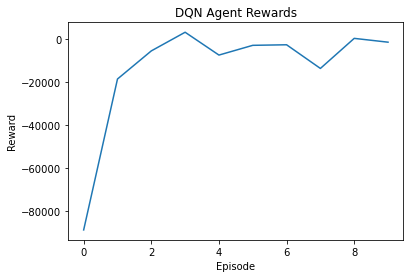

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['episode_reward'])
plt.title('DQN Agent Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [13]:
scores = dqn.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps = 1000)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
observation 
[[ 2. -1.]
 [ 2. -1.]
 [ 1. -1.]]
observation 
[[ 2. -2.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 3. -2.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 3. -3.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 4. -3.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 5.  -3.2]
 [ 2.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5.         -4.2       ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.   -5.25]
 [ 4.   -4.25]
 [ 0.    0.  ]]
observation 
[[ 4.         -6.25      ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.25]
 [ 2.   -4.5 ]
 [ 0.    0.  ]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -5.5       ]
 [ 0.          0.        ]]
observation 
[[ 4. -7.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.25]
 [ 0.    0.  ]


 [  3.          -3.        ]]
observation 
[[  6.         -12.33333333]
 [  4.         -10.        ]
 [  3.          -2.66666667]]
observation 
[[  5.         -12.4       ]
 [  4.         -11.        ]
 [  3.          -3.66666667]]
observation 
[[  5.  -10.2]
 [  4.  -12. ]
 [  4.   -3.5]]
observation 
[[  5.   -11.2 ]
 [  4.   -13.  ]
 [  4.    -3.75]]
observation 
[[  5.         -12.2       ]
 [  4.         -14.        ]
 [  3.          -4.66666667]]
observation 
[[  5.         -13.2       ]
 [  3.         -14.66666667]
 [  3.          -5.66666667]]
observation 
[[  5.  -14.2]
 [  3.  -10. ]
 [  4.   -5. ]]
observation 
[[  6.         -12.66666667]
 [  3.         -11.        ]
 [  3.          -5.66666667]]
observation 
[[  5.         -12.8       ]
 [  3.         -12.        ]
 [  3.          -6.66666667]]
observation 
[[  5.         -13.8       ]
 [  3.          -7.33333333]
 [  3.          -7.66666667]]
observation 
[[  4.         -13.25      ]
 [  3.          -8.33333333]
 [  3.   

 [ 0.  0.]]
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -11.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  1. -12.]
 [  1.   0.]
 [  1.  -1.]]
observation 
[[ 1. -1.]
 [ 1. -1.]
 [ 1. -2.]]
observation 
[[ 1. -2.]
 [ 2. -1.]
 [ 1. -1.]]
observation 
[[ 2.  -1.5]
 [ 2.  -2. ]
 [ 1.  -1. ]]
observation 
[[ 3.         -1.66666667]
 [ 3.         -2.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -2.66666667]
 [ 3.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -2.75]
 [ 2.   -4.  ]
 [ 1.    0.  ]]
observation 
[[ 5. -3.]
 [ 2. -5.]
 [ 1. -1.]]
observation 
[[ 6.         -3.33333333]
 [ 2.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -4.33333333]
 [ 2.         -7.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -5.33333333]
 [ 2.         -

 [  0.           0.        ]]
observation 
[[ 6.         -8.16666667]
 [ 2.         -3.5       ]
 [ 1.          0.        ]]
observation 
[[ 6.         -9.16666667]
 [ 2.         -4.5       ]
 [ 1.         -1.        ]]
observation 
[[ 6.  -7.5]
 [ 2.  -5.5]
 [ 1.  -2. ]]
observation 
[[ 6.         -8.5       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.66666667]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.33333333]
 [ 3.         -6.33333333]
 [ 1.          0.        ]]
observation 
[[ 6.         -8.33333333]
 [ 4.         -5.5       ]
 [ 1.         -1.        ]]
observation 
[[ 5.  -9.2]
 [ 4.  -6.5]
 [ 2.  -1. ]]
observation 
[[ 5.         -8.        ]
 [ 5.         -6.        ]
 [ 3.         -1.33333333]]
observation 
[[ 6.  -7.5]
 [ 5.  -7. ]
 [ 3.  -2. ]]
observation 
[[ 6.         -8.5       ]
 [ 6.         -6.66666667]
 [ 2.         -3.5       ]]
observation 
[[ 6.  -9.5]
 [ 5.  -6.6]
 [ 2.  -4.5]

 [ 0.          0.        ]]
observation 
[[ 7.         -7.57142857]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.57142857]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 8.    -8.375]
 [ 1.     0.   ]
 [ 0.     0.   ]]
observation 
[[ 9.         -8.33333333]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[10.  -8.4]
 [ 1.  -2. ]
 [ 0.   0. ]]
observation 
[[10.  -9.4]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 10.  -10.4]
 [  1.   -4. ]
 [  0.    0. ]]
observation 
[[ 11.         -10.36363636]
 [  1.          -5.        ]
 [  0.           0.        ]]
observation 
[[ 11.         -11.36363636]
 [  1.          -6.        ]
 [  0.           0.        ]]
observation 
[[ 10.  -12.2]
 [  1.   -7. ]
 [  1.    0. ]]
observation 
[[ 10.  -13.2]
 [  1.   -8. ]
 [  0.    0. ]]
observation 
[[  9.         -14.11111111]
 [  1.          -9.        ]
 [  0.           0.        ]]
observation 
[[  8.    -14.875]
 [  

 [  5.   -7. ]]
observation 
[[ 12.         -14.66666667]
 [  5.         -18.8       ]
 [  5.          -6.        ]]
observation 
[[ 12.         -15.66666667]
 [  5.         -19.8       ]
 [  4.          -6.5       ]]
observation 
[[ 12.         -16.66666667]
 [  5.         -20.8       ]
 [  3.          -7.33333333]]
observation 
[[ 11.         -16.81818182]
 [  5.         -21.8       ]
 [  3.          -8.33333333]]
observation 
[[ 12.         -16.33333333]
 [  4.         -21.        ]
 [  3.          -9.33333333]]
observation 
[[ 12.         -17.33333333]
 [  4.         -16.        ]
 [  4.          -7.75      ]]
observation 
[[ 12.         -18.33333333]
 [  4.         -17.        ]
 [  4.          -6.        ]]
observation 
[[ 12.   -17.25]
 [  4.   -18.  ]
 [  5.    -5.6 ]]
observation 
[[ 12.   -18.25]
 [  4.   -19.  ]
 [  4.    -6.  ]]
observation 
[[ 11.         -18.81818182]
 [  5.         -16.        ]
 [  4.          -7.        ]]
observation 
[[ 10.  -19.3]
 [  5.  -17. ]
 [ 

observation 
[[  7.         -15.85714286]
 [  4.          -5.25      ]
 [  1.           0.        ]]
observation 
[[  6.   -17.  ]
 [  4.    -6.25]
 [  1.    -1.  ]]
observation 
[[  6.         -15.16666667]
 [  5.          -5.8       ]
 [  1.          -2.        ]]
observation 
[[  5.  -15.6]
 [  5.   -6.8]
 [  2.   -1.5]]
observation 
[[  5.         -13.        ]
 [  5.          -7.8       ]
 [  3.          -1.66666667]]
observation 
[[  4.         -12.5       ]
 [  5.          -8.8       ]
 [  3.          -2.66666667]]
observation 
[[ 4.         -8.5       ]
 [ 5.         -9.8       ]
 [ 3.         -3.66666667]]
observation 
[[ 4.  -9.5]
 [ 4.  -9. ]
 [ 4.  -3.5]]
observation 
[[  4.         -10.5       ]
 [  4.         -10.        ]
 [  3.          -4.33333333]]
observation 
[[  5.   -9.2]
 [  4.  -11. ]
 [  2.   -5.5]]
observation 
[[  6.   -8.5]
 [  3.  -12. ]
 [  2.   -6.5]]
observation 
[[  6.   -9.5]
 [  2.  -13. ]
 [  2.   -7.5]]
observation 
[[ 7.  -9. ]
 [ 2.  -7.5]
 [ 2.  

 [ 0.   0. ]]
observation 
[[ 3.         -8.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 2. -8.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 1. -9.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 3.         -4.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -0.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.33333333]
 [ 2.         -1.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.   -3.25]
 [ 2.   -2.5 ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.25]
 [ 2.   -3.5 ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.25]
 [ 2.   -4.5 ]
 [ 1.    0.  ]]
observation 
[[ 5.         -4.2       ]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.  -5. ]
 [ 4.  -3.5]


observation 
[[  1. -10.]
 [  1.  -5.]
 [  2.  -2.]]
observation 
[[ 2.  -5.5]
 [ 1.  -6. ]
 [ 2.  -2. ]]
observation 
[[ 2.  -6.5]
 [ 1.  -7. ]
 [ 1.  -3. ]]
observation 
[[ 3. -5.]
 [ 0.  0.]
 [ 1. -4.]]
observation 
[[ 4.  -4.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.2]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.2]
 [ 2.  -0.5]
 [ 0.   0. ]]
observation 
[[ 4.  -6.5]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -1.66666667]
 [ 1.          0.        ]]
observation 
[[ 2.         -9.        ]
 [ 3.         -2.66666667]
 [ 2.         -0.5       ]]
observation 
[[  2.         -10.        ]
 [  3.          -3.66666667]
 [  2.          -1.5       ]]
observation 
[[  2.  -11. ]
 [  4.   -3.5]
 [  1.   -3. ]]
observation 
[[  2.         -12.        ]
 [  3.          -4.66666667]
 [  1.          -4.        ]]
observation 
[[ 3.       

 [ 0.          0.        ]]
observation 
[[ 6.         -7.66666667]
 [ 2.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 5.  -8.2]
 [ 2.  -7. ]
 [ 1.   0. ]]
observation 
[[ 5.  -9.2]
 [ 2.  -8. ]
 [ 1.  -1. ]]
observation 
[[ 4.   -9.75]
 [ 2.   -9.  ]
 [ 1.   -2.  ]]
observation 
[[  4.   -10.75]
 [  2.    -5.5 ]
 [  1.    -3.  ]]
observation 
[[  3.         -11.66666667]
 [  2.          -6.5       ]
 [  1.          -4.        ]]
observation 
[[  3.         -12.66666667]
 [  1.          -4.        ]
 [  2.          -2.5       ]]
observation 
[[  3.         -13.66666667]
 [  1.          -5.        ]
 [  1.          -2.        ]]
observation 
[[  2. -14.]
 [  1.  -6.]
 [  1.  -3.]]
observation 
[[  2. -15.]
 [  0.   0.]
 [  1.  -4.]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 1. -5.]]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4.   -5.25]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.25]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -7.25

 [  3.          -3.66666667]]
observation 
[[  6.  -16. ]
 [  4.  -11.5]
 [  4.   -3.5]]
observation 
[[  5.  -16.6]
 [  4.  -12.5]
 [  4.   -4.5]]
observation 
[[  5.  -13.6]
 [  4.  -13.5]
 [  4.   -5.5]]
observation 
[[  5.  -14.6]
 [  3.  -11. ]
 [  5.   -5.2]]
observation 
[[  5.   -15.6 ]
 [  3.   -12.  ]
 [  4.    -6.25]]
observation 
[[  4.   -14.75]
 [  3.   -13.  ]
 [  4.    -7.25]]
observation 
[[  5.   -12.6 ]
 [  3.   -14.  ]
 [  4.    -6.25]]
observation 
[[  6.         -11.33333333]
 [  3.         -15.        ]
 [  4.          -5.25      ]]
observation 
[[  7.         -10.57142857]
 [  3.         -16.        ]
 [  3.          -5.66666667]]
observation 
[[  8.         -10.125     ]
 [  4.         -12.75      ]
 [  3.          -4.33333333]]
observation 
[[  8.    -11.125]
 [  4.    -13.75 ]
 [  2.     -5.   ]]
observation 
[[  9.         -10.77777778]
 [  3.         -13.33333333]
 [  2.          -6.        ]]
observation 
[[  8.         -10.625     ]
 [  4.         -10.75 

 [  2.  -4.]]
observation 
[[ 0.  0.]
 [ 2. -2.]
 [ 2. -5.]]
observation 
[[ 0.  0.]
 [ 2. -3.]
 [ 1. -5.]]
observation 
[[ 1.  0.]
 [ 2. -4.]
 [ 1. -1.]]
observation 
[[ 2.  -0.5]
 [ 2.  -5. ]
 [ 0.   0. ]]
observation 
[[ 3. -1.]
 [ 2. -6.]
 [ 0.  0.]]
observation 
[[ 3. -2.]
 [ 2. -7.]
 [ 0.  0.]]
observation 
[[ 3.         -3.        ]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
observation 
[[ 3.  -4. ]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 4.   -3.75]
 [ 1.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.75]
 [ 1.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -5.75]
 [ 1.   -6.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -7.]
 [ 1. -7.]
 [ 0.  0.]]
observation 
[[ 4. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 5.  -5.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.33333333]
 [ 0.          0.        ]
 [ 0.      

 [  4.    -8.75]]
observation 
[[  2.  -15.5]
 [  5.   -6.6]
 [  5.   -7.8]]
observation 
[[  2.   -16.5 ]
 [  5.    -7.6 ]
 [  4.    -8.75]]
observation 
[[  3.         -11.66666667]
 [  4.          -8.        ]
 [  4.          -9.75      ]]
observation 
[[  3.         -12.66666667]
 [  4.          -6.75      ]
 [  5.          -8.6       ]]
observation 
[[  4.   -10.25]
 [  5.    -6.2 ]
 [  4.    -9.  ]]
observation 
[[  4.   -11.25]
 [  4.    -6.25]
 [  5.    -8.  ]]
observation 
[[ 5.   -9.8 ]
 [ 4.   -7.25]
 [ 4.   -8.  ]]
observation 
[[  5.   -10.8 ]
 [  4.    -8.25]
 [  4.    -5.75]]
observation 
[[  5.  -11.8]
 [  5.   -7.4]
 [  3.   -6. ]]
observation 
[[ 5.  -8.4]
 [ 5.  -8.4]
 [ 3.  -7. ]]
observation 
[[ 6.         -7.83333333]
 [ 4.         -9.        ]
 [ 4.         -6.        ]]
observation 
[[  6.          -8.83333333]
 [  4.         -10.        ]
 [  4.          -5.        ]]
observation 
[[  6.          -9.83333333]
 [  4.         -11.        ]
 [  4.          -4.25  

 [ 0.  0.]]
observation 
[[ 1. -4.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 1. -5.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -8.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -5.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 3. -6.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 2.  -5.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 2.  -6.5]
 [ 1.  -4. ]
 [ 0.   0. ]]
observation 
[[ 3. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 5.  -5.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.         -6.33333333]
 [ 0.          0.        ]
 [ 0

observation 
[[ 10.         -13.        ]
 [  3.          -3.66666667]
 [  2.          -0.5       ]]
observation 
[[ 11.         -12.72727273]
 [  3.          -4.66666667]
 [  1.          -2.        ]]
observation 
[[ 11.         -12.72727273]
 [  4.          -4.25      ]
 [  2.          -1.5       ]]
observation 
[[ 11.         -13.72727273]
 [  4.          -5.25      ]
 [  1.          -2.        ]]
observation 
[[ 11.         -13.54545455]
 [  4.          -6.25      ]
 [  2.          -1.5       ]]
observation 
[[ 11.         -14.54545455]
 [  4.          -7.25      ]
 [  2.          -1.5       ]]
observation 
[[ 10.   -15.5 ]
 [  4.    -8.25]
 [  2.    -2.5 ]]
observation 
[[  9.         -16.33333333]
 [  4.          -9.25      ]
 [  3.          -2.33333333]]
observation 
[[  8.         -17.        ]
 [  4.         -10.25      ]
 [  3.          -3.33333333]]
observation 
[[  7.         -17.85714286]
 [  4.         -11.25      ]
 [  4.          -3.25      ]]
observation 
[[  6.  -18.5

 [  9.         -15.22222222]]
observation 
[[ 11.         -25.09090909]
 [  5.         -16.4       ]
 [  8.         -15.125     ]]
observation 
[[ 11.         -26.09090909]
 [  5.         -17.4       ]
 [  7.         -15.42857143]]
observation 
[[ 10.    -26.   ]
 [  5.    -18.4  ]
 [  8.    -14.375]]
observation 
[[ 10.         -27.        ]
 [  5.         -19.4       ]
 [  7.         -14.85714286]]
observation 
[[  9.         -26.66666667]
 [  6.         -17.        ]
 [  7.         -15.85714286]]
observation 
[[  8.         -26.375     ]
 [  6.         -18.        ]
 [  7.         -16.85714286]]
observation 
[[  9.         -24.33333333]
 [  5.         -17.6       ]
 [  7.         -17.85714286]]
observation 
[[  9.         -21.22222222]
 [  5.         -18.6       ]
 [  8.         -16.5       ]]
observation 
[[  9.         -22.22222222]
 [  4.         -18.        ]
 [  8.         -17.5       ]]
observation 
[[  9.         -23.22222222]
 [  4.         -19.        ]
 [  7.         -17.5

observation 
[[ 12.         -25.33333333]
 [  6.         -13.66666667]
 [  6.         -19.33333333]]
observation 
[[ 11.         -25.45454545]
 [  6.         -14.66666667]
 [  7.         -17.42857143]]
observation 
[[ 10.         -25.3       ]
 [  6.         -15.66666667]
 [  7.         -18.42857143]]
observation 
[[  9.         -25.11111111]
 [  6.         -16.66666667]
 [  7.         -19.42857143]]
observation 
[[  9.         -26.11111111]
 [  5.         -17.4       ]
 [  7.         -20.42857143]]
observation 
[[  9.         -27.11111111]
 [  4.         -18.25      ]
 [  8.         -18.75      ]]
observation 
[[  8.   -26.5 ]
 [  5.   -15.4 ]
 [  8.   -19.75]]
observation 
[[  8.         -23.        ]
 [  6.         -13.66666667]
 [  8.         -20.75      ]]
observation 
[[  7.         -22.42857143]
 [  6.         -14.66666667]
 [  8.         -21.75      ]]
observation 
[[  8.   -20.5 ]
 [  5.   -14.8 ]
 [  8.   -22.75]]
observation 
[[  7.         -20.28571429]
 [  5.         -15.8

observation 
[[  5.  -20.2]
 [  7.  -17. ]
 [ 10.  -12. ]]
observation 
[[  6.         -17.66666667]
 [  6.         -17.16666667]
 [ 11.         -11.81818182]]
observation 
[[  7.   -16.  ]
 [  5.   -17.  ]
 [ 12.   -11.75]]
observation 
[[  7.   -17.  ]
 [  4.   -16.  ]
 [ 12.   -12.75]]
observation 
[[  7.         -18.        ]
 [  5.         -13.6       ]
 [ 11.         -13.27272727]]
observation 
[[  7.         -19.        ]
 [  4.         -14.25      ]
 [ 11.         -14.27272727]]
observation 
[[  7.   -20.  ]
 [  4.   -15.25]
 [ 10.   -14.9 ]]
observation 
[[  7.         -21.        ]
 [  5.         -13.        ]
 [  9.         -15.55555556]]
observation 
[[  6.         -18.66666667]
 [  6.         -11.66666667]
 [ 10.         -14.9       ]]
observation 
[[  7.         -16.85714286]
 [  5.         -11.4       ]
 [ 10.         -15.9       ]]
observation 
[[  7.         -17.85714286]
 [  4.         -10.25      ]
 [ 10.         -16.9       ]]
observation 
[[  7.         -13.7142857

 [  6.          -9.16666667]]
observation 
[[  6.         -14.        ]
 [  6.         -11.5       ]
 [  6.         -10.16666667]]
observation 
[[  7.         -12.85714286]
 [  5.         -11.6       ]
 [  7.          -9.57142857]]
observation 
[[  8.         -12.125     ]
 [  4.         -11.5       ]
 [  7.         -10.57142857]]
observation 
[[  8.         -13.125     ]
 [  4.         -12.5       ]
 [  6.         -11.16666667]]
observation 
[[  9.         -12.55555556]
 [  4.         -13.5       ]
 [  6.          -9.66666667]]
observation 
[[  9.         -13.55555556]
 [  4.         -14.5       ]
 [  5.         -10.        ]]
observation 
[[  9.         -14.55555556]
 [  4.         -15.5       ]
 [  4.         -10.5       ]]
observation 
[[ 10.  -14. ]
 [  3.  -15. ]
 [  4.  -11.5]]
observation 
[[  9. -14.]
 [  3. -16.]
 [  5. -10.]]
observation 
[[  9.  -15. ]
 [  3.  -17. ]
 [  5.   -8.4]]
observation 
[[  9.  -16. ]
 [  4.  -13.5]
 [  5.   -6.8]]
observation 
[[  9.   -17.  ]
 [ 

 [  8.   -15.75]]
observation 
[[ 11.         -22.90909091]
 [  3.         -25.        ]
 [  8.         -16.75      ]]
observation 
[[ 11.         -23.90909091]
 [  3.         -26.        ]
 [  7.         -17.57142857]]
observation 
[[ 11.         -24.90909091]
 [  2.         -24.        ]
 [  8.         -16.25      ]]
observation 
[[ 11.         -25.90909091]
 [  3.         -16.66666667]
 [  8.         -14.75      ]]
observation 
[[ 11.         -22.90909091]
 [  3.         -17.66666667]
 [  9.         -14.        ]]
observation 
[[ 12.         -21.91666667]
 [  3.         -18.66666667]
 [  9.         -12.66666667]]
observation 
[[ 13.         -21.15384615]
 [  3.         -19.66666667]
 [  8.         -12.625     ]]
observation 
[[ 14.         -20.57142857]
 [  3.         -20.66666667]
 [  7.         -12.57142857]]
observation 
[[ 14.         -21.57142857]
 [  4.         -16.25      ]
 [  6.         -13.        ]]
observation 
[[ 15.         -21.06666667]
 [  4.         -17.25      ]
 [

observation 
[[  7.         -13.85714286]
 [  4.         -12.25      ]
 [  5.          -8.        ]]
observation 
[[  7.         -14.85714286]
 [  4.         -13.25      ]
 [  5.          -7.4       ]]
observation 
[[  8.    -13.875]
 [  5.    -11.4  ]
 [  5.     -6.6  ]]
observation 
[[  9.         -13.22222222]
 [  5.         -12.4       ]
 [  4.          -7.        ]]
observation 
[[ 10.         -12.8       ]
 [  6.         -11.16666667]
 [  3.          -6.66666667]]
observation 
[[  9.         -12.55555556]
 [  6.         -12.16666667]
 [  3.          -7.66666667]]
observation 
[[  9.         -13.55555556]
 [  6.          -9.5       ]
 [  3.          -8.66666667]]
observation 
[[  9.         -14.55555556]
 [  6.          -8.        ]
 [  4.          -7.25      ]]
observation 
[[  8.    -14.375]
 [  6.     -9.   ]
 [  5.     -6.6  ]]
observation 
[[  9.         -13.66666667]
 [  6.         -10.        ]
 [  4.          -7.25      ]]
observation 
[[  8.         -13.25      ]
 [  7.  

 [  6.          -8.16666667]]
observation 
[[  6.         -15.66666667]
 [  5.         -13.2       ]
 [  7.          -7.85714286]]
observation 
[[  7.         -14.28571429]
 [  5.         -14.2       ]
 [  7.          -7.57142857]]
observation 
[[  8.         -13.375     ]
 [  5.         -15.2       ]
 [  6.          -8.16666667]]
observation 
[[  9.         -12.77777778]
 [  5.         -16.2       ]
 [  5.          -9.2       ]]
observation 
[[  9.         -13.77777778]
 [  5.         -17.2       ]
 [  5.          -8.2       ]]
observation 
[[  9.         -14.77777778]
 [  5.         -18.2       ]
 [  4.          -8.5       ]]
observation 
[[ 10.  -14.2]
 [  5.  -11.8]
 [  4.   -9.5]]
observation 
[[  9.         -14.22222222]
 [  5.         -12.8       ]
 [  4.         -10.5       ]]
observation 
[[  9.         -15.22222222]
 [  5.         -10.4       ]
 [  4.         -11.5       ]]
observation 
[[  8.    -15.125]
 [  5.    -11.4  ]
 [  4.    -12.5  ]]
observation 
[[  8.    -16.125]


 [  3.         -14.        ]]
observation 
[[  3. -13.]
 [  3.  -2.]
 [  3. -15.]]
observation 
[[  3.  -14. ]
 [  2.   -3.5]
 [  3.  -16. ]]
observation 
[[  4.   -11.25]
 [  1.    -5.  ]
 [  3.   -17.  ]]
observation 
[[  5.   -9.8]
 [  0.    0. ]
 [  3.  -18. ]]
observation 
[[  5.  -10.8]
 [  0.    0. ]
 [  3.  -13. ]]
observation 
[[  5.         -11.8       ]
 [  0.           0.        ]
 [  3.          -7.66666667]]
observation 
[[  6.         -10.66666667]
 [  0.           0.        ]
 [  2.          -4.        ]]
observation 
[[  7. -10.]
 [  0.   0.]
 [  1.  -5.]]
observation 
[[  7. -11.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  6.         -10.66666667]
 [  1.           0.        ]
 [  0.           0.        ]]
observation 
[[  5.  -10.2]
 [  1.   -1. ]
 [  0.    0. ]]
observation 
[[ 5.  -7.8]
 [ 1.  -2. ]
 [ 1.   0. ]]
observation 
[[ 5.  -8.8]
 [ 2.  -1.5]
 [ 1.  -1. ]]
observation 
[[ 4.   -9.75]
 [ 2.   -2.5 ]
 [ 1.   -2.  ]]
observation 
[[  3.         -10.33333333]


 [  4.    -3.75]]
observation 
[[  8.   -12.75]
 [  1.   -17.  ]
 [  3.    -5.  ]]
observation 
[[  8.   -13.75]
 [  1.   -18.  ]
 [  2.    -6.  ]]
observation 
[[  8.    -11.375]
 [  1.    -19.   ]
 [  2.     -7.   ]]
observation 
[[  8.    -12.375]
 [  1.     -1.   ]
 [  2.     -8.   ]]
observation 
[[  9.         -11.88888889]
 [  1.          -2.        ]
 [  2.          -5.        ]]
observation 
[[ 10.  -11.6]
 [  1.   -3. ]
 [  2.   -2. ]]
observation 
[[ 10.  -12.6]
 [  2.   -2. ]
 [  2.   -2. ]]
observation 
[[ 11.         -12.36363636]
 [  2.          -3.        ]
 [  2.          -2.        ]]
observation 
[[ 11.         -13.36363636]
 [  3.          -2.66666667]
 [  1.          -3.        ]]
observation 
[[ 10.   -14.  ]
 [  4.    -2.75]
 [  2.    -2.  ]]
observation 
[[  9.         -14.55555556]
 [  5.          -3.        ]
 [  3.          -2.        ]]
observation 
[[  9.         -15.55555556]
 [  6.          -3.33333333]
 [  2.          -2.5       ]]
observation 
[[  9.   

 [ 1.  0.]]
observation 
[[ 1. -1.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 2. -1.]
 [ 2. -6.]
 [ 0.  0.]]
observation 
[[ 3.         -1.33333333]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -2.33333333]
 [ 3.         -3.33333333]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.33333333]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.33333333]
 [ 2.         -4.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 1.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -7.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -1.5       ]
 [ 1.          0.        ]]
observation 
[[ 4.   -5.75]
 [ 2.   -2.

observation 
[[ 2.         -8.        ]
 [ 3.         -2.33333333]
 [ 3.         -2.33333333]]
observation 
[[ 2.         -9.        ]
 [ 3.         -3.33333333]
 [ 3.         -2.66666667]]
observation 
[[  2.         -10.        ]
 [  3.          -4.33333333]
 [  3.          -2.66666667]]
observation 
[[  2.         -11.        ]
 [  3.          -5.33333333]
 [  2.          -4.        ]]
observation 
[[  2.         -12.        ]
 [  3.          -4.66666667]
 [  2.          -5.        ]]
observation 
[[  2. -13.]
 [  2.  -5.]
 [  3.  -4.]]
observation 
[[  2.         -14.        ]
 [  3.          -4.        ]
 [  3.          -3.33333333]]
observation 
[[  2.         -15.        ]
 [  3.          -5.        ]
 [  3.          -2.66666667]]
observation 
[[  2. -16.]
 [  3.  -6.]
 [  2.  -4.]]
observation 
[[  2. -17.]
 [  2.  -6.]
 [  2.  -5.]]
observation 
[[  2. -18.]
 [  1.  -6.]
 [  2.  -6.]]
observation 
[[  2. -19.]
 [  1.  -1.]
 [  2.  -7.]]
observation 
[[  1.         -14.        

observation 
[[ 3.         -7.        ]
 [ 4.         -5.75      ]
 [ 3.         -2.66666667]]
observation 
[[ 3.         -8.        ]
 [ 4.         -6.75      ]
 [ 3.         -2.66666667]]
observation 
[[ 3.  -9. ]
 [ 5.  -6.2]
 [ 2.  -4. ]]
observation 
[[  3.   -10.  ]
 [  4.    -5.75]
 [  2.    -5.  ]]
observation 
[[  3. -11.]
 [  3.  -7.]
 [  2.  -6.]]
observation 
[[  3.         -12.        ]
 [  2.          -8.        ]
 [  3.          -4.66666667]]
observation 
[[  3. -13.]
 [  2.  -9.]
 [  2.  -5.]]
observation 
[[  3. -14.]
 [  1.  -9.]
 [  2.  -6.]]
observation 
[[  3. -15.]
 [  0.   0.]
 [  2.  -7.]]
observation 
[[  2.  -16.5]
 [  0.    0. ]
 [  2.   -8. ]]
observation 
[[  1. -18.]
 [  1.   0.]
 [  2.  -9.]]
observation 
[[  0.    0. ]
 [  2.   -0.5]
 [  2.  -10. ]]
observation 
[[ 0.   0. ]
 [ 2.  -1.5]
 [ 1.  -9. ]]
observation 
[[  0.   0.]
 [  1.  -3.]
 [  1. -10.]]
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 2.  -5.5]]
observation 
[[ 1. -1.]
 [ 0.  0.]
 [ 1. -2.]]
ob

 [  4.          -4.        ]]
observation 
[[  6.         -15.66666667]
 [  1.          -2.        ]
 [  3.          -5.        ]]
observation 
[[  7.         -14.28571429]
 [  1.          -3.        ]
 [  2.          -6.        ]]
observation 
[[  6.         -14.16666667]
 [  2.          -2.        ]
 [  2.          -7.        ]]
observation 
[[  5.         -13.4       ]
 [  3.          -2.        ]
 [  3.          -5.33333333]]
observation 
[[  5.  -14.4]
 [  3.   -3. ]
 [  3.   -4. ]]
observation 
[[  5.  -15.4]
 [  3.   -4. ]
 [  2.   -3.5]]
observation 
[[  5. -11.]
 [  3.  -5.]
 [  3.  -3.]]
observation 
[[  5. -12.]
 [  3.  -6.]
 [  2.  -4.]]
observation 
[[  4.         -11.5       ]
 [  4.          -5.25      ]
 [  3.          -3.33333333]]
observation 
[[  5.   -10.  ]
 [  4.    -6.25]
 [  2.    -3.5 ]]
observation 
[[ 5.  -8.2]
 [ 5.  -5.8]
 [ 2.  -4.5]]
observation 
[[ 5.   -9.2 ]
 [ 4.   -6.25]
 [ 2.   -5.5 ]]
observation 
[[ 6.  -8.5]
 [ 3.  -7. ]
 [ 2.  -6.5]]
observation

observation 
[[ 5.         -6.8       ]
 [ 2.         -9.        ]
 [ 3.         -3.33333333]]
observation 
[[  5.   -7.8]
 [  2.  -10. ]
 [  2.   -3.5]]
observation 
[[  5.   -8.8]
 [  2.  -11. ]
 [  1.   -4. ]]
observation 
[[ 5.  -9.8]
 [ 2.  -5.5]
 [ 2.  -2.5]]
observation 
[[  5.  -10.8]
 [  2.   -6.5]
 [  2.   -1.5]]
observation 
[[  5.  -11.8]
 [  3.   -5. ]
 [  2.   -2. ]]
observation 
[[  5.  -10. ]
 [  4.   -4.5]
 [  3.   -2. ]]
observation 
[[  5.  -11. ]
 [  4.   -5.5]
 [  2.   -3. ]]
observation 
[[ 5.         -9.4       ]
 [ 4.         -6.5       ]
 [ 3.         -2.66666667]]
observation 
[[ 6.         -8.66666667]
 [ 5.         -6.        ]
 [ 2.         -3.5       ]]
observation 
[[ 5.  -8.8]
 [ 5.  -7. ]
 [ 2.  -4.5]]
observation 
[[ 5.  -9.8]
 [ 4.  -6.5]
 [ 2.  -5.5]]
observation 
[[  5.         -10.8       ]
 [  3.          -7.33333333]
 [  3.          -4.33333333]]
observation 
[[ 6.         -9.83333333]
 [ 3.         -8.33333333]
 [ 3.         -3.33333333]]
observ

 [  3.          -8.33333333]]
observation 
[[ 10.         -14.1       ]
 [  5.         -15.8       ]
 [  3.          -9.33333333]]
observation 
[[ 10.   -15.1 ]
 [  4.   -15.25]
 [  4.    -7.75]]
observation 
[[ 10.   -16.1 ]
 [  4.   -16.25]
 [  3.    -8.  ]]
observation 
[[ 10.   -14.8 ]
 [  4.   -17.25]
 [  3.    -9.  ]]
observation 
[[ 11.         -14.36363636]
 [  3.         -16.        ]
 [  3.         -10.        ]]
observation 
[[ 10.  -14.7]
 [  3.  -17. ]
 [  3.  -11. ]]
observation 
[[ 10.  -15.7]
 [  2.  -15.5]
 [  3.  -12. ]]
observation 
[[  9.         -16.11111111]
 [  3.         -11.        ]
 [  3.         -13.        ]]
observation 
[[  8.   -16.75]
 [  3.   -12.  ]
 [  4.   -10.5 ]]
observation 
[[  7.         -17.42857143]
 [  4.          -9.75      ]
 [  5.          -9.2       ]]
observation 
[[  6.         -18.33333333]
 [  5.          -8.6       ]
 [  5.         -10.2       ]]
observation 
[[  5.         -19.        ]
 [  5.          -9.6       ]
 [  6.          

observation 
[[  7.         -12.57142857]
 [  3.         -15.33333333]
 [  3.          -5.33333333]]
observation 
[[  7.         -13.57142857]
 [  3.         -16.33333333]
 [  2.          -5.5       ]]
observation 
[[  7.         -14.57142857]
 [  2.         -14.5       ]
 [  3.          -4.33333333]]
observation 
[[  8.         -13.625     ]
 [  3.         -10.33333333]
 [  3.          -3.66666667]]
observation 
[[  8.         -14.625     ]
 [  4.          -8.5       ]
 [  3.          -2.66666667]]
observation 
[[  7.         -14.28571429]
 [  4.          -9.5       ]
 [  4.          -2.75      ]]
observation 
[[  6.         -14.33333333]
 [  4.         -10.5       ]
 [  4.          -3.75      ]]
observation 
[[  5.   -14.  ]
 [  5.    -9.2 ]
 [  4.    -4.75]]
observation 
[[  4.   -13.75]
 [  5.   -10.2 ]
 [  4.    -5.75]]
observation 
[[  4.   -14.75]
 [  4.    -9.25]
 [  4.    -6.75]]
observation 
[[  3.         -15.66666667]
 [  5.          -8.2       ]
 [  4.          -7.75      

 [ 0.   0. ]]
observation 
[[ 4. -7.]
 [ 2. -6.]
 [ 1.  0.]]
observation 
[[ 4. -8.]
 [ 2. -7.]
 [ 1. -1.]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -8.        ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -8.        ]
 [ 2.         -1.5       ]]
observation 
[[  3.         -10.33333333]
 [  2.          -4.5       ]
 [  1.          -2.        ]]
observation 
[[  3.         -11.33333333]
 [  1.          -2.        ]
 [  2.          -1.5       ]]
observation 
[[  3.         -12.33333333]
 [  1.          -3.        ]
 [  2.          -1.5       ]]
observation 
[[  3.         -13.33333333]
 [  1.          -4.        ]
 [  2.          -2.        ]]
observation 
[[  3.         -14.33333333]
 [  1.          -5.        ]
 [  1.          -3.        ]]
observation 
[[  3.         -10.66666667]
 [  1.          -6.        ]
 [  1.          -4.        ]]
observation 
[[  3.         -11.66666667]
 [  0.           0.        ]
 [  1.          -5.      

 [ 2.         -1.5       ]]
observation 
[[ 4.   -7.  ]
 [ 4.   -4.25]
 [ 1.   -3.  ]]
observation 
[[ 4.         -8.        ]
 [ 3.         -4.33333333]
 [ 2.         -2.        ]]
observation 
[[ 4.  -9. ]
 [ 4.  -4. ]
 [ 2.  -1.5]]
observation 
[[ 3.         -8.66666667]
 [ 5.         -4.        ]
 [ 2.         -2.5       ]]
observation 
[[ 4.   -7.25]
 [ 4.   -5.  ]
 [ 2.   -3.5 ]]
observation 
[[ 5.  -6.6]
 [ 3.  -6. ]
 [ 2.  -4.5]]
observation 
[[ 5.  -7.6]
 [ 3.  -7. ]
 [ 1.  -6. ]]
observation 
[[ 5.  -8.6]
 [ 2.  -7.5]
 [ 1.  -7. ]]
observation 
[[ 6. -8.]
 [ 1. -9.]
 [ 1. -8.]]
observation 
[[ 6. -9.]
 [ 0.  0.]
 [ 1. -9.]]
observation 
[[  6.          -7.66666667]
 [  1.           0.        ]
 [  1.         -10.        ]]
observation 
[[ 5.  -7.8]
 [ 1.  -1. ]
 [ 2.  -5.5]]
observation 
[[ 6.         -7.33333333]
 [ 1.         -2.        ]
 [ 2.         -1.5       ]]
observation 
[[ 7.         -7.14285714]
 [ 1.         -3.        ]
 [ 1.         -3.        ]]
observation 
[

 [ 2.         -4.5       ]]
observation 
[[ 5.  -7. ]
 [ 5.  -5.8]
 [ 2.  -5.5]]
observation 
[[ 6.         -6.66666667]
 [ 4.         -7.25      ]
 [ 3.         -4.33333333]]
observation 
[[ 7.         -6.57142857]
 [ 4.         -8.25      ]
 [ 2.         -5.        ]]
observation 
[[ 8.    -6.625]
 [ 4.    -9.25 ]
 [ 2.    -2.5  ]]
observation 
[[  8.     -7.625]
 [  4.    -10.25 ]
 [  2.     -2.   ]]
observation 
[[  8.     -8.625]
 [  4.    -11.25 ]
 [  2.     -2.   ]]
observation 
[[  9.          -8.55555556]
 [  4.         -12.25      ]
 [  1.          -3.        ]]
observation 
[[  9.          -8.11111111]
 [  4.         -13.25      ]
 [  2.          -2.        ]]
observation 
[[  9.          -9.11111111]
 [  4.         -14.25      ]
 [  1.          -2.        ]]
observation 
[[  8.    -9.5 ]
 [  4.   -15.25]
 [  2.    -1.5 ]]
observation 
[[  8.   -10.5 ]
 [  4.   -16.25]
 [  2.    -1.5 ]]
observation 
[[  9.         -10.22222222]
 [  4.         -17.25      ]
 [  2.          -2

 [  4.    -5.  ]]
observation 
[[  7.         -10.28571429]
 [  4.          -9.75      ]
 [  4.          -4.5       ]]
observation 
[[  7.         -11.28571429]
 [  5.          -8.6       ]
 [  3.          -4.66666667]]
observation 
[[  6.         -10.66666667]
 [  6.          -8.        ]
 [  4.          -4.25      ]]
observation 
[[  6.         -11.66666667]
 [  6.          -9.        ]
 [  4.          -4.25      ]]
observation 
[[  5.         -11.6       ]
 [  7.          -8.57142857]
 [  5.          -4.2       ]]
observation 
[[  5.         -12.6       ]
 [  7.          -7.71428571]
 [  5.          -5.2       ]]
observation 
[[  6.         -11.33333333]
 [  6.          -7.66666667]
 [  6.          -5.16666667]]
observation 
[[  7.         -10.57142857]
 [  5.          -7.8       ]
 [  7.          -5.28571429]]
observation 
[[  7.         -11.57142857]
 [  6.          -7.33333333]
 [  6.          -6.16666667]]
observation 
[[  7.         -12.57142857]
 [  5.          -8.4       ]
 [

 [ 2.         -1.        ]]
observation 
[[ 3.         -9.33333333]
 [ 2.         -7.5       ]
 [ 1.         -2.        ]]
observation 
[[  3.         -10.33333333]
 [  1.          -5.        ]
 [  1.          -3.        ]]
observation 
[[  3.         -11.33333333]
 [  0.           0.        ]
 [  2.          -2.        ]]
observation 
[[  3.         -12.33333333]
 [  1.           0.        ]
 [  1.          -2.        ]]
observation 
[[  2.  -13. ]
 [  1.   -1. ]
 [  2.   -1.5]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -2.        ]
 [ 1.         -2.        ]]
observation 
[[ 2.  -8.5]
 [ 1.  -3. ]
 [ 2.  -1.5]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -2.        ]
 [ 1.         -2.        ]]
observation 
[[ 4.  -5.5]
 [ 3.  -2. ]
 [ 0.   0. ]]
observation 
[[ 3.         -3.66666667]
 [ 3.         -3.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 3.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5

 [  1.          -2.        ]]
observation 
[[  6.         -11.16666667]
 [  2.          -6.5       ]
 [  2.          -1.5       ]]
observation 
[[  6.         -12.16666667]
 [  2.          -7.5       ]
 [  2.          -1.5       ]]
observation 
[[  6.         -13.16666667]
 [  3.          -5.66666667]
 [  2.          -2.        ]]
observation 
[[  5.  -14.2]
 [  4.   -5. ]
 [  2.   -3. ]]
observation 
[[  4. -15.]
 [  4.  -6.]
 [  2.  -4.]]
observation 
[[  4.   -11.75]
 [  4.    -7.  ]
 [  2.    -5.  ]]
observation 
[[  4.         -12.75      ]
 [  3.          -5.66666667]
 [  2.          -6.        ]]
observation 
[[  3.         -12.        ]
 [  3.          -6.66666667]
 [  3.          -4.66666667]]
observation 
[[  3.         -13.        ]
 [  3.          -7.66666667]
 [  2.          -5.        ]]
observation 
[[  3.  -14. ]
 [  2.   -8.5]
 [  3.   -4. ]]
observation 
[[  3.         -15.        ]
 [  3.          -6.33333333]
 [  3.          -2.66666667]]
observation 
[[  3.  -16. ]

 [ 0.   0. ]]
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 3. -3.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -0.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -1.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.66666667]
 [ 3.         -1.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -4.  

 [  6.  -12. ]]
observation 
[[  5.         -10.8       ]
 [  5.          -9.6       ]
 [  6.         -10.83333333]]
observation 
[[  5.  -11.8]
 [  5.  -10.6]
 [  6.  -10. ]]
observation 
[[  5.  -12.8]
 [  5.   -9.2]
 [  6.  -11. ]]
observation 
[[  4.  -12. ]
 [  5.  -10.2]
 [  6.  -12. ]]
observation 
[[  5.   -10.4 ]
 [  4.   -10.25]
 [  6.   -13.  ]]
observation 
[[  5.   -11.4 ]
 [  4.   -11.25]
 [  5.   -13.6 ]]
observation 
[[  6.         -10.33333333]
 [  3.         -11.        ]
 [  5.         -14.6       ]]
observation 
[[  6.         -11.33333333]
 [  3.         -12.        ]
 [  4.         -14.75      ]]
observation 
[[  6.         -12.33333333]
 [  2.         -12.5       ]
 [  4.         -15.75      ]]
observation 
[[  6.         -13.33333333]
 [  1.         -12.        ]
 [  4.         -16.75      ]]
observation 
[[  6.         -14.33333333]
 [  0.           0.        ]
 [  5.         -14.2       ]]
observation 
[[  6.         -15.33333333]
 [  1.           0.        ]


 [  1.          -4.        ]]
observation 
[[  5.  -15.4]
 [  4.   -4.5]
 [  2.   -2.5]]
observation 
[[  4.         -15.75      ]
 [  4.          -5.5       ]
 [  3.          -2.33333333]]
observation 
[[  3.         -17.        ]
 [  4.          -6.5       ]
 [  3.          -3.33333333]]
observation 
[[  2.   -18.  ]
 [  5.    -6.  ]
 [  4.    -3.25]]
observation 
[[  3.         -12.66666667]
 [  5.          -7.        ]
 [  3.          -3.66666667]]
observation 
[[  3.         -13.66666667]
 [  5.          -6.4       ]
 [  3.          -4.66666667]]
observation 
[[  4.   -11.  ]
 [  5.    -5.8 ]
 [  4.    -4.25]]
observation 
[[  4.         -12.        ]
 [  6.          -5.66666667]
 [  3.          -5.33333333]]
observation 
[[  5.         -10.4       ]
 [  5.          -6.4       ]
 [  3.          -6.33333333]]
observation 
[[  5.         -11.4       ]
 [  4.          -7.        ]
 [  3.          -7.33333333]]
observation 
[[ 5.         -8.        ]
 [ 4.         -8.        ]
 [ 3.  

 [ 1.  -2. ]]
observation 
[[  4.  -10.5]
 [  4.   -3. ]
 [  1.   -3. ]]
observation 
[[  4.  -11.5]
 [  3.   -4. ]
 [  1.   -4. ]]
observation 
[[  5.  -10. ]
 [  2.   -5.5]
 [  1.   -5. ]]
observation 
[[ 4.   -9.75]
 [ 2.   -6.5 ]
 [ 1.   -6.  ]]
observation 
[[  4.   -10.75]
 [  1.    -8.  ]
 [  1.    -7.  ]]
observation 
[[  4.   -11.75]
 [  0.     0.  ]
 [  2.    -4.  ]]
observation 
[[  4.   -12.75]
 [  0.     0.  ]
 [  2.    -1.5 ]]
observation 
[[  5. -11.]
 [  1.   0.]
 [  2.  -2.]]
observation 
[[  5. -12.]
 [  1.  -1.]
 [  1.  -3.]]
observation 
[[  4.   -11.75]
 [  1.    -2.  ]
 [  2.    -2.  ]]
observation 
[[  4.   -12.75]
 [  1.    -3.  ]
 [  1.    -2.  ]]
observation 
[[  3.         -11.66666667]
 [  1.          -4.        ]
 [  2.          -1.5       ]]
observation 
[[  3.         -12.66666667]
 [  2.          -2.5       ]
 [  2.          -1.5       ]]
observation 
[[ 3.         -8.33333333]
 [ 3.         -2.33333333]
 [ 3.         -1.66666667]]
observation 
[[ 3.    

observation 
[[ 3. -3.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 4. -3.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 5.  -3.2]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 6.  -3.5]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 6.  -4.5]
 [ 1.  -8. ]
 [ 0.   0. ]]
observation 
[[ 7.         -4.71428571]
 [ 1.         -9.        ]
 [ 0.          0.        ]]
observation 
[[  8.  -5.]
 [  1. -10.]
 [  0.   0.]]
observation 
[[ 8.  -6. ]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 9.         -6.22222222]
 [ 2.         -6.5       ]
 [ 0.          0.        ]]
observation 
[[ 9.         -7.22222222]
 [ 2.         -7.5       ]
 [ 0.          0.        ]]
observation 
[[ 9.         -8.22222222]
 [ 2.         -8.5       ]
 [ 0.          0.        ]]
observation 
[[ 8.    -9.375]
 [ 2.    -9.5  ]
 [ 0.     0.   ]]
observation 
[[  7.         -10.42857143]
 [  2.         -10.5       ]
 [  0.           0.        ]]
observation 
[[  6.         -11.83333333]
 [  2.         -11.5       ]
 [  0.           0.     

 [  5.         -12.        ]]
observation 
[[  4.   -13.25]
 [  4.   -10.5 ]
 [  5.   -13.  ]]
observation 
[[  4.   -14.25]
 [  3.   -11.  ]
 [  5.   -14.  ]]
observation 
[[  4.   -15.25]
 [  2.   -10.5 ]
 [  6.   -12.5 ]]
observation 
[[  4.   -16.25]
 [  2.   -11.5 ]
 [  5.   -13.2 ]]
observation 
[[  3.         -14.33333333]
 [  3.          -8.33333333]
 [  5.         -14.2       ]]
observation 
[[  3.         -15.33333333]
 [  2.          -8.        ]
 [  5.         -15.2       ]]
observation 
[[  3.   -9. ]
 [  2.   -9. ]
 [  5.  -16.2]]
observation 
[[  3.  -10. ]
 [  2.  -10. ]
 [  5.  -13.4]]
observation 
[[  4.    -8.25]
 [  2.   -11.  ]
 [  4.   -13.25]]
observation 
[[  5.    -7.4 ]
 [  2.   -12.  ]
 [  4.    -9.25]]
observation 
[[  5.          -8.4       ]
 [  2.         -13.        ]
 [  3.          -7.66666667]]
observation 
[[  5.   -9.4]
 [  2.  -14. ]
 [  3.   -5. ]]
observation 
[[  5.  -10.4]
 [  2.  -15. ]
 [  2.   -5. ]]
observation 
[[  5.  -11.4]
 [  1.  -11. 

observation 
[[ 6.         -9.33333333]
 [ 2.         -5.        ]
 [ 1.         -3.        ]]
observation 
[[ 5.  -9.2]
 [ 2.  -6. ]
 [ 1.  -4. ]]
observation 
[[ 4.  -8.5]
 [ 2.  -7. ]
 [ 1.  -5. ]]
observation 
[[ 4.  -9.5]
 [ 2.  -2.5]
 [ 2.  -3. ]]
observation 
[[ 5.         -8.4       ]
 [ 3.         -2.33333333]
 [ 1.         -2.        ]]
observation 
[[ 4.         -9.        ]
 [ 3.         -3.33333333]
 [ 1.         -3.        ]]
observation 
[[ 3.         -9.66666667]
 [ 3.         -4.33333333]
 [ 1.         -4.        ]]
observation 
[[  3.         -10.66666667]
 [  3.          -3.66666667]
 [  1.          -5.        ]]
observation 
[[ 4.   -8.75]
 [ 2.   -4.5 ]
 [ 2.   -3.  ]]
observation 
[[ 4.         -9.75      ]
 [ 3.         -3.66666667]
 [ 2.         -1.5       ]]
observation 
[[  4.         -10.75      ]
 [  3.          -4.66666667]
 [  1.          -3.        ]]
observation 
[[  4.   -11.75]
 [  2.    -5.  ]
 [  1.    -4.  ]]
observation 
[[  3.         -11.33333333

 [  6.  -10.5]]
observation 
[[  5.  -13.2]
 [  4.  -16. ]
 [  6.  -11.5]]
observation 
[[  5.  -14.2]
 [  4.  -12. ]
 [  6.  -12.5]]
observation 
[[  4.  -13. ]
 [  4.  -13. ]
 [  6.  -13.5]]
observation 
[[  4.         -14.        ]
 [  3.         -11.66666667]
 [  6.         -14.5       ]]
observation 
[[  4.         -15.        ]
 [  3.         -12.66666667]
 [  5.         -14.6       ]]
observation 
[[  4.  -16. ]
 [  2.   -9.5]
 [  6.  -13. ]]
observation 
[[  5.  -13.6]
 [  2.  -10.5]
 [  5.  -12.8]]
observation 
[[  5.         -14.6       ]
 [  3.          -7.66666667]
 [  4.         -12.25      ]]
observation 
[[  4.         -13.25      ]
 [  3.          -8.66666667]
 [  4.         -13.25      ]]
observation 
[[  4.   -14.25]
 [  2.    -7.5 ]
 [  5.   -11.4 ]]
observation 
[[  4.         -15.25      ]
 [  3.          -5.66666667]
 [  5.          -9.6       ]]
observation 
[[  4.         -16.25      ]
 [  3.          -6.66666667]
 [  5.          -7.6       ]]
observation 
[[  4

observation 
[[  7.          -8.71428571]
 [  2.         -10.5       ]
 [  0.           0.        ]]
observation 
[[ 7.         -8.14285714]
 [ 3.         -7.66666667]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.        ]
 [ 3.         -8.66666667]
 [ 0.          0.        ]]
observation 
[[ 6.         -9.        ]
 [ 3.         -9.66666667]
 [ 1.          0.        ]]
observation 
[[  5. -10.]
 [  4.  -8.]
 [  1.  -1.]]
observation 
[[  5. -11.]
 [  4.  -5.]
 [  2.  -1.]]
observation 
[[  4.         -12.        ]
 [  4.          -6.        ]
 [  3.          -1.33333333]]
observation 
[[  4.  -13. ]
 [  4.   -7. ]
 [  2.   -2.5]]
observation 
[[  3.         -13.66666667]
 [  4.          -8.        ]
 [  2.          -3.5       ]]
observation 
[[  4.         -11.        ]
 [  3.          -7.66666667]
 [  2.          -4.5       ]]
observation 
[[ 5.         -9.6       ]
 [ 2.         -8.5       ]
 [ 3.         -3.66666667]]
observation 
[[  5.  -10.6]
 [  2.   -9.5]
 [  2.  

 [  2.    -5.5 ]]
observation 
[[  3.         -10.        ]
 [  1.          -9.        ]
 [  3.          -4.33333333]]
observation 
[[  3.         -11.        ]
 [  2.          -5.        ]
 [  3.          -2.66666667]]
observation 
[[  3.  -12. ]
 [  2.   -6. ]
 [  2.   -3.5]]
observation 
[[ 3. -8.]
 [ 2. -7.]
 [ 3. -3.]]
observation 
[[ 3. -9.]
 [ 2. -8.]
 [ 2. -4.]]
observation 
[[  3.         -10.        ]
 [  1.          -5.        ]
 [  3.          -3.33333333]]
observation 
[[  3.  -11. ]
 [  1.   -6. ]
 [  2.   -3.5]]
observation 
[[  3.  -12. ]
 [  2.   -3.5]
 [  2.   -2.5]]
observation 
[[  2.  -10.5]
 [  3.   -3. ]
 [  2.   -3.5]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -2.5       ]
 [ 3.         -3.        ]]
observation 
[[ 4.  -6.5]
 [ 2.  -3.5]
 [ 2.  -3.5]]
observation 
[[ 4.  -7.5]
 [ 2.  -4.5]
 [ 1.  -4. ]]
observation 
[[ 5.  -6.8]
 [ 1.  -6. ]
 [ 1.  -5. ]]
observation 
[[ 6.  -6.5]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 7.         -6.42857143]
 [

observation 
[[ 2.  -6.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[ 1. -7.]
 [ 1. -2.]
 [ 1.  0.]]
observation 
[[ 2. -4.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -6.5]
 [ 1.  -2. ]
 [ 0.   0. ]]
observation 
[[ 1. -7.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3.         -5.33333333]
 [ 0.          0.        ]
 [ 0.          0.       

 [ 1.  -3. ]]
observation 
[[ 6.         -5.66666667]
 [ 2.         -7.5       ]
 [ 0.          0.        ]]
observation 
[[ 6.         -5.33333333]
 [ 2.         -8.5       ]
 [ 1.          0.        ]]
observation 
[[ 6.         -6.33333333]
 [ 2.         -9.5       ]
 [ 1.         -1.        ]]
observation 
[[  7.          -6.28571429]
 [  2.         -10.5       ]
 [  0.           0.        ]]
observation 
[[  7.          -6.14285714]
 [  2.         -11.5       ]
 [  0.           0.        ]]
observation 
[[  6.          -6.83333333]
 [  2.         -12.5       ]
 [  1.           0.        ]]
observation 
[[  6.          -7.83333333]
 [  2.         -13.5       ]
 [  1.          -1.        ]]
observation 
[[ 6.         -8.83333333]
 [ 2.         -8.        ]
 [ 1.         -2.        ]]
observation 
[[  5.  -10.2]
 [  3.   -6. ]
 [  1.   -3. ]]
observation 
[[ 5.  -9.4]
 [ 3.  -7. ]
 [ 1.  -4. ]]
observation 
[[ 6.         -8.66666667]
 [ 2.         -4.        ]
 [ 1.         -5.      

 [ 0.  0.]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  1. -11.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[  1. -12.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[ 2. -2.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -2.66666667]
 [ 2.         -1.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.66666667]
 [ 3.         -1.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 3.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 4. -5.]
 [ 1. -5.]
 [ 1.  0.]]
observation 
[[ 5.  -4.8]
 [ 2.  -3. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.8]
 [ 2.  -4. ]
 [ 0.   0. ]]
observation 
[[ 4.         -6.5       ]
 [ 3.    

observation 
[[ 6.         -9.83333333]
 [ 4.         -7.75      ]
 [ 1.         -3.        ]]
observation 
[[ 7.         -9.28571429]
 [ 3.         -7.66666667]
 [ 2.         -2.        ]]
observation 
[[  7.         -10.28571429]
 [  3.          -8.66666667]
 [  1.          -2.        ]]
observation 
[[  6.         -10.16666667]
 [  3.          -9.66666667]
 [  1.          -3.        ]]
observation 
[[  7.          -9.57142857]
 [  2.         -10.        ]
 [  2.          -2.        ]]
observation 
[[  7.         -10.57142857]
 [  2.         -11.        ]
 [  1.          -2.        ]]
observation 
[[  7.          -9.57142857]
 [  2.         -12.        ]
 [  1.          -3.        ]]
observation 
[[  6. -10.]
 [  2. -13.]
 [  1.  -4.]]
observation 
[[  6. -11.]
 [  2.  -6.]
 [  1.  -5.]]
observation 
[[ 6.         -9.83333333]
 [ 2.         -7.        ]
 [ 2.         -3.        ]]
observation 
[[  6.         -10.83333333]
 [  2.          -8.        ]
 [  2.          -1.5       ]]
obs

 [ 0.          0.        ]]
observation 
[[ 6.         -5.        ]
 [ 3.         -6.66666667]
 [ 1.          0.        ]]
observation 
[[ 6.         -6.        ]
 [ 3.         -7.66666667]
 [ 1.         -1.        ]]
observation 
[[ 7.         -6.        ]
 [ 3.         -8.66666667]
 [ 1.         -1.        ]]
observation 
[[ 7.         -7.        ]
 [ 3.         -9.66666667]
 [ 0.          0.        ]]
observation 
[[ 6.  -7.5]
 [ 4.  -8. ]
 [ 1.   0. ]]
observation 
[[ 6.  -7.5]
 [ 4.  -9. ]
 [ 1.  -1. ]]
observation 
[[ 6.         -8.5       ]
 [ 3.         -8.66666667]
 [ 1.         -2.        ]]
observation 
[[ 5.         -9.6       ]
 [ 3.         -9.66666667]
 [ 1.         -3.        ]]
observation 
[[  5.  -10.6]
 [  2.   -9. ]
 [  1.   -4. ]]
observation 
[[  5.  -11.6]
 [  1.   -8. ]
 [  1.   -5. ]]
observation 
[[  5.  -10.4]
 [  1.   -9. ]
 [  1.   -6. ]]
observation 
[[  5.  -11.4]
 [  0.    0. ]
 [  1.   -7. ]]
observation 
[[  4. -12.]
 [  0.   0.]
 [  1.  -8.]]
observa

 [ 0.          0.        ]]
observation 
[[  9.         -10.55555556]
 [  0.           0.        ]
 [  0.           0.        ]]
observation 
[[  9.         -11.55555556]
 [  0.           0.        ]
 [  0.           0.        ]]
observation 
[[  9.         -12.55555556]
 [  0.           0.        ]
 [  0.           0.        ]]
observation 
[[  8.    -13.375]
 [  0.      0.   ]
 [  0.      0.   ]]
observation 
[[  8.  -12.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  8.   -11.75]
 [  1.     0.  ]
 [  1.     0.  ]]
observation 
[[  8.   -12.75]
 [  1.    -1.  ]
 [  1.    -1.  ]]
observation 
[[  8.   -11.75]
 [  1.    -2.  ]
 [  1.    -2.  ]]
observation 
[[  8.    -11.125]
 [  1.     -3.   ]
 [  1.     -3.   ]]
observation 
[[  7.         -11.85714286]
 [  2.          -2.        ]
 [  1.          -4.        ]]
observation 
[[  6.         -12.33333333]
 [  2.          -3.        ]
 [  1.          -5.        ]]
observation 
[[  5.  -12.6]
 [  2.   -4. ]
 [  2.   -3. ]]
observation 

 [  4.    -4.25]]
observation 
[[ 2.         -9.5       ]
 [ 5.         -4.4       ]
 [ 3.         -4.66666667]]
observation 
[[ 3.         -7.        ]
 [ 4.         -5.        ]
 [ 3.         -5.66666667]]
observation 
[[ 3.  -8. ]
 [ 4.  -6. ]
 [ 2.  -6.5]]
observation 
[[ 4.   -6.75]
 [ 3.   -7.  ]
 [ 2.   -7.5 ]]
observation 
[[ 4.         -7.75      ]
 [ 3.         -5.66666667]
 [ 2.         -8.5       ]]
observation 
[[ 4.   -8.75]
 [ 2.   -6.  ]
 [ 2.   -9.5 ]]
observation 
[[ 4.   -9.75]
 [ 1.   -5.  ]
 [ 3.   -7.  ]]
observation 
[[ 5.  -8.6]
 [ 2.  -3. ]
 [ 2.  -6.5]]
observation 
[[ 5.  -9.6]
 [ 2.  -4. ]
 [ 2.  -2.5]]
observation 
[[  5.         -10.6       ]
 [  3.          -3.33333333]
 [  2.          -2.        ]]
observation 
[[ 4.         -8.25      ]
 [ 3.         -4.33333333]
 [ 2.         -3.        ]]
observation 
[[ 4.         -9.25      ]
 [ 3.         -5.33333333]
 [ 2.         -2.5       ]]
observation 
[[  3.         -10.33333333]
 [  3.          -6.33333333]

 [ 1.         -4.        ]]
observation 
[[ 6.         -6.33333333]
 [ 2.         -8.        ]
 [ 1.         -5.        ]]
observation 
[[ 6.         -7.33333333]
 [ 1.         -9.        ]
 [ 2.         -3.        ]]
observation 
[[  7.          -7.14285714]
 [  1.         -10.        ]
 [  1.          -2.        ]]
observation 
[[  7.          -8.14285714]
 [  1.         -11.        ]
 [  0.           0.        ]]
observation 
[[  7.          -7.57142857]
 [  1.         -12.        ]
 [  1.           0.        ]]
observation 
[[ 7.         -8.57142857]
 [ 2.         -6.5       ]
 [ 0.          0.        ]]
observation 
[[ 6.         -9.33333333]
 [ 3.         -5.        ]
 [ 0.          0.        ]]
observation 
[[  5.  -10. ]
 [  4.   -4.5]
 [  0.    0. ]]
observation 
[[  5. -11.]
 [  3.  -3.]
 [  0.   0.]]
observation 
[[  4.   -11.75]
 [  3.    -4.  ]
 [  1.     0.  ]]
observation 
[[  3.  -13. ]
 [  3.   -5. ]
 [  2.   -0.5]]
observation 
[[  2. -14.]
 [  3.  -6.]
 [  3.  -1.]]


 [  1.   -2. ]]
observation 
[[  4.  -11.5]
 [  2.   -4. ]
 [  1.   -3. ]]
observation 
[[  3.         -12.66666667]
 [  2.          -5.        ]
 [  1.          -4.        ]]
observation 
[[  3.         -13.66666667]
 [  1.          -4.        ]
 [  1.          -5.        ]]
observation 
[[  2.  -14.5]
 [  1.   -5. ]
 [  1.   -6. ]]
observation 
[[  2.  -15.5]
 [  1.   -1. ]
 [  2.   -3.5]]
observation 
[[  1. -17.]
 [  1.  -2.]
 [  3.  -3.]]
observation 
[[ 2.  -9. ]
 [ 1.  -3. ]
 [ 2.  -2.5]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -2.        ]
 [ 1.         -4.        ]]
observation 
[[ 2.  -2.5]
 [ 2.  -3. ]
 [ 1.  -5. ]]
observation 
[[ 3.         -2.33333333]
 [ 3.         -2.66666667]
 [ 1.         -1.        ]]
observation 
[[ 3.         -3.33333333]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.   -3.25]
 [ 2.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.25]
 [ 2.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -5.33333333]
 [ 

 [ 1.  -2. ]]
observation 
[[  2.  -10.5]
 [  2.   -3.5]
 [  1.   -3. ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -4.        ]
 [ 1.         -4.        ]]
observation 
[[ 3.  -5. ]
 [ 2.  -2.5]
 [ 2.  -2.5]]
observation 
[[ 4.         -4.5       ]
 [ 3.         -2.33333333]
 [ 1.         -2.        ]]
observation 
[[ 5.         -4.4       ]
 [ 3.         -3.33333333]
 [ 1.         -1.        ]]
observation 
[[ 5.         -5.4       ]
 [ 3.         -4.33333333]
 [ 1.         -1.        ]]
observation 
[[ 5.  -6.4]
 [ 4.  -4. ]
 [ 0.   0. ]]
observation 
[[ 5.         -7.4       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 4. -7.]
 [ 4. -4.]
 [ 0.  0.]]
observation 
[[ 4. -8.]
 [ 4. -4.]
 [ 0.  0.]]
observation 
[[ 5.         -7.2       ]
 [ 3.         -4.66666667]
 [ 1.          0.        ]]
observation 
[[ 5.   -8.2 ]
 [ 4.   -4.25]
 [ 1.   -1.  ]]
observation 
[[ 4.   -9.25]
 [ 4.   -5.25]
 [ 2.   -1.  ]]
observation 
[[  3.         -10.       

 [ 0.   0. ]]
observation 
[[ 4. -6.]
 [ 3. -5.]
 [ 0.  0.]]
observation 
[[ 4.         -7.        ]
 [ 3.         -4.33333333]
 [ 1.          0.        ]]
observation 
[[ 4.         -5.75      ]
 [ 3.         -5.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.66666667]
 [ 4.         -4.75      ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -5.        ]
 [ 1.         -3.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -5.5       ]
 [ 2.         -2.        ]]
observation 
[[ 4.         -7.25      ]
 [ 3.         -4.33333333]
 [ 2.         -1.5       ]]
observation 
[[ 4.         -8.25      ]
 [ 3.         -5.33333333]
 [ 2.         -2.        ]]
observation 
[[ 5.         -7.4       ]
 [ 3.         -6.33333333]
 [ 2.         -2.        ]]
observation 
[[ 5.         -8.4       ]
 [ 3.         -7.33333333]
 [ 2.         -2.        ]]
observation 
[[ 5.         -9.4       ]
 [ 3.         -8.33333333]
 [ 2.         -2.

observation 
[[  3.         -18.        ]
 [  5.         -10.8       ]
 [  7.          -9.14285714]]
observation 
[[  3.         -19.        ]
 [  5.         -11.8       ]
 [  7.          -8.28571429]]
observation 
[[  4.         -15.        ]
 [  5.         -12.8       ]
 [  7.          -8.14285714]]
observation 
[[  4.         -16.        ]
 [  5.         -13.8       ]
 [  7.          -7.85714286]]
observation 
[[  4.         -17.        ]
 [  5.         -14.8       ]
 [  6.          -8.66666667]]
observation 
[[  4.         -18.        ]
 [  4.         -13.5       ]
 [  7.          -8.28571429]]
observation 
[[  4.  -19. ]
 [  4.  -14.5]
 [  6.   -9. ]]
observation 
[[  4.  -20. ]
 [  5.  -12.4]
 [  5.   -9.4]]
observation 
[[  3.         -18.66666667]
 [  6.         -11.16666667]
 [  6.          -8.66666667]]
observation 
[[  3.         -19.66666667]
 [  6.         -12.16666667]
 [  5.          -9.6       ]]
observation 
[[  3.         -20.66666667]
 [  6.          -9.66666667]
 [ 

 [  1.          -5.        ]]
observation 
[[  7.         -11.57142857]
 [  3.          -7.33333333]
 [  2.          -3.        ]]
observation 
[[  6.         -12.        ]
 [  4.          -6.25      ]
 [  3.          -2.66666667]]
observation 
[[  6.   -13.  ]
 [  4.    -7.25]
 [  2.    -2.5 ]]
observation 
[[  5.         -13.2       ]
 [  4.          -8.25      ]
 [  3.          -2.33333333]]
observation 
[[  4.   -14.  ]
 [  4.    -9.25]
 [  4.    -2.5 ]]
observation 
[[  4.   -15.  ]
 [  4.   -10.25]
 [  4.    -3.  ]]
observation 
[[  5.  -12.8]
 [  5.   -9. ]
 [  3.   -4. ]]
observation 
[[  5.  -10.4]
 [  5.  -10. ]
 [  3.   -5. ]]
observation 
[[  5.  -11.4]
 [  4.  -10.5]
 [  4.   -4.5]]
observation 
[[  5.         -12.4       ]
 [  4.         -11.5       ]
 [  3.          -5.66666667]]
observation 
[[  5.         -13.4       ]
 [  3.         -11.66666667]
 [  3.          -6.66666667]]
observation 
[[  4.         -13.25      ]
 [  3.         -12.66666667]
 [  3.          -7.666

 [ 1.   0. ]]
observation 
[[ 2.  -7.5]
 [ 1.  -4. ]
 [ 0.   0. ]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 1. -8.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -11.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  1. -12.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[  1. -13.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -14.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -15.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -16.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -17.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  1. -18.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[  1. -19.]
 [  0.   0.]
 [  1.  -2.]]
observation 
[[  1. -20.]
 [  0.   0.]
 [  1.  -3.]]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  2.   -2. ]]
observation 
[[ 3.         -7.66666667]
 [ 0.          0.        ]
 [ 1.         -2.       

observation 
[[ 3.         -6.66666667]
 [ 3.         -2.66666667]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.  -6.5]
 [ 2.  -3.5]
 [ 1.   0. ]]
observation 
[[ 4.  -7.5]
 [ 2.  -4.5]
 [ 1.  -1. ]]
observation 
[[ 4.  -8.5]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 4.  -9.5]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.4]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -9.4]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.4]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 5.  -8.4]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[ 5.  -9.4]
 [ 0.   0. ]
 [ 0.   0. ]]
Episode 9: reward: -6790.000, steps: 1000
observation 
[[ 2. -1.]
 [ 1. -2.]
 [ 1. -1.]]
observation 
[[ 2. -2.]
 [ 1. -3.]
 [ 1. -1.]]
observation 
[[ 2. -3.]
 [ 1. -4.]
 [ 1. -1.]]
observation 
[[ 3.         -2.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.66666667]
 [ 1.         -

observation 
[[  2.         -11.        ]
 [  3.          -5.33333333]
 [  2.          -3.5       ]]
observation 
[[  2.         -12.        ]
 [  3.          -4.33333333]
 [  2.          -4.5       ]]
observation 
[[  2.         -13.        ]
 [  2.          -5.        ]
 [  3.          -3.66666667]]
observation 
[[  2.  -14. ]
 [  3.   -4. ]
 [  2.   -4.5]]
observation 
[[  2.         -15.        ]
 [  2.          -4.        ]
 [  3.          -3.66666667]]
observation 
[[  2.  -16. ]
 [  2.   -5. ]
 [  2.   -3.5]]
observation 
[[  2.  -17. ]
 [  1.   -5. ]
 [  2.   -4.5]]
observation 
[[  1.  -17. ]
 [  1.   -6. ]
 [  2.   -5.5]]
observation 
[[ 2.  -9. ]
 [ 0.   0. ]
 [ 2.  -6.5]]
observation 
[[  2. -10.]
 [  0.   0.]
 [  2.  -4.]]
observation 
[[  2. -11.]
 [  1.   0.]
 [  2.  -2.]]
observation 
[[  2.  -12. ]
 [  2.   -0.5]
 [  2.   -2. ]]
observation 
[[  2.  -13. ]
 [  2.   -1.5]
 [  2.   -2. ]]
observation 
[[ 1.  -6. ]
 [ 2.  -2.5]
 [ 2.  -3. ]]
observation 
[[ 1.  -7. ]
 [ 2

 [  3.  -5.]]
observation 
[[  6.  -12.5]
 [  2.   -6. ]
 [  2.   -5.5]]
observation 
[[  5.         -12.4       ]
 [  2.          -7.        ]
 [  3.          -4.33333333]]
observation 
[[  5.  -13.4]
 [  2.   -8. ]
 [  2.   -3.5]]
observation 
[[  4.   -13.75]
 [  2.    -9.  ]
 [  3.    -3.  ]]
observation 
[[  5.  -11.8]
 [  2.  -10. ]
 [  2.   -3.5]]
observation 
[[  4.   -11.25]
 [  2.   -11.  ]
 [  3.    -3.  ]]
observation 
[[  4.   -12.25]
 [  2.   -12.  ]
 [  2.    -3.5 ]]
observation 
[[  4.   -13.25]
 [  2.    -4.5 ]
 [  2.    -4.5 ]]
observation 
[[  3.         -12.        ]
 [  3.          -3.66666667]
 [  2.          -5.5       ]]
observation 
[[  2.         -11.        ]
 [  3.          -4.66666667]
 [  2.          -6.5       ]]
observation 
[[  2. -12.]
 [  3.  -3.]
 [  3.  -5.]]
observation 
[[  2.         -13.        ]
 [  3.          -4.        ]
 [  3.          -3.66666667]]
observation 
[[  2.         -14.        ]
 [  3.          -5.        ]
 [  3.          -2.66

observation 
[[ 5.  -5.2]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 6.         -5.16666667]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 6.         -6.16666667]
 [ 2.         -4.5       ]
 [ 0.          0.        ]]
observation 
[[ 5.  -7.2]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 4.  -8. ]
 [ 2.  -6.5]
 [ 1.   0. ]]
observation 
[[ 4.  -9. ]
 [ 2.  -7.5]
 [ 1.  -1. ]]
observation 
[[ 3.         -9.33333333]
 [ 2.         -8.5       ]
 [ 1.         -2.        ]]
observation 
[[  3.         -10.33333333]
 [  2.          -4.        ]
 [  2.          -1.5       ]]
observation 
[[ 4.  -8.5]
 [ 2.  -5. ]
 [ 2.  -1.5]]
observation 
[[ 4.  -9.5]
 [ 3.  -4. ]
 [ 1.  -3. ]]
observation 
[[  4.  -10.5]
 [  2.   -3.5]
 [  1.   -4. ]]
observation 
[[ 4.  -8.5]
 [ 3.  -3. ]
 [ 2.  -2.5]]
observation 
[[ 4.  -9.5]
 [ 3.  -4. ]
 [ 2.  -1.5]]
observation 
[[  4.  -10.5]
 [  3.   -5. ]
 [  2.   -2. ]]
observation 
[[  3.         -10.33333333]
 [  4.          -4.5       ]
 

 [ 0.          0.        ]]
observation 
[[ 3.         -4.33333333]
 [ 3.         -2.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 2.         -2.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.  -5.5]
 [ 2.  -3. ]
 [ 0.   0. ]]
observation 
[[ 3.         -5.33333333]
 [ 3.         -2.66666667]
 [ 0.          0.        ]]
observation 
[[ 4.   -4.75]
 [ 2.   -3.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -5.33333333]
 [ 2.         -4.        ]
 [ 1.          0.        ]]
observation 
[[ 4.   -4.75]
 [ 2.   -5.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -5.75]
 [ 3.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 2.   -4.5 ]
 [ 1.    0.  ]]
observation 
[[ 4.   -7.75]
 [ 2.   -5.5 ]
 [ 1.   -1.  ]]
observation 
[[ 3.         -8.        ]
 [ 3.         -4.33333333]
 [ 1.         -2.        ]]
observation 
[[ 3.  -9. ]
 [ 2.  -4. ]
 [ 2.  -1.5]]
o

 [  7.  -13. ]]
observation 
[[  6.         -17.5       ]
 [  2.         -20.5       ]
 [  7.         -11.28571429]]
observation 
[[  6.         -18.5       ]
 [  3.         -14.33333333]
 [  6.         -11.83333333]]
observation 
[[  5.         -16.2       ]
 [  3.         -15.33333333]
 [  6.         -12.83333333]]
observation 
[[  5.         -17.2       ]
 [  2.         -11.        ]
 [  7.         -11.85714286]]
observation 
[[  5.         -11.4       ]
 [  2.         -12.        ]
 [  7.         -12.85714286]]
observation 
[[  6.         -10.33333333]
 [  2.         -13.        ]
 [  6.         -13.        ]]
observation 
[[  7.          -9.71428571]
 [  2.         -14.        ]
 [  5.         -12.8       ]]
observation 
[[  7.         -10.71428571]
 [  2.         -15.        ]
 [  5.         -10.4       ]]
observation 
[[  7.         -11.71428571]
 [  3.         -10.66666667]
 [  4.         -10.75      ]]
observation 
[[  7.         -12.71428571]
 [  3.         -11.66666667]
 [  

 [ 1.  -1. ]]
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 4.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.         -6.83333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -6.71428571]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -7.71428571]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.71428571]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 8.  -8.5]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[ 8.  -9.5]
 [ 2.  -0.5]
 [ 0.   0. ]]
observation 
[[ 7.         -9.57142857]
 [ 2.         -1.5       ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.85714286]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
obs

 [ 3.         -5.66666667]]
observation 
[[  6.   -10.5 ]
 [  4.    -9.75]
 [  4.    -5.  ]]
observation 
[[  7.          -9.85714286]
 [  4.         -10.75      ]
 [  3.          -5.66666667]]
observation 
[[  8.          -9.5       ]
 [  4.         -11.75      ]
 [  3.          -4.33333333]]
observation 
[[  8.         -10.5       ]
 [  4.         -12.75      ]
 [  3.          -3.33333333]]
observation 
[[  9.         -10.22222222]
 [  4.         -13.75      ]
 [  2.          -4.        ]]
observation 
[[  9.         -11.22222222]
 [  5.         -11.8       ]
 [  2.          -3.        ]]
observation 
[[  8.    -11.125]
 [  5.    -12.8  ]
 [  2.     -4.   ]]
observation 
[[  9.         -10.77777778]
 [  4.         -12.5       ]
 [  2.          -5.        ]]
observation 
[[  9.         -11.77777778]
 [  4.         -13.5       ]
 [  1.          -5.        ]]
observation 
[[ 10.         -11.5       ]
 [  3.         -13.66666667]
 [  2.          -3.        ]]
observation 
[[ 10.         

 [  6.          -7.16666667]]
observation 
[[ 10.         -22.9       ]
 [  9.         -24.        ]
 [  6.          -8.16666667]]
observation 
[[ 10.         -23.9       ]
 [  8.         -24.5       ]
 [  6.          -9.16666667]]
observation 
[[ 10.         -24.9       ]
 [  8.         -21.75      ]
 [  7.          -8.71428571]]
observation 
[[  9.         -24.88888889]
 [  8.         -22.75      ]
 [  7.          -9.71428571]]
observation 
[[  8.    -25.   ]
 [  8.    -23.75 ]
 [  8.     -9.375]]
observation 
[[  8.         -26.        ]
 [  8.         -24.75      ]
 [  7.         -10.28571429]]
observation 
[[  9.         -24.        ]
 [  7.         -24.85714286]
 [  7.         -11.28571429]]
observation 
[[ 10.         -22.5       ]
 [  7.         -21.14285714]
 [  7.         -12.28571429]]
observation 
[[ 10.         -23.5       ]
 [  6.         -20.16666667]
 [  8.         -11.625     ]]
observation 
[[ 10.         -24.5       ]
 [  6.         -21.16666667]
 [  7.         -12.5

 [  1.  -3.]]
observation 
[[  7. -12.]
 [  3.  -8.]
 [  1.  -4.]]
observation 
[[  6.  -12.5]
 [  3.   -9. ]
 [  1.   -5. ]]
observation 
[[  6.  -13.5]
 [  2.  -10. ]
 [  1.   -6. ]]
observation 
[[  6.  -14.5]
 [  1.  -10. ]
 [  1.   -7. ]]
observation 
[[  6.  -15.5]
 [  0.    0. ]
 [  1.   -8. ]]
observation 
[[  6.         -13.33333333]
 [  0.           0.        ]
 [  2.          -4.5       ]]
observation 
[[  6.         -14.33333333]
 [  1.           0.        ]
 [  1.          -2.        ]]
observation 
[[  6.         -11.83333333]
 [  1.          -1.        ]
 [  1.          -3.        ]]
observation 
[[  5. -12.]
 [  1.  -2.]
 [  2.  -2.]]
observation 
[[  5.  -13. ]
 [  1.   -3. ]
 [  2.   -1.5]]
observation 
[[  5. -14.]
 [  1.  -4.]
 [  1.  -3.]]
observation 
[[  5.  -11.2]
 [  1.   -5. ]
 [  1.   -4. ]]
observation 
[[  4.   -10.75]
 [  1.    -6.  ]
 [  1.    -5.  ]]
observation 
[[  3.  -10. ]
 [  2.   -3.5]
 [  2.   -3. ]]
observation 
[[  3.  -11. ]
 [  2.   -4.5]
 [ 

 [  6.    -5.5 ]]
observation 
[[ 10.         -20.1       ]
 [  9.         -17.55555556]
 [  6.          -5.16666667]]
observation 
[[  9.         -20.88888889]
 [  9.         -18.55555556]
 [  7.          -5.28571429]]
observation 
[[  9.         -21.88888889]
 [  9.         -19.55555556]
 [  7.          -5.42857143]]
observation 
[[  9.         -22.88888889]
 [ 10.         -18.5       ]
 [  6.          -6.16666667]]
observation 
[[  8.         -23.625     ]
 [ 11.         -17.72727273]
 [  6.          -7.16666667]]
observation 
[[  8.    -24.625]
 [ 10.    -17.6  ]
 [  7.     -7.   ]]
observation 
[[  7.         -25.14285714]
 [ 11.         -16.90909091]
 [  7.          -8.        ]]
observation 
[[  6.         -25.66666667]
 [ 11.         -17.90909091]
 [  7.          -9.        ]]
observation 
[[  6.         -26.66666667]
 [ 10.         -17.8       ]
 [  7.         -10.        ]]
observation 
[[  6.         -27.66666667]
 [  9.         -17.33333333]
 [  7.         -11.        ]]
ob

 [  3.          -9.        ]]
observation 
[[ 14.         -16.71428571]
 [  6.          -9.83333333]
 [  3.         -10.        ]]
observation 
[[ 13.         -17.38461538]
 [  6.         -10.83333333]
 [  3.         -11.        ]]
observation 
[[ 12.         -18.16666667]
 [  7.         -10.14285714]
 [  4.          -9.        ]]
observation 
[[ 11.         -18.90909091]
 [  7.         -11.14285714]
 [  5.          -8.        ]]
observation 
[[ 10.         -19.5       ]
 [  7.         -12.14285714]
 [  6.          -7.5       ]]
observation 
[[ 10.  -18.1]
 [  8.  -11.5]
 [  6.   -8.5]]
observation 
[[ 10.         -19.1       ]
 [  8.         -12.5       ]
 [  6.          -6.66666667]]
observation 
[[ 11.         -18.27272727]
 [  8.         -13.5       ]
 [  6.          -5.66666667]]
observation 
[[ 11.         -19.27272727]
 [  8.         -14.5       ]
 [  6.          -5.5       ]]
observation 
[[ 11.         -18.09090909]
 [  9.         -13.77777778]
 [  7.          -5.57142857]]
ob

 [ 1.         -1.        ]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -5.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -7.        ]
 [ 2.         -1.        ]]
observation 
[[ 4.   -7.75]
 [ 1.   -8.  ]
 [ 1.   -2.  ]]
observation 
[[ 4.   -8.75]
 [ 1.   -9.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -9.75]
 [ 1.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -9.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[  2.  -10. ]
 [  2.   -1.5]
 [  0.    0. ]]
observation 
[[  2.  -11. ]
 [  2.   -1.5]
 [  0.    0. ]]
observation 
[[  2. -12.]
 [  1.  -3.]
 [  1.   0.]]
observation 
[[ 2.  -5.5]
 [ 2.  -2. ]
 [ 2.  -0.5]]
observation 
[[ 2.  -6.5]
 [ 3.  -2. ]
 [ 2.  -1.5]]
observation 
[[ 2.  -7.5]
 [ 3.  -3. ]
 [ 1.  -3. ]]
observation 
[[ 2.  -8.5]
 [ 2.  -3.5]
 [ 2.  -2. ]]
observation 
[[ 2.  -9.5]
 [ 2.  -4.5]
 [ 2.  -1.5]]
observation 
[[ 3.         -7.        ]
 [ 3.         -3.66666667]
 [ 1.  

observation 
[[ 2.  -5. ]
 [ 2.  -2.5]
 [ 2.  -1.5]]
observation 
[[ 3.  -4. ]
 [ 2.  -3.5]
 [ 1.  -2. ]]
observation 
[[ 4.   -3.75]
 [ 2.   -4.5 ]
 [ 1.   -1.  ]]
observation 
[[ 4.         -4.75      ]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.  -4.6]
 [ 3.  -3. ]
 [ 0.   0. ]]
observation 
[[ 4.   -4.25]
 [ 3.   -4.  ]
 [ 1.    0.  ]]
observation 
[[ 4.   -5.25]
 [ 3.   -5.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -6.25]
 [ 3.   -6.  ]
 [ 0.    0.  ]]
observation 
[[ 4.         -7.25      ]
 [ 3.         -4.66666667]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 3.         -5.66666667]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 3.         -4.66666667]
 [ 1.         -2.        ]]
observation 
[[  3.         -10.66666667]
 [  2.          -4.5       ]
 [  1.          -3.        ]]
observation 
[[ 4.   -8.75]
 [ 2.   -3.  ]
 [ 2.   -2.  ]]
observation 
[[ 5.  -7.8]
 [ 2.  -4. ]
 [ 1.  -2. ]]
observation 

observation 
[[ 2. -5.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 3.  -4. ]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 2.  -4.5]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 2.  -5.5]
 [ 2.  -2. ]
 [ 1.   0. ]]
observation 
[[ 3.         -4.33333333]
 [ 3.         -2.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -5.33333333]
 [ 4.         -2.25      ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.33333333]
 [ 4.         -2.75      ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -7.33333333]
 [ 3.         -4.        ]
 [ 2.         -1.5       ]]
observation 
[[ 4.   -6.25]
 [ 3.   -5.  ]
 [ 1.   -2.  ]]
observation 
[[ 4.   -7.25]
 [ 2.   -6.5 ]
 [ 1.   -3.  ]]
observation 
[[ 4.   -8.25]
 [ 1.   -8.  ]
 [ 1.   -4.  ]]
observation 
[[ 5.  -7.4]
 [ 0.   0. ]
 [ 2.  -2.5]]
observation 
[[ 5.  -8.4]
 [ 0.   0. ]
 [ 1.  -2. ]]
observation 
[[ 5.  -9.4]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[  5.  -10.4]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[ 5. 

observation 
[[  2.  -10.5]
 [  1.   -3. ]
 [  1.    0. ]]
observation 
[[  2.  -11.5]
 [  1.   -4. ]
 [  0.    0. ]]
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -13.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[ 3.         -9.66666667]
 [ 0.          0.        ]
 [ 1.          0.        ]]
observation 
[[  3.         -10.66666667]
 [  1.           0.        ]
 [  0.           0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 4. -5.]
 [ 2. -1.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 3. -2.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
observation 
[[ 2.         -5.        ]
 [ 3.         -2.33333333]
 [ 0.          0.        ]]
observation 
[[ 2. -6.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 2.  -7. ]
 [ 2.  -2.5]
 [ 0.   0

observation 
[[ 6.         -9.66666667]
 [ 5.         -9.8       ]
 [ 4.         -3.5       ]]
observation 
[[ 7.         -9.14285714]
 [ 6.         -9.        ]
 [ 4.         -3.75      ]]
observation 
[[  7.         -10.14285714]
 [  6.         -10.        ]
 [  3.          -5.        ]]
observation 
[[  7.         -11.14285714]
 [  6.          -8.33333333]
 [  3.          -6.        ]]
observation 
[[  7.         -12.14285714]
 [  6.          -6.83333333]
 [  3.          -7.        ]]
observation 
[[  8.  -11.5]
 [  5.   -7.8]
 [  3.   -8. ]]
observation 
[[ 8.   -9.75]
 [ 5.   -8.8 ]
 [ 3.   -9.  ]]
observation 
[[  9.          -9.55555556]
 [  4.          -9.5       ]
 [  3.         -10.        ]]
observation 
[[  9.         -10.55555556]
 [  4.         -10.5       ]
 [  2.         -11.        ]]
observation 
[[  9.         -11.55555556]
 [  3.         -11.        ]
 [  2.         -12.        ]]
observation 
[[ 10.  -11.3]
 [  2.  -12. ]
 [  2.  -13. ]]
observation 
[[ 10.  -12.3]

observation 
[[ 2.  -4.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[ 2.  -5.5]
 [ 1.  -2. ]
 [ 0.   0. ]]
observation 
[[ 2.  -6.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[  1. -11.]
 [  1.   0.]
 [  0.   0.]]
observation 
[[  1. -12.]
 [  1.  -1.]
 [  0.   0.]]
observation 
[[  1. -13.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3.         -2.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.66666667]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.      

 [ 1.          0.        ]]
observation 
[[ 8.  -9.5]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[  7.         -10.14285714]
 [  2.          -6.5       ]
 [  1.           0.        ]]
observation 
[[ 8.   -9.75]
 [ 2.   -7.5 ]
 [ 0.    0.  ]]
observation 
[[  7.         -10.85714286]
 [  2.          -8.5       ]
 [  0.           0.        ]]
observation 
[[  7.         -10.28571429]
 [  3.          -6.33333333]
 [  1.           0.        ]]
observation 
[[  6.         -11.        ]
 [  3.          -7.33333333]
 [  1.          -1.        ]]
observation 
[[  5.         -11.6       ]
 [  3.          -8.33333333]
 [  2.          -1.        ]]
observation 
[[  4.         -12.        ]
 [  3.          -9.33333333]
 [  3.          -1.33333333]]
observation 
[[  5.         -10.4       ]
 [  3.         -10.33333333]
 [  2.          -2.5       ]]
observation 
[[  4.   -10.25]
 [  4.    -8.5 ]
 [  2.    -3.5 ]]
observation 
[[  4.         -11.25      ]
 [  3.          -7.66666667]
 [  2.          -

 [ 0.    0.  ]]
observation 
[[ 4.   -7.25]
 [ 2.   -3.5 ]
 [ 1.    0.  ]]
observation 
[[ 4.   -8.25]
 [ 2.   -4.5 ]
 [ 1.   -1.  ]]
observation 
[[ 3.         -9.66666667]
 [ 3.         -3.66666667]
 [ 2.         -1.        ]]
observation 
[[  3.         -10.66666667]
 [  3.          -4.66666667]
 [  2.          -1.5       ]]
observation 
[[  2.   -12.  ]
 [  4.    -4.25]
 [  2.    -2.5 ]]
observation 
[[  2.         -13.        ]
 [  3.          -5.        ]
 [  3.          -2.33333333]]
observation 
[[  2.         -14.        ]
 [  3.          -6.        ]
 [  3.          -2.66666667]]
observation 
[[  2.  -15. ]
 [  3.   -7. ]
 [  2.   -3.5]]
observation 
[[  2.  -16. ]
 [  2.   -7. ]
 [  2.   -4.5]]
observation 
[[  2.         -17.        ]
 [  1.          -8.        ]
 [  3.          -3.66666667]]
observation 
[[  3.  -12. ]
 [  2.   -4.5]
 [  2.   -4.5]]
observation 
[[  2.         -10.5       ]
 [  2.          -5.5       ]
 [  3.          -3.66666667]]
observation 
[[  2.     

 [ 1.   0. ]]
observation 
[[ 3.         -8.66666667]
 [ 3.         -2.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.33333333]
 [ 3.         -3.33333333]
 [ 1.         -2.        ]]
observation 
[[ 4.  -5.5]
 [ 2.  -4.5]
 [ 1.  -3. ]]
observation 
[[ 4.  -6.5]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 5.  -6. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 4.  -5.5]
 [ 2.  -4.5]
 [ 1.   0. ]]
observation 
[[ 4.  -6.5]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 5. -6.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 4.  -6.5]
 [ 2.  -4. ]
 [ 1.   0. ]]
observation 
[[ 4.         -7.5       ]
 [ 3.         -3.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3.         -8.33333333]
 [ 3.         -4.33333333]
 [ 2.         -1.        ]]
observation 
[[ 3.         -9.33333333]
 [ 3.         -5.33333333]
 [ 2.         -1.5       ]]
observation 
[[  3.         -10.33333333]
 [  4.          -4.75      ]
 [  2.          -2.        ]]
observation 
[[  3.         -11.33333333]
 [ 

 [ 0.          0.        ]]
observation 
[[ 2. -4.]
 [ 2. -1.]
 [ 1.  0.]]
observation 
[[ 2. -5.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 1. -3.]
 [ 1.  0.]]
observation 
[[ 2. -7.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -11.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -12.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  1. -13.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  1. -14.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 1. -2.]]
observation 
[[1. 0.]
 [1. 0.]
 [0. 0.]]
observation 
[[ 1. -1.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -1.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 2. -2.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 3.         -2.66666667]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.   -2.75]
 [ 2.   -3.5 ]
 [ 0.    0.

 [ 2.  -0.5]]
observation 
[[ 2.  -9. ]
 [ 2.  -7.5]
 [ 1.  -2. ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -5.        ]
 [ 1.         -3.        ]]
observation 
[[ 4.   -5.75]
 [ 1.   -6.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -5.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 2.  -6.5]
 [ 2.  -2. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -2.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -3.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 2.     

 [ 1.   0. ]]
observation 
[[ 2.  -7.5]
 [ 1.  -2. ]
 [ 1.  -1. ]]
observation 
[[ 2.  -8.5]
 [ 1.  -3. ]
 [ 1.  -1. ]]
observation 
[[ 2.  -9.5]
 [ 1.  -4. ]
 [ 1.  -1. ]]
observation 
[[  2.  -10.5]
 [  1.   -5. ]
 [  0.    0. ]]
observation 
[[  2.  -11.5]
 [  1.   -1. ]
 [  1.    0. ]]
observation 
[[ 2. -6.]
 [ 2. -1.]
 [ 1. -1.]]
observation 
[[ 2.         -7.        ]
 [ 3.         -1.33333333]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 2.         -2.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -3.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -7.33333333]
 [ 2.         -4.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 3.         -5.66666667]

 [ 1.  -1. ]]
observation 
[[ 5.  -8.4]
 [ 2.  -8. ]
 [ 1.  -1. ]]
observation 
[[ 4.   -8.75]
 [ 2.   -9.  ]
 [ 2.   -1.  ]]
observation 
[[  4.    -9.75]
 [  2.   -10.  ]
 [  1.    -2.  ]]
observation 
[[  4.   -10.75]
 [  1.    -9.  ]
 [  1.    -3.  ]]
observation 
[[  4.   -11.75]
 [  0.     0.  ]
 [  2.    -2.  ]]
observation 
[[  4.   -12.75]
 [  0.     0.  ]
 [  2.    -1.5 ]]
observation 
[[  4.   -13.75]
 [  0.     0.  ]
 [  1.    -3.  ]]
observation 
[[  3.         -13.66666667]
 [  0.           0.        ]
 [  1.          -4.        ]]
observation 
[[ 3.         -9.66666667]
 [ 1.          0.        ]
 [ 1.         -5.        ]]
observation 
[[ 2.  -8.5]
 [ 1.  -1. ]
 [ 2.  -3. ]]
observation 
[[ 2.  -9.5]
 [ 1.  -2. ]
 [ 2.  -1.5]]
observation 
[[  2.  -10.5]
 [  1.   -3. ]
 [  1.   -3. ]]
observation 
[[  2.  -11.5]
 [  1.   -1. ]
 [  1.   -4. ]]
observation 
[[ 1. -8.]
 [ 1. -2.]
 [ 1. -5.]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 2. -3.]]
observation 
[[  1.  -10. ]
 [  0. 

 [  3.   -3. ]]
observation 
[[ 4. -9.]
 [ 5. -6.]
 [ 4. -3.]]
observation 
[[ 5. -8.]
 [ 5. -7.]
 [ 3. -4.]]
observation 
[[ 5.  -9. ]
 [ 5.  -8. ]
 [ 2.  -4.5]]
observation 
[[  5.         -10.        ]
 [  5.          -7.4       ]
 [  3.          -3.66666667]]
observation 
[[ 4.         -9.5       ]
 [ 5.         -8.4       ]
 [ 3.         -4.66666667]]
observation 
[[  4.         -10.5       ]
 [  4.          -9.        ]
 [  3.          -5.66666667]]
observation 
[[  5.          -9.2       ]
 [  3.         -10.        ]
 [  3.          -6.66666667]]
observation 
[[  5.  -10.2]
 [  3.  -11. ]
 [  2.   -7.5]]
observation 
[[  5.         -11.2       ]
 [  3.          -8.        ]
 [  3.          -5.66666667]]
observation 
[[  5.         -12.2       ]
 [  4.          -6.75      ]
 [  3.          -3.66666667]]
observation 
[[  4.         -11.25      ]
 [  4.          -7.75      ]
 [  3.          -4.66666667]]
observation 
[[  3.         -11.66666667]
 [  4.          -8.75      ]
 [  3.

 [  5.          -5.6       ]]
observation 
[[  7.         -16.14285714]
 [  6.         -11.66666667]
 [  4.          -6.5       ]]
observation 
[[  7.         -14.42857143]
 [  6.         -12.66666667]
 [  5.          -6.        ]]
observation 
[[  8.         -13.5       ]
 [  6.         -13.66666667]
 [  4.          -6.5       ]]
observation 
[[  8.         -14.5       ]
 [  6.         -11.16666667]
 [  4.          -7.5       ]]
observation 
[[  7.         -14.57142857]
 [  7.         -10.42857143]
 [  4.          -8.5       ]]
observation 
[[  8.         -13.625     ]
 [  7.          -8.42857143]
 [  4.          -9.5       ]]
observation 
[[  8.    -14.625]
 [  6.     -8.5  ]
 [  4.    -10.5  ]]
observation 
[[  8.         -15.625     ]
 [  6.          -7.66666667]
 [  4.         -11.5       ]]
observation 
[[  8.    -16.625]
 [  6.     -7.   ]
 [  5.    -10.   ]]
observation 
[[  7.         -16.85714286]
 [  6.          -8.        ]
 [  6.          -9.16666667]]
observation 
[[  6. 

observation 
[[ 12.         -16.58333333]
 [  5.         -11.8       ]
 [  4.         -13.25      ]]
observation 
[[ 12.         -17.58333333]
 [  4.         -10.75      ]
 [  4.         -14.25      ]]
observation 
[[ 11.         -18.09090909]
 [  5.          -9.4       ]
 [  5.         -12.2       ]]
observation 
[[ 11.         -17.36363636]
 [  5.         -10.4       ]
 [  5.         -13.2       ]]
observation 
[[ 10.         -18.2       ]
 [  5.         -11.4       ]
 [  6.         -11.83333333]]
observation 
[[ 10.  -19.2]
 [  5.  -12.4]
 [  5.  -10.6]]
observation 
[[  9.  -20. ]
 [  5.  -13.4]
 [  5.  -11.6]]
observation 
[[  8.   -20.75]
 [  5.   -14.4 ]
 [  6.   -10.5 ]]
observation 
[[  7.         -21.28571429]
 [  5.         -15.4       ]
 [  7.          -9.85714286]]
observation 
[[  7.         -18.71428571]
 [  5.         -16.4       ]
 [  8.          -9.5       ]]
observation 
[[  7.         -19.71428571]
 [  5.         -17.4       ]
 [  7.          -9.14285714]]
observati

 [  3.          -5.66666667]]
observation 
[[  9.         -12.66666667]
 [  5.         -14.        ]
 [  3.          -6.66666667]]
observation 
[[  9.         -13.66666667]
 [  4.         -11.75      ]
 [  3.          -7.66666667]]
observation 
[[  8.    -14.125]
 [  4.    -12.75 ]
 [  4.     -6.5  ]]
observation 
[[  8.         -15.125     ]
 [  5.         -11.        ]
 [  3.          -6.33333333]]
observation 
[[  7.         -15.57142857]
 [  5.         -12.        ]
 [  4.          -5.5       ]]
observation 
[[  6.         -16.16666667]
 [  5.         -13.        ]
 [  4.          -6.5       ]]
observation 
[[  5.  -16.6]
 [  5.  -14. ]
 [  5.   -6. ]]
observation 
[[  4.  -17.5]
 [  6.  -12.5]
 [  5.   -7. ]]
observation 
[[  4.  -18.5]
 [  5.  -11.8]
 [  5.   -8. ]]
observation 
[[  3.         -19.33333333]
 [  5.         -12.8       ]
 [  6.          -7.5       ]]
observation 
[[  3.         -20.33333333]
 [  6.         -11.5       ]
 [  5.          -8.        ]]
observation 
[[

 [ 1.         -4.        ]]
observation 
[[ 3.         -8.        ]
 [ 3.         -2.66666667]
 [ 2.         -2.5       ]]
observation 
[[ 3.         -9.        ]
 [ 3.         -3.66666667]
 [ 1.         -2.        ]]
observation 
[[  3.         -10.        ]
 [  3.          -3.33333333]
 [  1.          -3.        ]]
observation 
[[  3.  -11. ]
 [  2.   -4.5]
 [  1.   -4. ]]
observation 
[[  3. -12.]
 [  1.  -5.]
 [  1.  -5.]]
observation 
[[  3. -13.]
 [  0.   0.]
 [  2.  -3.]]
observation 
[[  3. -14.]
 [  0.   0.]
 [  1.  -2.]]
observation 
[[  2. -13.]
 [  0.   0.]
 [  1.  -3.]]
observation 
[[ 2.  -7.5]
 [ 1.   0. ]
 [ 1.  -4. ]]
observation 
[[ 2.  -2. ]
 [ 2.  -0.5]
 [ 1.  -5. ]]
observation 
[[ 2.  -3. ]
 [ 2.  -1.5]
 [ 1.  -1. ]]
observation 
[[ 2.  -4. ]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 3.         -3.33333333]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -3.25]
 [ 1.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -3.4]
 [ 1.  -6. ]
 [ 0.

 [ 0.   0. ]]
observation 
[[ 6.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 7.         -8.14285714]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -9.14285714]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[  6. -10.]
 [  1.  -2.]
 [  0.   0.]]
observation 
[[ 6. -9.]
 [ 1. -3.]
 [ 1.  0.]]
observation 
[[  6. -10.]
 [  1.  -4.]
 [  0.   0.]]
observation 
[[ 6. -9.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 5.  -9.2]
 [ 2.  -3. ]
 [ 0.   0. ]]
observation 
[[  4.         -10.        ]
 [  3.          -2.66666667]
 [  0.           0.        ]]
observation 
[[  3.         -10.33333333]
 [  3.          -3.66666667]
 [  0.           0.        ]]
observation 
[[  3.         -11.33333333]
 [  3.          -2.66666667]
 [  0.           0.        ]]
observation 
[[  3.         -12.33333333]
 [  2.          -4.        ]
 [  1.           0.        ]]
observation 
[[ 3.         -8.666

 [ 0.   0. ]]
observation 
[[ 3. -6.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -6.5]
 [ 1.  -5. ]
 [ 1.   0. ]]
observation 
[[ 3. -5.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 4.  -4.5]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 4.  -5.5]
 [ 1.  -8. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.         -5.16666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -6.16666667]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.16666667]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -8.16666667]
 [ 2.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.16666667]
 [ 2.         -2.      

observation 
[[  3.         -10.33333333]
 [  2.          -4.5       ]
 [  2.          -8.        ]]
observation 
[[  3.         -11.33333333]
 [  1.          -2.        ]
 [  3.          -6.        ]]
observation 
[[ 4.   -9.25]
 [ 1.   -3.  ]
 [ 2.   -5.5 ]]
observation 
[[ 5.  -8.2]
 [ 1.  -4. ]
 [ 2.  -2.5]]
observation 
[[ 5.  -9.2]
 [ 1.  -5. ]
 [ 2.  -2. ]]
observation 
[[ 6.  -8.5]
 [ 1.  -6. ]
 [ 1.  -3. ]]
observation 
[[ 6.  -9.5]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 5.  -9. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 4.  -8.5]
 [ 2.  -5.5]
 [ 1.   0. ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -6.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 2.         -3.        ]
 [ 1.         -2.        ]]
observation 
[[  2.         -11.        ]
 [  3.          -2.66666667]
 [  2.          -1.5       ]]
observation 
[[  1.         -12.        ]
 [  3.          -3.66666667]
 [  2.          -2.5       ]]
observation 
[[  1.  -13. ]
 

 [ 0.   0. ]]
observation 
[[ 2.  -3.5]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 2.  -4.5]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 2.  -5.5]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 3.         -4.33333333]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 1.         -2.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -1.5       ]
 [ 0.          0.        ]]
observation 
[[ 2.         -7.        ]
 [ 3.         -1.66666667]
 [ 0.          0.        ]]
observation 
[[ 2.  -8. ]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 2. -9.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[  2. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2. -11.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2. -12.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2. -13.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  2. -14.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2. -15.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2. -16.]
 [ 

 [ 0.    0.  ]]
observation 
[[ 3.         -7.66666667]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 2. -8.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 1. -9.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4.   -3.75]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.75]
 [ 1.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -5.75]
 [ 1.   -2.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 1.   -3.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -6.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2.  -7.5]
 [ 2.  -2.5]
 [ 1.   0. ]]
observation 
[[ 2.  -8.5]
 [ 2.  -3.5]
 [ 1.  -1. ]]
observation 
[[ 2.  -9.5]
 [ 1.  -3. ]
 [ 1.  -2. ]]
observation 
[[  1.  -11. ]
 [  1.   -4. ]
 [  2.   -1.5]]
observation 
[[ 2.  -6. ]
 [ 2.  -2.5]
 [ 1.  -2. ]]
observation 
[[ 2.  -7. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 2. -8.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 2. -9.]
 [ 2. -2.]
 [ 0.  0.]]


 [ 0.     0.   ]]
observation 
[[  7.         -10.85714286]
 [  5.          -6.8       ]
 [  1.           0.        ]]
observation 
[[  6.  -12. ]
 [  5.   -7.8]
 [  1.   -1. ]]
observation 
[[  5.  -13.2]
 [  5.   -8.8]
 [  2.   -1. ]]
observation 
[[  4.   -14.25]
 [  5.    -9.8 ]
 [  2.    -2.  ]]
observation 
[[  4.   -15.25]
 [  4.    -9.25]
 [  2.    -3.  ]]
observation 
[[  5. -13.]
 [  3. -10.]
 [  2.  -4.]]
observation 
[[  5.         -10.8       ]
 [  4.          -8.25      ]
 [  3.          -3.33333333]]
observation 
[[  5.   -11.8 ]
 [  4.    -9.25]
 [  2.    -4.  ]]
observation 
[[  4.   -11.25]
 [  4.   -10.25]
 [  2.    -5.  ]]
observation 
[[  5.          -9.8       ]
 [  3.         -10.33333333]
 [  2.          -6.        ]]
observation 
[[  6.          -9.        ]
 [  2.         -10.        ]
 [  3.          -4.66666667]]
observation 
[[  6.         -10.        ]
 [  3.          -7.33333333]
 [  3.          -3.33333333]]
observation 
[[  6.         -11.        ]
 [  

 [  2.  -1.]]
observation 
[[  1. -14.]
 [  1.  -2.]
 [  1.  -2.]]
observation 
[[  1.  -15. ]
 [  0.    0. ]
 [  2.   -1.5]]
observation 
[[  1. -16.]
 [  1.   0.]
 [  1.  -2.]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 1.  -3. ]]
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -4.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[ 3.         -3.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 4. -5.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 4. -6.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 3.         -6.66666667]
 [ 2.      

 [ 0.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 3.         -1.33333333]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 3.         -2.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.   -6.25]
 [ 2.   -3.5 ]
 [ 0.    0.  ]]
observation 
[[ 4.  -5. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -5.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.   -4.25]
 [ 1.   -7.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -5.25]
 [ 2.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -6.        ]
 [ 3.         -3.33333333]
 [ 1.          0.        ]]
observation 
[[ 3.   -7.  ]
 [ 4.   -3.25]
 [ 1.   -1.  ]]
observation 
[[ 3.  -8. ]
 [ 4.  -2.5]
 [ 1.  -2. ]]
observation 
[[ 3. -9.]
 [ 3. -4.]
 [ 1. -3.]]
observation 


 [ 1.    0.  ]]
observation 
[[ 4.   -6.25]
 [ 2.   -1.  ]
 [ 1.   -1.  ]]
observation 
[[ 5.  -5.8]
 [ 2.  -2. ]
 [ 0.   0. ]]
observation 
[[ 5.  -4.4]
 [ 2.  -3. ]
 [ 1.   0. ]]
observation 
[[ 6.  -4.5]
 [ 2.  -4. ]
 [ 0.   0. ]]
observation 
[[ 7.         -4.71428571]
 [ 2.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 8. -5.]
 [ 2. -6.]
 [ 0.  0.]]
observation 
[[ 8. -6.]
 [ 2. -7.]
 [ 0.  0.]]
observation 
[[ 8.         -7.        ]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.14285714]
 [ 3.         -6.33333333]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.14285714]
 [ 3.         -7.33333333]
 [ 1.          0.        ]]
observation 
[[ 7.         -9.14285714]
 [ 3.         -8.33333333]
 [ 0.          0.        ]]
observation 
[[  6.         -10.16666667]
 [  3.          -9.33333333]
 [  0.           0.        ]]
observation 
[[ 7.         -9.57142857]
 [ 2.         -9.5       ]
 [ 0.          0.        ]]
o

observation 
[[  5.   -11.4 ]
 [  4.   -13.75]
 [  8.   -11.  ]]
observation 
[[  5.   -12.4 ]
 [  4.   -14.75]
 [  8.   -10.5 ]]
observation 
[[  5.         -13.4       ]
 [  4.         -15.75      ]
 [  7.         -11.14285714]]
observation 
[[  5.         -14.4       ]
 [  3.         -14.66666667]
 [  7.         -12.14285714]]
observation 
[[  4.         -11.5       ]
 [  4.         -11.75      ]
 [  7.         -13.14285714]]
observation 
[[  4.         -12.5       ]
 [  4.         -12.75      ]
 [  7.         -11.71428571]]
observation 
[[  5.  -10.8]
 [  5.  -11. ]
 [  6.  -12. ]]
observation 
[[  5.         -11.8       ]
 [  4.          -9.75      ]
 [  7.         -11.14285714]]
observation 
[[  6.         -10.66666667]
 [  4.         -10.75      ]
 [  7.          -9.85714286]]
observation 
[[  6.         -11.66666667]
 [  5.          -9.4       ]
 [  6.         -10.5       ]]
observation 
[[  6.         -12.66666667]
 [  4.          -8.5       ]
 [  6.         -11.5       ]]
obs

 [ 1.         -2.        ]]
observation 
[[ 7.         -8.71428571]
 [ 2.         -4.5       ]
 [ 1.         -1.        ]]
observation 
[[ 7.         -9.71428571]
 [ 2.         -5.5       ]
 [ 1.         -1.        ]]
observation 
[[ 8.    -9.375]
 [ 2.    -6.5  ]
 [ 0.     0.   ]]
observation 
[[ 8.    -8.875]
 [ 2.    -7.5  ]
 [ 0.     0.   ]]
observation 
[[ 7.         -9.42857143]
 [ 2.         -8.5       ]
 [ 1.          0.        ]]
observation 
[[ 8.    -9.125]
 [ 2.    -9.5  ]
 [ 0.     0.   ]]
observation 
[[  7.          -9.85714286]
 [  2.         -10.5       ]
 [  0.           0.        ]]
observation 
[[  6.         -10.66666667]
 [  3.          -7.66666667]
 [  0.           0.        ]]
observation 
[[  5.         -11.4       ]
 [  3.          -8.66666667]
 [  0.           0.        ]]
observation 
[[  5.  -12.4]
 [  2.   -6.5]
 [  1.    0. ]]
observation 
[[  4.   -13.25]
 [  2.    -7.5 ]
 [  1.    -1.  ]]
observation 
[[  3.         -14.        ]
 [  3.          -5.6666

observation 
[[ 5. -8.]
 [ 1. -8.]
 [ 2. -2.]]
observation 
[[ 5.  -9. ]
 [ 1.  -9. ]
 [ 2.  -1.5]]
observation 
[[  5. -10.]
 [  2.  -5.]
 [  2.  -2.]]
observation 
[[  5. -11.]
 [  2.  -6.]
 [  2.  -2.]]
observation 
[[  5. -12.]
 [  2.  -7.]
 [  1.  -3.]]
observation 
[[  4.         -11.25      ]
 [  3.          -5.33333333]
 [  2.          -2.        ]]
observation 
[[ 4.         -8.75      ]
 [ 3.         -6.33333333]
 [ 3.         -2.        ]]
observation 
[[ 5.         -7.8       ]
 [ 3.         -7.33333333]
 [ 3.         -2.        ]]
observation 
[[ 5.         -8.8       ]
 [ 3.         -8.33333333]
 [ 3.         -2.66666667]]
observation 
[[ 5.         -9.8       ]
 [ 3.         -9.33333333]
 [ 2.         -4.        ]]
observation 
[[  5.          -8.2       ]
 [  3.         -10.33333333]
 [  3.          -3.33333333]]
observation 
[[  5.          -9.2       ]
 [  3.         -11.33333333]
 [  2.          -4.        ]]
observation 
[[  5.         -10.2       ]
 [  3.          

observation 
[[  6.         -11.5       ]
 [  2.          -5.5       ]
 [  3.          -3.66666667]]
observation 
[[  6.  -12.5]
 [  2.   -6.5]
 [  2.   -4. ]]
observation 
[[  5.  -11.2]
 [  2.   -7.5]
 [  2.   -5. ]]
observation 
[[  4.  -10.5]
 [  2.   -8.5]
 [  2.   -6. ]]
observation 
[[  4.  -11.5]
 [  1.   -8. ]
 [  2.   -7. ]]
observation 
[[  3.         -10.66666667]
 [  2.          -4.5       ]
 [  3.          -5.33333333]]
observation 
[[  3.         -11.66666667]
 [  2.          -5.5       ]
 [  2.          -5.5       ]]
observation 
[[  3.         -12.66666667]
 [  1.          -3.        ]
 [  2.          -6.5       ]]
observation 
[[ 3.         -9.66666667]
 [ 1.         -4.        ]
 [ 3.         -5.        ]]
observation 
[[ 4. -8.]
 [ 1. -5.]
 [ 2. -4.]]
observation 
[[ 4. -9.]
 [ 1. -6.]
 [ 1. -4.]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -7.        ]
 [ 1.         -5.        ]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 1.    

 [  2.          -2.5       ]]
observation 
[[  9.         -12.66666667]
 [  3.         -13.66666667]
 [  1.          -2.        ]]
observation 
[[  8.         -12.875     ]
 [  3.         -14.66666667]
 [  1.          -3.        ]]
observation 
[[  8.         -11.875     ]
 [  3.         -15.66666667]
 [  2.          -2.        ]]
observation 
[[  9.         -11.44444444]
 [  3.         -16.66666667]
 [  1.          -2.        ]]
observation 
[[  8.         -12.125     ]
 [  3.         -17.66666667]
 [  1.          -3.        ]]
observation 
[[  8.    -13.125]
 [  2.    -15.5  ]
 [  2.     -2.   ]]
observation 
[[  9.         -12.55555556]
 [  2.         -16.5       ]
 [  2.          -1.5       ]]
observation 
[[  9.         -13.55555556]
 [  2.         -17.5       ]
 [  1.          -3.        ]]
observation 
[[  8.    -14.375]
 [  2.    -18.5  ]
 [  1.     -4.   ]]
observation 
[[  8.    -15.375]
 [  2.    -10.   ]
 [  2.     -2.5  ]]
observation 
[[  7.  -16. ]
 [  2.  -11. ]
 [  2. 

 [ 1. -4.]]
observation 
[[  4.  -10. ]
 [  1.   -8. ]
 [  2.   -2.5]]
observation 
[[  4. -11.]
 [  1.  -9.]
 [  1.  -2.]]
observation 
[[  4.  -12. ]
 [  0.    0. ]
 [  2.   -1.5]]
observation 
[[  5.  -10.4]
 [  0.    0. ]
 [  1.   -2. ]]
observation 
[[  5.  -11.4]
 [  1.    0. ]
 [  0.    0. ]]
observation 
[[ 5.  -9.6]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[ 4.   -9.75]
 [ 1.   -2.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 2. -8.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 2. -9.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[  2. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -0.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -1.5  

observation 
[[ 3.         -8.33333333]
 [ 1.         -5.        ]
 [ 1.          0.        ]]
observation 
[[ 4. -7.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -7.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -5.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -7.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 5. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 5. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 5. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4.   -8.25]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -9.]
 [ 1. -1.]
 [ 1.  0.]]
observation 
[[  3. -10.]
 [  2.  -1.]
 [  0.   0.]]
observation 
[[ 3.         -7.33333333]
 [ 2.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -3.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
o

 [ 1.         -2.        ]]
observation 
[[ 4.   -5.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -6.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -9.2]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -8.5]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -0.5       ]
 [ 0.          0.        ]]
observation 
[[  2.  -10. ]
 [  2.   -1.5]
 [  1.    0. ]]
observation 
[[  1.         -11.        ]
 [  3.          -1.66666667]
 [  1.          -1.        ]]
observation 
[[  1. -12.]
 [  2.  -3.]
 [  2.  -1.]]
observation 
[[  1.  -13. ]
 [  2.   -4. ]
 [  2.   -1.5]]
observation 
[[  1.  -14. ]
 [  2.   -3. ]
 [  2.   -2.5]]
observation 
[[ 2.         -7.5       ]
 [ 1.         -3.        ]
 [ 3.         -2.33333333]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -4.        ]
 

 [ 1.         -1.        ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -3.66666667]
 [ 1.         -1.        ]]
observation 
[[ 3.         -8.66666667]
 [ 3.         -3.33333333]
 [ 2.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 4.         -3.25      ]
 [ 2.         -1.5       ]]
observation 
[[  2.         -10.5       ]
 [  4.          -4.25      ]
 [  3.          -1.66666667]]
observation 
[[  2.   -11.5 ]
 [  4.    -5.25]
 [  2.    -3.  ]]
observation 
[[  2.  -12.5]
 [  4.   -4.5]
 [  2.   -4. ]]
observation 
[[  2.         -13.5       ]
 [  3.          -5.66666667]
 [  2.          -5.        ]]
observation 
[[  2.         -14.5       ]
 [  3.          -4.66666667]
 [  2.          -6.        ]]
observation 
[[  2.         -15.5       ]
 [  2.          -5.        ]
 [  3.          -4.66666667]]
observation 
[[  1.         -17.        ]
 [  3.          -4.        ]
 [  3.          -5.66666667]]
observation 
[[ 2.         -9.        ]
 [ 2.         -4. 

 [  2.   -1.5]]
observation 
[[ 4.   -9.75]
 [ 2.   -1.5 ]
 [ 2.   -1.5 ]]
observation 
[[  4.   -10.75]
 [  2.    -2.5 ]
 [  1.    -3.  ]]
observation 
[[  3.         -10.        ]
 [  3.          -2.33333333]
 [  1.          -4.        ]]
observation 
[[  3.  -11. ]
 [  2.   -3.5]
 [  1.   -5. ]]
observation 
[[ 4.  -9. ]
 [ 2.  -2.5]
 [ 1.  -6. ]]
observation 
[[  4. -10.]
 [  1.  -3.]
 [  1.  -7.]]
observation 
[[ 4. -6.]
 [ 1. -4.]
 [ 2. -4.]]
observation 
[[ 4. -7.]
 [ 1. -5.]
 [ 1. -2.]]
observation 
[[ 4. -8.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 3.  -8. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 3. -9.]
 [ 1. -2.]
 [ 1.  0.]]
observation 
[[  3. -10.]
 [  1.  -3.]
 [  0.   0.]]
observation 
[[  2. -10.]
 [  1.  -4.]
 [  0.   0.]]
observation 
[[  2. -11.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[  2. -12.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[ 3.         -8.66666667]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 0. 

 [  4.   -8. ]]
observation 
[[ 10.  -14.2]
 [  4.  -16.5]
 [  4.   -9. ]]
observation 
[[ 10.         -15.2       ]
 [  4.         -17.5       ]
 [  3.          -8.33333333]]
observation 
[[ 11.         -14.72727273]
 [  3.         -16.66666667]
 [  3.          -9.33333333]]
observation 
[[ 10.         -15.3       ]
 [  3.         -17.66666667]
 [  3.         -10.33333333]]
observation 
[[ 11.         -14.81818182]
 [  2.         -15.        ]
 [  4.          -8.5       ]]
observation 
[[ 11.         -15.81818182]
 [  2.         -16.        ]
 [  3.          -8.33333333]]
observation 
[[ 10.         -16.3       ]
 [  2.         -17.        ]
 [  3.          -9.33333333]]
observation 
[[  9.         -16.66666667]
 [  2.         -18.        ]
 [  3.         -10.33333333]]
observation 
[[  8.         -17.125     ]
 [  3.         -12.66666667]
 [  3.         -11.33333333]]
observation 
[[  7.         -17.28571429]
 [  3.         -13.66666667]
 [  3.         -12.33333333]]
observation 
[[ 

 [  7.         -16.71428571]]
observation 
[[  2.  -14.5]
 [  5.  -11.2]
 [  8.  -15.5]]
observation 
[[  2.         -15.5       ]
 [  6.         -10.16666667]
 [  8.         -13.        ]]
observation 
[[  2.         -16.5       ]
 [  6.         -11.16666667]
 [  7.         -12.28571429]]
observation 
[[  2.         -17.5       ]
 [  6.         -12.16666667]
 [  6.         -11.5       ]]
observation 
[[  3.         -12.33333333]
 [  5.         -10.6       ]
 [  7.         -10.71428571]]
observation 
[[  4.         -10.        ]
 [  6.          -9.66666667]
 [  6.         -11.33333333]]
observation 
[[  4.         -11.        ]
 [  5.         -10.2       ]
 [  6.         -12.33333333]]
observation 
[[  4.         -12.        ]
 [  4.         -11.        ]
 [  6.         -13.33333333]]
observation 
[[  4.  -13. ]
 [  5.   -9.6]
 [  5.  -13.6]]
observation 
[[  4.         -14.        ]
 [  4.          -9.75      ]
 [  6.         -12.16666667]]
observation 
[[  3.         -12.        ]
 [

 [ 2.  -2. ]]
observation 
[[ 5.  -8.6]
 [ 4.  -6. ]
 [ 2.  -1.5]]
observation 
[[ 5.  -9.6]
 [ 5.  -5.6]
 [ 1.  -3. ]]
observation 
[[  5.   -10.6 ]
 [  4.    -6.25]
 [  1.    -4.  ]]
observation 
[[  5.         -11.6       ]
 [  3.          -6.33333333]
 [  1.          -5.        ]]
observation 
[[  5.  -12.6]
 [  2.   -7. ]
 [  1.   -6. ]]
observation 
[[  5.  -13.6]
 [  1.   -8. ]
 [  1.   -7. ]]
observation 
[[  5.  -14.6]
 [  0.    0. ]
 [  1.   -8. ]]
observation 
[[  5.  -11.8]
 [  0.    0. ]
 [  1.   -9. ]]
observation 
[[  4.  -12.5]
 [  0.    0. ]
 [  2.   -5. ]]
observation 
[[  5.  -10.8]
 [  0.    0. ]
 [  1.   -2. ]]
observation 
[[  5.  -11.8]
 [  0.    0. ]
 [  1.   -1. ]]
observation 
[[  5.  -12.8]
 [  1.    0. ]
 [  0.    0. ]]
observation 
[[  5.  -10.6]
 [  1.   -1. ]
 [  0.    0. ]]
observation 
[[  4. -10.]
 [  1.  -2.]
 [  0.   0.]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -1.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -9.33333

 [  0.    0. ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3. -5.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 3. -6.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2.  -5.5]
 [ 1.  -2. ]
 [ 1.   0. ]]
observation 
[[ 3.         -4.33333333]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.33333333]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 4.  -5.5]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 4.  -6.5]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -7.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[ 4.   -6.25]
 [ 1.   -2.  ]
 [ 0.    0.  ]]
observation 
[[ 3.  -6. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -2.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 2

 [  3.    -3.  ]]
observation 
[[  4.  -12. ]
 [  5.   -7.8]
 [  2.   -4. ]]
observation 
[[  5.   -10.4 ]
 [  4.    -8.25]
 [  2.    -5.  ]]
observation 
[[  5.         -11.4       ]
 [  3.          -8.66666667]
 [  2.          -6.        ]]
observation 
[[  5.  -12.4]
 [  2.   -8. ]
 [  2.   -7. ]]
observation 
[[  4.         -12.75      ]
 [  2.          -9.        ]
 [  3.          -5.33333333]]
observation 
[[  4.         -13.75      ]
 [  2.         -10.        ]
 [  3.          -3.66666667]]
observation 
[[  4.   -14.75]
 [  2.   -11.  ]
 [  2.    -3.5 ]]
observation 
[[  4.   -15.75]
 [  1.   -11.  ]
 [  3.    -3.  ]]
observation 
[[  4.   -16.75]
 [  1.   -12.  ]
 [  3.    -3.  ]]
observation 
[[  5.         -14.2       ]
 [  1.         -13.        ]
 [  3.          -2.66666667]]
observation 
[[  5.  -15.2]
 [  2.   -7. ]
 [  3.   -3. ]]
observation 
[[  5.  -16.2]
 [  2.   -8. ]
 [  3.   -3. ]]
observation 
[[  6.         -14.33333333]
 [  2.          -9.        ]
 [  2.     

 [  0.           0.        ]]
observation 
[[ 6.         -7.83333333]
 [ 2.         -6.5       ]
 [ 0.          0.        ]]
observation 
[[ 5.  -8.8]
 [ 3.  -5. ]
 [ 1.   0. ]]
observation 
[[ 4.  -9.5]
 [ 4.  -4.5]
 [ 1.  -1. ]]
observation 
[[ 5.  -8.4]
 [ 3.  -3. ]
 [ 1.  -2. ]]
observation 
[[ 4.   -8.75]
 [ 3.   -4.  ]
 [ 1.   -3.  ]]
observation 
[[ 4.   -9.75]
 [ 2.   -5.5 ]
 [ 1.   -4.  ]]
observation 
[[  4.   -10.75]
 [  1.    -7.  ]
 [  1.    -5.  ]]
observation 
[[ 5.  -9.4]
 [ 0.   0. ]
 [ 2.  -3. ]]
observation 
[[  5.  -10.4]
 [  0.    0. ]
 [  1.   -2. ]]
observation 
[[ 6.  -9.5]
 [ 1.   0. ]
 [ 1.  -1. ]]
observation 
[[ 7.  -9. ]
 [ 2.  -0.5]
 [ 0.   0. ]]
observation 
[[ 6.         -9.33333333]
 [ 2.         -1.5       ]
 [ 0.          0.        ]]
observation 
[[ 5.  -9.2]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 4.         -9.        ]
 [ 3.         -2.33333333]
 [ 1.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 3.         -3.33333333]
 [ 2.

 [ 1.         -5.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -1.        ]
 [ 2.         -3.        ]]
observation 
[[ 4.   -7.75]
 [ 1.   -2.  ]
 [ 1.   -2.  ]]
observation 
[[ 4.   -8.75]
 [ 1.   -3.  ]
 [ 0.    0.  ]]
observation 
[[ 4. -6.]
 [ 1. -4.]
 [ 1.  0.]]
observation 
[[ 4. -7.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 4.   -5.75]
 [ 1.   -6.  ]
 [ 1.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 1.   -7.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -6.2]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 5.  -7.2]
 [ 1.   0. ]
 [ 1.  -1. ]]
observation 
[[ 6.         -6.83333333]
 [ 2.         -0.5       ]
 [ 0.          0.        ]]
observation 
[[ 5.  -7. ]
 [ 2.  -1.5]
 [ 1.   0. ]]
observation 
[[ 5.         -8.        ]
 [ 3.         -1.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.         -7.2       ]
 [ 3.         -2.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.         -6.4       ]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observat

 [  1.  -6.]]
observation 
[[ 8.    -9.625]
 [ 0.     0.   ]
 [ 2.    -3.5  ]]
observation 
[[ 9.         -9.44444444]
 [ 1.          0.        ]
 [ 1.         -2.        ]]
observation 
[[  9.         -10.44444444]
 [  2.          -0.5       ]
 [  0.           0.        ]]
observation 
[[ 9.         -9.77777778]
 [ 3.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 9.         -9.33333333]
 [ 3.         -2.        ]
 [ 0.          0.        ]]
observation 
[[  8. -10.]
 [  3.  -3.]
 [  0.   0.]]
observation 
[[  7.         -10.42857143]
 [  3.          -4.        ]
 [  1.           0.        ]]
observation 
[[  7.         -10.14285714]
 [  3.          -5.        ]
 [  2.          -0.5       ]]
observation 
[[ 8.   -9.75]
 [ 3.   -6.  ]
 [ 2.   -1.5 ]]
observation 
[[  8.   -10.75]
 [  3.    -7.  ]
 [  1.    -3.  ]]
observation 
[[  7.         -11.71428571]
 [  3.          -8.        ]
 [  2.          -2.        ]]
observation 
[[  7.         -12.71428571]
 [  4.       

 [  6.          -5.5       ]]
observation 
[[  6.         -11.16666667]
 [  5.         -11.6       ]
 [  5.          -6.2       ]]
observation 
[[  7.         -10.42857143]
 [  5.         -12.6       ]
 [  5.          -6.        ]]
observation 
[[  7.         -11.42857143]
 [  5.         -13.6       ]
 [  4.          -7.        ]]
observation 
[[  8.    -10.875]
 [  4.    -13.5  ]
 [  4.     -8.   ]]
observation 
[[  8.    -11.875]
 [  4.    -14.5  ]
 [  3.     -9.   ]]
observation 
[[  9.         -11.44444444]
 [  4.         -11.5       ]
 [  4.          -7.5       ]]
observation 
[[  9.         -12.44444444]
 [  4.         -12.5       ]
 [  3.          -8.        ]]
observation 
[[  9.         -11.22222222]
 [  4.         -13.5       ]
 [  4.          -6.75      ]]
observation 
[[  9.         -12.22222222]
 [  5.         -11.6       ]
 [  3.          -6.33333333]]
observation 
[[  8.   -12.75]
 [  6.   -10.5 ]
 [  4.    -5.5 ]]
observation 
[[  7.  -13. ]
 [  6.  -11.5]
 [  4.   -6.5

 [  2.   -2.5]]
observation 
[[  5.  -13.6]
 [  0.    0. ]
 [  1.   -3. ]]
observation 
[[  5.  -10.6]
 [  0.    0. ]
 [  1.   -4. ]]
observation 
[[  5.  -11.6]
 [  1.    0. ]
 [  0.    0. ]]
observation 
[[  4.  -10.5]
 [  1.   -1. ]
 [  0.    0. ]]
observation 
[[ 4. -7.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -7.5]
 [ 1.  -4. ]
 [ 1.   0. ]]
observation 
[[ 2.  -8.5]
 [ 1.  -5. ]
 [ 1.  -1. ]]
observation 
[[ 2.  -9.5]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 1.          0.        ]]
observation 
[[ 4. -7.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[ 5.  -6.4]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 6.         -6.16666667]
 [ 1.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -7.16666667]

 [ 1.   -3.  ]]
observation 
[[ 5.   -9.6 ]
 [ 4.   -6.75]
 [ 1.   -4.  ]]
observation 
[[  5.         -10.6       ]
 [  3.          -7.66666667]
 [  2.          -2.5       ]]
observation 
[[  4.         -11.5       ]
 [  3.          -8.66666667]
 [  2.          -3.5       ]]
observation 
[[  4.  -12.5]
 [  2.   -9. ]
 [  3.   -3. ]]
observation 
[[  4.  -13.5]
 [  2.  -10. ]
 [  2.   -3. ]]
observation 
[[  3.         -14.33333333]
 [  3.          -7.33333333]
 [  2.          -4.        ]]
observation 
[[  3.         -15.33333333]
 [  2.          -6.        ]
 [  2.          -5.        ]]
observation 
[[  2.  -16.5]
 [  2.   -7. ]
 [  2.   -6. ]]
observation 
[[  2.         -17.5       ]
 [  2.          -3.        ]
 [  3.          -4.66666667]]
observation 
[[  1.         -18.        ]
 [  3.          -2.66666667]
 [  3.          -5.66666667]]
observation 
[[ 0.    0.  ]
 [ 4.   -2.75]
 [ 4.   -5.  ]]
observation 
[[ 0.    0.  ]
 [ 4.   -3.75]
 [ 4.   -4.25]]
observation 
[[ 0.    0.

 [  2.          -7.        ]]
observation 
[[  6.         -11.66666667]
 [  2.          -9.5       ]
 [  3.          -5.33333333]]
observation 
[[  6.         -12.66666667]
 [  2.         -10.5       ]
 [  3.          -3.66666667]]
observation 
[[  7.         -11.71428571]
 [  3.          -7.66666667]
 [  3.          -2.66666667]]
observation 
[[  8.         -11.125     ]
 [  3.          -8.66666667]
 [  2.          -4.        ]]
observation 
[[  9.         -10.77777778]
 [  3.          -9.66666667]
 [  1.          -5.        ]]
observation 
[[  8.         -10.625     ]
 [  3.         -10.66666667]
 [  1.          -6.        ]]
observation 
[[  8.    -11.625]
 [  2.     -9.5  ]
 [  2.     -3.5  ]]
observation 
[[  8.    -12.625]
 [  3.     -7.   ]
 [  2.     -1.5  ]]
observation 
[[  8.    -13.625]
 [  4.     -6.   ]
 [  1.     -3.   ]]
observation 
[[  8.   -11.75]
 [  4.    -7.  ]
 [  2.    -2.  ]]
observation 
[[  8.   -12.75]
 [  4.    -8.  ]
 [  1.    -2.  ]]
observation 
[[  8.  

 [  5.          -9.2       ]]
observation 
[[  3.         -18.33333333]
 [  5.          -9.8       ]
 [  6.          -8.5       ]]
observation 
[[  4.  -14.5]
 [  5.  -10.8]
 [  5.   -9. ]]
observation 
[[  4.         -15.5       ]
 [  4.         -10.75      ]
 [  6.          -8.33333333]]
observation 
[[  4.   -16.5 ]
 [  4.   -11.75]
 [  5.    -8.6 ]]
observation 
[[  3.         -14.33333333]
 [  4.         -12.75      ]
 [  5.          -9.6       ]]
observation 
[[  3.         -15.33333333]
 [  3.         -12.66666667]
 [  5.         -10.6       ]]
observation 
[[  3.         -16.33333333]
 [  3.         -13.66666667]
 [  4.         -10.5       ]]
observation 
[[  4.  -13. ]
 [  2.  -12.5]
 [  4.  -11.5]]
observation 
[[  4.  -14. ]
 [  1.  -13. ]
 [  4.  -12.5]]
observation 
[[  4.  -15. ]
 [  0.    0. ]
 [  5.  -10.8]]
observation 
[[  4. -16.]
 [  0.   0.]
 [  5.  -9.]]
observation 
[[  4. -17.]
 [  0.   0.]
 [  4.  -9.]]
observation 
[[  5.   -14.4 ]
 [  0.     0.  ]
 [  4.    -

 [  2.   -1.5]]
observation 
[[  5.  -11.2]
 [  2.   -6.5]
 [  2.   -1.5]]
observation 
[[  5.  -12.2]
 [  2.   -7.5]
 [  2.   -2. ]]
observation 
[[  4.   -12.25]
 [  2.    -8.5 ]
 [  3.    -2.  ]]
observation 
[[  4.   -13.25]
 [  2.    -9.5 ]
 [  2.    -3.  ]]
observation 
[[ 4.         -9.75      ]
 [ 3.         -7.        ]
 [ 3.         -2.66666667]]
observation 
[[  4.   -10.75]
 [  3.    -8.  ]
 [  2.    -3.5 ]]
observation 
[[  4.   -11.75]
 [  2.    -6.  ]
 [  2.    -4.5 ]]
observation 
[[  3.  -12. ]
 [  2.   -7. ]
 [  2.   -5.5]]
observation 
[[  3.         -13.        ]
 [  1.          -6.        ]
 [  3.          -4.33333333]]
observation 
[[  3.         -14.        ]
 [  1.          -7.        ]
 [  3.          -3.33333333]]
observation 
[[  3.         -15.        ]
 [  2.          -4.        ]
 [  3.          -2.66666667]]
observation 
[[  3. -16.]
 [  2.  -5.]
 [  2.  -4.]]
observation 
[[  3.         -10.33333333]
 [  2.          -6.        ]
 [  2.          -5.      

 [  2.          -7.        ]]
observation 
[[ 4.         -9.25      ]
 [ 1.         -7.        ]
 [ 3.         -5.33333333]]
observation 
[[  4.   -10.25]
 [  2.    -4.  ]
 [  2.    -5.5 ]]
observation 
[[ 3.  -8. ]
 [ 2.  -5. ]
 [ 2.  -6.5]]
observation 
[[ 4.   -6.75]
 [ 1.   -3.  ]
 [ 2.   -7.5 ]]
observation 
[[ 5.  -6.2]
 [ 1.  -4. ]
 [ 1.  -6. ]]
observation 
[[ 5.  -7.2]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 4. -6.]
 [ 1. -6.]
 [ 1.  0.]]
observation 
[[ 4.  -7. ]
 [ 2.  -3.5]
 [ 1.  -1. ]]
observation 
[[ 4.  -8. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 3.  -9. ]
 [ 2.  -5.5]
 [ 1.   0. ]]
observation 
[[ 2.  -9.5]
 [ 2.  -6.5]
 [ 2.  -0.5]]
observation 
[[ 3.  -7. ]
 [ 2.  -7.5]
 [ 2.  -1.5]]
observation 
[[ 4.         -6.        ]
 [ 3.         -5.66666667]
 [ 1.         -3.        ]]
observation 
[[ 4.  -7. ]
 [ 2.  -4.5]
 [ 1.  -4. ]]
observation 
[[ 4. -8.]
 [ 1. -4.]
 [ 1. -5.]]
observation 
[[ 3. -8.]
 [ 1. -5.]
 [ 1. -6.]]
observation 
[[ 3. -9.]
 [ 0.  0.]
 [ 

 [  3.          -8.33333333]]
observation 
[[  1.  -17. ]
 [  1.    0. ]
 [  2.   -7.5]]
observation 
[[ 0.          0.        ]
 [ 1.         -1.        ]
 [ 3.         -5.66666667]]
observation 
[[ 0.          0.        ]
 [ 1.         -2.        ]
 [ 3.         -3.33333333]]
observation 
[[ 0.          0.        ]
 [ 2.         -1.5       ]
 [ 3.         -2.66666667]]
observation 
[[ 0.   0. ]
 [ 2.  -2.5]
 [ 2.  -4. ]]
observation 
[[ 0.   0. ]
 [ 2.  -3.5]
 [ 2.  -3. ]]
observation 
[[ 1.   0. ]
 [ 2.  -4.5]
 [ 2.  -2. ]]
observation 
[[ 2.         -0.5       ]
 [ 3.         -3.66666667]
 [ 1.         -3.        ]]
observation 
[[ 2.         -1.5       ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 2.  -2.5]
 [ 2.  -5. ]
 [ 0.   0. ]]
observation 
[[ 2.  -3.5]
 [ 3.  -4. ]
 [ 0.   0. ]]
observation 
[[ 2.  -4.5]
 [ 3.  -3. ]
 [ 0.   0. ]]
observation 
[[ 3.         -3.66666667]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.     

 [ 0.  0.]]
observation 
[[ 3.         -7.33333333]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -6.5]
 [ 2.  -1. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 2.  -8.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 3. -5.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 4.  -4.5]
 [ 1.  -2. ]
 [ 0.   0. ]]
observation 
[[ 4.  -5.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 4.  -6.5]
 [ 1.  -4. ]
 [ 0.   0. ]]
observation 
[[ 4.  -4.5]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 4.  -5.5]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.2]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 6.         -5.16666667]
 [ 1.         -8.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -5.28571429]
 [ 1.         -9.        ]
 [ 0.        

 [  1.          -3.        ]]
observation 
[[  3.         -11.33333333]
 [  2.          -6.5       ]
 [  2.          -2.        ]]
observation 
[[ 4.   -9.25]
 [ 3.   -5.  ]
 [ 2.   -1.5 ]]
observation 
[[ 5.  -8.2]
 [ 3.  -6. ]
 [ 1.  -3. ]]
observation 
[[ 6.         -7.66666667]
 [ 3.         -4.33333333]
 [ 2.         -2.        ]]
observation 
[[ 6.         -8.66666667]
 [ 3.         -5.33333333]
 [ 2.         -1.5       ]]
observation 
[[ 6.         -9.66666667]
 [ 4.         -4.75      ]
 [ 2.         -2.        ]]
observation 
[[  6.         -10.66666667]
 [  4.          -5.75      ]
 [  1.          -3.        ]]
observation 
[[ 5.  -9.8]
 [ 5.  -5.4]
 [ 2.  -2. ]]
observation 
[[ 4.   -9.75]
 [ 5.   -6.4 ]
 [ 2.   -3.  ]]
observation 
[[ 5.  -8.6]
 [ 5.  -5.4]
 [ 2.  -4. ]]
observation 
[[ 5.         -9.6       ]
 [ 4.         -6.25      ]
 [ 3.         -3.33333333]]
observation 
[[  5.         -10.6       ]
 [  5.          -5.8       ]
 [  3.          -2.66666667]]
observatio

 [  5.  -11.8]]
observation 
[[  9.         -17.33333333]
 [  5.         -16.2       ]
 [  6.         -10.66666667]]
observation 
[[  9.         -18.33333333]
 [  6.         -14.33333333]
 [  5.         -10.6       ]]
observation 
[[  9.         -19.33333333]
 [  5.         -11.4       ]
 [  5.         -11.6       ]]
observation 
[[  9.         -16.22222222]
 [  6.         -10.33333333]
 [  5.         -12.6       ]]
observation 
[[  9.         -17.22222222]
 [  6.          -6.        ]
 [  5.         -13.6       ]]
observation 
[[  8.  -16.5]
 [  6.   -7. ]
 [  5.  -14.6]]
observation 
[[  8.         -17.5       ]
 [  6.          -6.83333333]
 [  5.         -15.6       ]]
observation 
[[  8.         -16.25      ]
 [  6.          -7.83333333]
 [  5.         -16.6       ]]
observation 
[[  8.         -17.25      ]
 [  5.          -8.8       ]
 [  6.         -14.66666667]]
observation 
[[  7.         -17.85714286]
 [  5.          -9.8       ]
 [  7.         -13.42857143]]
observation 
[[ 

observation 
[[  7.         -13.71428571]
 [  2.          -8.5       ]
 [  3.          -4.        ]]
observation 
[[  8.    -12.875]
 [  2.     -9.5  ]
 [  3.     -2.   ]]
observation 
[[  8.         -13.875     ]
 [  3.          -7.        ]
 [  3.          -2.66666667]]
observation 
[[  9.         -13.22222222]
 [  4.          -6.        ]
 [  2.          -4.        ]]
observation 
[[  9.         -12.44444444]
 [  4.          -7.        ]
 [  3.          -3.33333333]]
observation 
[[  9.         -13.44444444]
 [  4.          -8.        ]
 [  2.          -4.        ]]
observation 
[[  8.    -13.875]
 [  5.     -7.2  ]
 [  2.     -5.   ]]
observation 
[[  7.  -14. ]
 [  5.   -8.2]
 [  3.   -4. ]]
observation 
[[  7.         -12.28571429]
 [  5.          -9.2       ]
 [  3.          -5.        ]]
observation 
[[  6.         -12.16666667]
 [  6.          -8.5       ]
 [  3.          -6.        ]]
Episode 19: reward: -4190.000, steps: 1000
observation 
[[ 1. -2.]
 [ 1. -2.]
 [ 0.  0.]]
ob

 [ 1.         -2.        ]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -2.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -7.33333333]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -1.        ]
 [ 1.         -1.        ]]
observation 
[[ 2.  -8.5]
 [ 2.  -2. ]
 [ 1.  -2. ]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -3.        ]
 [ 1.         -3.        ]]
observation 
[[ 3.         -7.33333333]
 [ 1.         -4.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -5.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -6.       

 [  1.   -3. ]]
observation 
[[  3.         -16.66666667]
 [  0.           0.        ]
 [  1.          -4.        ]]
observation 
[[  3. -12.]
 [  0.   0.]
 [  1.  -5.]]
observation 
[[  2. -11.]
 [  1.   0.]
 [  1.  -6.]]
observation 
[[ 1. -5.]
 [ 1. -1.]
 [ 1. -7.]]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 1. -8.]]
observation 
[[ 0.   0. ]
 [ 1.   0. ]
 [ 2.  -4.5]]
observation 
[[ 0.   0. ]
 [ 2.  -0.5]
 [ 2.  -1.5]]
observation 
[[ 1.   0. ]
 [ 2.  -1.5]
 [ 1.  -3. ]]
observation 
[[ 1.  -1. ]
 [ 2.  -2.5]
 [ 1.  -1. ]]
observation 
[[ 1.         -2.        ]
 [ 3.         -2.33333333]
 [ 1.         -1.        ]]
observation 
[[ 2.         -1.5       ]
 [ 3.         -3.33333333]
 [ 0.          0.        ]]
observation 
[[ 2.  -2.5]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 3.         -2.33333333]
 [ 2.         -5.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.         -2.5       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.  -3.5]
 [ 2.  -4.5]

 [  0.           0.        ]]
observation 
[[  6.  -11.5]
 [  1.   -3. ]
 [  0.    0. ]]
observation 
[[  5.  -12.2]
 [  1.   -4. ]
 [  0.    0. ]]
observation 
[[  4.  -12.5]
 [  2.   -2.5]
 [  0.    0. ]]
observation 
[[  3.         -13.33333333]
 [  3.          -2.33333333]
 [  1.           0.        ]]
observation 
[[  2.  -14. ]
 [  4.   -2.5]
 [  1.   -1. ]]
observation 
[[  3. -10.]
 [  3.  -3.]
 [  1.  -2.]]
observation 
[[  3.  -11. ]
 [  2.   -4.5]
 [  2.   -1.5]]
observation 
[[  3.  -12. ]
 [  2.   -5.5]
 [  2.   -1.5]]
observation 
[[ 4.   -9.75]
 [ 2.   -6.5 ]
 [ 2.   -2.  ]]
observation 
[[  4.   -10.75]
 [  2.    -7.5 ]
 [  2.    -2.  ]]
observation 
[[  4.   -11.75]
 [  2.    -8.5 ]
 [  1.    -3.  ]]
observation 
[[  4.   -12.75]
 [  1.   -10.  ]
 [  1.    -4.  ]]
observation 
[[  4.   -13.75]
 [  1.    -1.  ]
 [  2.    -2.5 ]]
observation 
[[ 4.   -9.25]
 [ 2.   -1.  ]
 [ 2.   -3.5 ]]
observation 
[[  4.         -10.25      ]
 [  3.          -1.33333333]
 [  1.       

observation 
[[  6.         -10.16666667]
 [  2.          -9.        ]
 [  2.          -2.        ]]
observation 
[[  7.          -9.57142857]
 [  2.         -10.        ]
 [  1.          -3.        ]]
observation 
[[  7.          -8.57142857]
 [  2.         -11.        ]
 [  1.          -4.        ]]
observation 
[[  7.   -8. ]
 [  2.  -12. ]
 [  2.   -2.5]]
observation 
[[  8.     -7.875]
 [  2.    -13.   ]
 [  2.     -1.5  ]]
observation 
[[  8.     -8.875]
 [  2.    -14.   ]
 [  1.     -3.   ]]
observation 
[[  7.          -9.42857143]
 [  2.         -15.        ]
 [  1.          -4.        ]]
observation 
[[ 8.    -9.125]
 [ 2.    -8.   ]
 [ 1.    -5.   ]]
observation 
[[ 7.         -9.85714286]
 [ 2.         -9.        ]
 [ 1.         -6.        ]]
observation 
[[  7.         -10.85714286]
 [  2.          -2.5       ]
 [  1.          -7.        ]]
observation 
[[  6.         -11.66666667]
 [  2.          -3.5       ]
 [  1.          -8.        ]]
observation 
[[  6.  -10.5]
 [  2

 [ 1.  -3. ]]
observation 
[[ 3. -8.]
 [ 1. -6.]
 [ 1. -4.]]
observation 
[[ 4.   -6.75]
 [ 0.    0.  ]
 [ 1.   -5.  ]]
observation 
[[ 4.   -7.75]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 3.         -1.33333333]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -2.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.25]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -6.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -9.6]
 [ 1.  

observation 
[[  9.         -22.44444444]
 [  6.         -12.16666667]
 [  6.         -12.66666667]]
observation 
[[  8.         -23.125     ]
 [  6.         -13.16666667]
 [  6.         -13.66666667]]
observation 
[[  7.         -23.71428571]
 [  7.         -12.14285714]
 [  7.         -12.57142857]]
observation 
[[  7.         -20.85714286]
 [  7.         -13.14285714]
 [  7.         -13.57142857]]
observation 
[[  7.         -21.85714286]
 [  6.         -11.83333333]
 [  7.         -14.57142857]]
observation 
[[  6.         -21.66666667]
 [  6.         -12.83333333]
 [  7.         -15.57142857]]
observation 
[[  6.         -17.5       ]
 [  7.         -11.85714286]
 [  7.         -16.57142857]]
observation 
[[  6.         -18.5       ]
 [  6.         -12.        ]
 [  7.         -17.57142857]]
observation 
[[  7.         -16.71428571]
 [  6.          -9.83333333]
 [  8.         -16.25      ]]
observation 
[[  8.         -15.5       ]
 [  5.          -9.6       ]
 [  9.         -15.3

 [ 1.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 1.   -4.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -7.75]
 [ 1.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -8.]
 [ 1. -6.]
 [ 1.  0.]]
observation 
[[ 3. -9.]
 [ 1. -7.]
 [ 0.  0.]]
observation 
[[  3. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 2. -9.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 4.  -6.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5. -6.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 5. -7.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 6.         -6.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -6.57142857]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -7.57142857]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.57142857]
 [ 1.     

 [ 1.  0.]]
observation 
[[ 2. -7.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 3. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -8.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 2. -7.]
 [ 1. -5.]
 [ 1.  0.]]
observation 
[[ 2. -8.]
 [ 1. -6.]
 [ 1. -1.]]
observation 
[[ 2.  -9. ]
 [ 2.  -3.5]
 [ 1.  -1. ]]
observation 
[[ 3.   

 [  2.   -5.5]]
observation 
[[  4.         -10.75      ]
 [  2.          -3.5       ]
 [  3.          -4.33333333]]
observation 
[[ 5.  -9.4]
 [ 2.  -4.5]
 [ 2.  -2.5]]
observation 
[[ 6.         -8.66666667]
 [ 3.         -3.66666667]
 [ 2.         -2.5       ]]
observation 
[[ 6.         -9.66666667]
 [ 3.         -4.66666667]
 [ 1.         -3.        ]]
observation 
[[ 5.         -9.        ]
 [ 3.         -5.66666667]
 [ 1.         -4.        ]]
observation 
[[  5. -10.]
 [  2.  -6.]
 [  1.  -5.]]
observation 
[[  5. -11.]
 [  1.  -6.]
 [  2.  -3.]]
observation 
[[  6.  -10. ]
 [  1.   -7. ]
 [  2.   -1.5]]
observation 
[[  6. -11.]
 [  1.  -8.]
 [  1.  -3.]]
observation 
[[  5.  -11. ]
 [  2.   -4.5]
 [  1.   -4. ]]
observation 
[[  4.   -10.75]
 [  2.    -5.5 ]
 [  2.    -2.5 ]]
observation 
[[ 5.         -9.4       ]
 [ 3.         -4.33333333]
 [ 2.         -1.5       ]]
observation 
[[  5.  -10.4]
 [  4.   -4. ]
 [  1.   -3. ]]
observation 
[[  4.   -10.75]
 [  4.    -5.  ]
 [

 [ 0.   0. ]]
observation 
[[ 3.  -3. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 3.  -4. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 3. -5.]
 [ 2. -3.]
 [ 1.  0.]]
observation 
[[ 3. -6.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 4.   -5.25]
 [ 1.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.25]
 [ 1.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -7.]
 [ 1. -6.]
 [ 1.  0.]]
observation 
[[ 3. -8.]
 [ 1. -7.]
 [ 1. -1.]]
observation 
[[ 3. -9.]
 [ 2. -4.]
 [ 1. -1.]]
observation 
[[ 2. -9.]
 [ 2. -5.]
 [ 1. -2.]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -3.        ]
 [ 2.         -1.5       ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -4.        ]
 [ 1.         -2.        ]]
observation 
[[ 4.  -6.5]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 3. -6.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 4.   -5.25]
 [ 1.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.25]
 [ 2.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -2.        ]
 [ 1.

 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 3. -6.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -3.        ]
 [ 1.          0.        ]]
observation 
[[ 4.   -4.25]
 [ 2.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 3. -4.]
 [ 2. -5.]
 [ 1.  0.]]
observation 
[[ 4.   -3.75]
 [ 2.   -6.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.75]
 [ 2.   -4.  ]
 [ 1.    0.  ]]
observation 
[[ 4.   -5.75]
 [ 2.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 1.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -2.        ]
 [ 1.          0.        ]]
observation 


observation 
[[ 5.  -9. ]
 [ 2.  -9.5]
 [ 1.  -4. ]]
observation 
[[  6.          -8.33333333]
 [  1.         -11.        ]
 [  1.          -5.        ]]
observation 
[[ 6.         -9.33333333]
 [ 0.          0.        ]
 [ 1.         -6.        ]]
observation 
[[  6.         -10.33333333]
 [  1.           0.        ]
 [  0.           0.        ]]
observation 
[[  5.  -10.2]
 [  2.   -0.5]
 [  0.    0. ]]
observation 
[[ 5.  -8. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 5.  -6.8]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 4.   -7.25]
 [ 2.   -3.5 ]
 [ 0.    0.  ]]
observation 
[[ 3. -8.]
 [ 3. -3.]
 [ 0.  0.]]
observation 
[[ 3. -9.]
 [ 2. -4.]
 [ 1.  0.]]
observation 
[[ 2.         -9.        ]
 [ 3.         -3.33333333]
 [ 1.         -1.        ]]
observation 
[[  2.  -10. ]
 [  2.   -3.5]
 [  1.   -2. ]]
observation 
[[  2.  -11. ]
 [  2.   -2.5]
 [  2.   -1.5]]
observation 
[[  2.  -12. ]
 [  2.   -3.5]
 [  1.   -2. ]]
observation 
[[  2.  -13. ]
 [  1.   -4. ]
 [  2.   -1.5]]
o

 [  5.   -7.4]]
observation 
[[  4.  -12.5]
 [  5.   -9. ]
 [  5.   -8.4]]
observation 
[[  4.   -13.5 ]
 [  4.    -9.75]
 [  5.    -9.4 ]]
observation 
[[  4.  -10. ]
 [  5.   -8.6]
 [  5.  -10.4]]
observation 
[[ 5.  -8.8]
 [ 6.  -8. ]
 [ 5.  -9.2]]
observation 
[[  6.          -8.16666667]
 [  5.          -8.6       ]
 [  5.         -10.2       ]]
observation 
[[  6.          -9.16666667]
 [  5.          -9.6       ]
 [  4.         -11.25      ]]
observation 
[[  6.         -10.16666667]
 [  4.         -10.        ]
 [  5.          -9.8       ]]
observation 
[[  6.         -11.16666667]
 [  4.         -11.        ]
 [  4.         -10.25      ]]
observation 
[[  6.         -12.16666667]
 [  3.         -11.        ]
 [  5.          -9.        ]]
observation 
[[  7.         -11.28571429]
 [  3.         -12.        ]
 [  5.          -7.2       ]]
observation 
[[  7.         -12.28571429]
 [  3.         -13.        ]
 [  4.          -6.5       ]]
observation 
[[  7.         -13.28571429]

 [  3.          -2.66666667]]
observation 
[[  6.         -12.66666667]
 [  0.           0.        ]
 [  2.          -4.        ]]
observation 
[[  6.         -13.66666667]
 [  0.           0.        ]
 [  1.          -5.        ]]
observation 
[[  6.         -11.16666667]
 [  0.           0.        ]
 [  1.          -6.        ]]
observation 
[[  5.  -11. ]
 [  0.    0. ]
 [  2.   -3.5]]
observation 
[[  6. -10.]
 [  0.   0.]
 [  1.  -2.]]
observation 
[[  6. -11.]
 [  1.   0.]
 [  1.  -1.]]
observation 
[[  6.  -12. ]
 [  2.   -0.5]
 [  1.   -1. ]]
observation 
[[ 6.  -9.5]
 [ 3.  -1. ]
 [ 2.  -1. ]]
observation 
[[  6.  -10.5]
 [  3.   -2. ]
 [  2.   -1.5]]
observation 
[[ 7.         -9.85714286]
 [ 4.         -2.25      ]
 [ 1.         -3.        ]]
observation 
[[ 6.         -9.66666667]
 [ 5.         -2.6       ]
 [ 2.         -2.        ]]
observation 
[[ 6.         -8.66666667]
 [ 5.         -3.6       ]
 [ 2.         -3.        ]]
observation 
[[ 5.  -9.2]
 [ 5.  -4.6]
 [ 2.  

 [ 2.         -4.        ]]
observation 
[[  7.         -10.28571429]
 [  4.          -5.75      ]
 [  1.          -2.        ]]
observation 
[[  6.         -11.33333333]
 [  5.          -5.4       ]
 [  1.          -3.        ]]
observation 
[[  6.         -10.66666667]
 [  6.          -5.33333333]
 [  1.          -4.        ]]
observation 
[[  6.         -11.66666667]
 [  5.          -5.        ]
 [  2.          -2.5       ]]
observation 
[[  5.  -12.6]
 [  5.   -6. ]
 [  2.   -3.5]]
observation 
[[  5.         -11.        ]
 [  6.          -5.83333333]
 [  2.          -4.5       ]]
observation 
[[  5.  -12. ]
 [  5.   -7. ]
 [  2.   -5.5]]
observation 
[[  5.  -13. ]
 [  4.   -8. ]
 [  2.   -6.5]]
observation 
[[  6.         -11.66666667]
 [  3.          -9.        ]
 [  2.          -7.5       ]]
observation 
[[  6.         -12.66666667]
 [  2.         -10.        ]
 [  3.          -5.66666667]]
observation 
[[  6.         -13.66666667]
 [  3.          -7.33333333]
 [  3.          -

 [  2.          -2.        ]]
observation 
[[  8. -10.]
 [  3. -11.]
 [  1.  -3.]]
observation 
[[  7.          -9.71428571]
 [  3.         -12.        ]
 [  1.          -4.        ]]
observation 
[[  7.         -10.71428571]
 [  2.          -9.5       ]
 [  1.          -5.        ]]
observation 
[[  7.   -9. ]
 [  2.  -10.5]
 [  2.   -3. ]]
observation 
[[  7.  -10. ]
 [  2.  -11.5]
 [  1.   -2. ]]
observation 
[[  6.  -11. ]
 [  2.  -12.5]
 [  2.   -1.5]]
observation 
[[  6.  -12. ]
 [  2.  -13.5]
 [  2.   -1.5]]
observation 
[[  5.  -13. ]
 [  2.  -14.5]
 [  2.   -2.5]]
observation 
[[  6.         -11.66666667]
 [  1.         -10.        ]
 [  2.          -3.5       ]]
observation 
[[  6.         -12.66666667]
 [  2.          -5.5       ]
 [  2.          -3.        ]]
observation 
[[  6.         -11.33333333]
 [  2.          -6.5       ]
 [  2.          -4.        ]]
observation 
[[  5.  -11.6]
 [  2.   -7.5]
 [  2.   -5. ]]
observation 
[[  4.  -11.5]
 [  2.   -8.5]
 [  2.   -6. ]]

 [ 1. -7.]]
observation 
[[  7.  -8.]
 [  1. -10.]
 [  0.   0.]]
observation 
[[ 7.         -7.28571429]
 [ 2.         -5.5       ]
 [ 0.          0.        ]]
observation 
[[ 6.         -8.33333333]
 [ 2.         -6.5       ]
 [ 1.          0.        ]]
observation 
[[ 6.         -9.33333333]
 [ 2.         -7.5       ]
 [ 0.          0.        ]]
observation 
[[ 6.         -8.66666667]
 [ 2.         -8.5       ]
 [ 0.          0.        ]]
observation 
[[ 5.  -9.2]
 [ 2.  -9.5]
 [ 1.   0. ]]
observation 
[[ 5.  -8.4]
 [ 3.  -7. ]
 [ 2.  -0.5]]
observation 
[[ 5.  -9.4]
 [ 3.  -8. ]
 [ 1.  -2. ]]
observation 
[[  5.  -10.4]
 [  2.   -5.5]
 [  1.   -3. ]]
observation 
[[ 5.  -9. ]
 [ 2.  -6.5]
 [ 2.  -2. ]]
observation 
[[  5. -10.]
 [  3.  -5.]
 [  1.  -2.]]
observation 
[[  4.   -10.25]
 [  3.    -6.  ]
 [  1.    -3.  ]]
observation 
[[  4.   -11.25]
 [  2.    -5.5 ]
 [  2.    -2.  ]]
observation 
[[  4.   -12.25]
 [  2.    -6.5 ]
 [  1.    -2.  ]]
observation 
[[  3.  -12. ]
 [  2.  

observation 
[[ 3.         -9.66666667]
 [ 2.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 2. -8.]
 [ 2. -3.]
 [ 1.  0.]]
observation 
[[ 2. -9.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[  2. -10.]
 [  1.  -4.]
 [  0.   0.]]
observation 
[[  2. -11.]
 [  0.   0.]
 [  1.   0.]]
observation 
[[ 3. -8.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -7.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 1. -5.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2. -4.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[ 3. -6.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 4.   -5.25]
 [ 1.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -6.25]
 [ 2.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -2.        ]
 [ 

 [ 0.    0.  ]]
observation 
[[ 3.         -4.66666667]
 [ 2.         -2.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -3.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -4.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -5.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -3.        ]
 [ 2.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 2.         -4.        ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -5.        ]
 [ 2.         -1.5       ]]
observation 
[[ 3.         -8.66666667]
 [ 3.         -4.        ]
 [ 2.         -1.5       ]]
observation 
[[ 3.         -9.66666667]
 [ 3.         -5.        ]
 [ 1.         -3.        ]]
observation 
[[  3.         -10.66666667]
 [  2.          -5.        ]
 [  2.          -2.        ]]
observation 
[[ 4.   -8.75]


 [  2.     -9.   ]]
observation 
[[  8.         -11.125     ]
 [  3.          -4.33333333]
 [  2.          -4.        ]]
observation 
[[  8.         -12.125     ]
 [  3.          -5.33333333]
 [  1.          -3.        ]]
observation 
[[  7.         -12.71428571]
 [  3.          -6.33333333]
 [  1.          -4.        ]]
observation 
[[  6.         -13.5       ]
 [  3.          -7.33333333]
 [  1.          -5.        ]]
observation 
[[  6.         -12.        ]
 [  3.          -8.33333333]
 [  1.          -6.        ]]
observation 
[[  6. -13.]
 [  2.  -7.]
 [  1.  -7.]]
observation 
[[  5.  -13.4]
 [  2.   -8. ]
 [  2.   -4. ]]
observation 
[[  4.   -13.75]
 [  2.    -9.  ]
 [  2.    -5.  ]]
observation 
[[  4.   -14.75]
 [  1.   -10.  ]
 [  2.    -6.  ]]
observation 
[[  5.  -12.6]
 [  0.    0. ]
 [  2.   -7. ]]
observation 
[[  6.         -11.33333333]
 [  0.           0.        ]
 [  1.          -5.        ]]
observation 
[[  5.  -10.8]
 [  0.    0. ]
 [  2.   -3. ]]
observation 
[

 [ 0.  0.]]
observation 
[[ 2.  -3.5]
 [ 1.  -3. ]
 [ 1.   0. ]]
observation 
[[ 2.  -4.5]
 [ 2.  -2. ]
 [ 0.   0. ]]
observation 
[[ 3.         -3.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -7.5]
 [ 1.  -3. ]
 [ 1.   0. ]]
observation 
[[ 2.  -8.5]
 [ 2.  -2. ]
 [ 0.   0. ]]
observation 
[[ 2.  -9.5]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[  2.  -10.5]
 [  1.   -3. ]
 [  1.    0. ]]
observation 
[[  2.  -11.5]
 [  1.   -4. ]
 [  0.    0. ]]
observation 
[[  2.  -12.5]
 [  1.   -1. ]
 [  1.    0. ]]
observation 
[[  1. -13.]
 [  1.  -2.]
 [  1.  -1.]]
observation 
[[ 1.

observation 
[[  5.  -10.8]
 [  3.   -1. ]
 [  1.   -1. ]]
observation 
[[  4.  -12. ]
 [  4.   -1.5]
 [  1.   -2. ]]
observation 
[[  4.   -10.25]
 [  4.    -2.5 ]
 [  1.    -3.  ]]
observation 
[[  4.   -11.25]
 [  3.    -4.  ]
 [  1.    -4.  ]]
observation 
[[ 5.  -9.8]
 [ 2.  -5.5]
 [ 2.  -2.5]]
observation 
[[  5.         -10.8       ]
 [  3.          -4.33333333]
 [  2.          -1.5       ]]
observation 
[[  4.  -11. ]
 [  4.   -4. ]
 [  2.   -2.5]]
observation 
[[ 4.         -8.        ]
 [ 5.         -4.        ]
 [ 3.         -2.33333333]]
observation 
[[ 4.  -9. ]
 [ 5.  -5. ]
 [ 2.  -3.5]]
observation 
[[  4.  -10. ]
 [  5.   -4.8]
 [  3.   -3. ]]
observation 
[[  4.         -11.        ]
 [  6.          -4.83333333]
 [  2.          -3.5       ]]
observation 
[[ 5.  -9.6]
 [ 5.  -5.4]
 [ 3.  -3. ]]
observation 
[[ 6.         -8.83333333]
 [ 5.         -6.4       ]
 [ 2.         -3.5       ]]
observation 
[[ 5.  -8. ]
 [ 5.  -7.4]
 [ 2.  -4.5]]
observation 
[[ 5.         -9.

 [ 0.   0. ]]
observation 
[[ 3. -9.]
 [ 3. -3.]
 [ 0.  0.]]
observation 
[[  3. -10.]
 [  2.  -4.]
 [  1.   0.]]
observation 
[[ 3.         -8.        ]
 [ 3.         -3.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3. -9.]
 [ 2. -4.]
 [ 2. -1.]]
observation 
[[  3. -10.]
 [  2.  -5.]
 [  1.  -2.]]
observation 
[[ 4.   -8.25]
 [ 1.   -5.  ]
 [ 1.   -3.  ]]
observation 
[[ 3. -8.]
 [ 1. -6.]
 [ 1. -4.]]
observation 
[[ 3.  -9. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
observation 
[[  3. -10.]
 [  1.   0.]
 [  1.  -2.]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -1.        ]
 [ 1.         -3.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 2.  -6.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.33333

 [ 2.  -2.5]]
observation 
[[ 2. -8.]
 [ 0.  0.]
 [ 1. -2.]]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -7.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 2.  -4.5]
 [ 1.  -1. ]
 [ 1.   0. ]]
observation 
[[ 3.         -3.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 4.  -3.5]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 4.  -4.5]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 3.  -5. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 3. -6.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2.  -6.5]
 [ 1.  -5. ]
 [ 0.   0. ]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 2.  -9.5]
 [ 1.   0. ]
 [ 0.   0. ]]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  1.    0. ]]
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  1.   -1. ]]
observation 
[[  2.  -13.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -14.5]
 [  0.    0. ]


observation 
[[  5.         -11.2       ]
 [  5.         -10.        ]
 [  7.         -11.85714286]]
observation 
[[  6.         -10.16666667]
 [  5.         -11.        ]
 [  7.         -11.14285714]]
observation 
[[  6.         -11.16666667]
 [  5.         -12.        ]
 [  6.         -11.83333333]]
observation 
[[  6.         -12.16666667]
 [  5.         -10.        ]
 [  6.         -12.83333333]]
observation 
[[  6.          -9.83333333]
 [  5.         -11.        ]
 [  6.         -13.83333333]]
observation 
[[  6.         -10.83333333]
 [  5.         -12.        ]
 [  6.         -12.        ]]
observation 
[[  6.         -11.83333333]
 [  5.          -9.6       ]
 [  6.         -13.        ]]
observation 
[[  6.          -9.16666667]
 [  6.          -8.83333333]
 [  7.         -12.        ]]
observation 
[[  6.         -10.16666667]
 [  5.          -8.6       ]
 [  7.         -13.        ]]
observation 
[[  7.          -9.57142857]
 [  5.          -9.6       ]
 [  6.         -13.1

 [ 2.         -5.        ]]
observation 
[[ 3.         -6.66666667]
 [ 3.         -2.66666667]
 [ 2.         -6.        ]]
observation 
[[ 3.         -7.66666667]
 [ 3.         -3.        ]
 [ 2.         -7.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -4.        ]
 [ 2.         -8.        ]]
observation 
[[ 3.         -9.66666667]
 [ 2.         -3.        ]
 [ 3.         -6.        ]]
observation 
[[  3.         -10.66666667]
 [  3.          -2.66666667]
 [  3.          -3.33333333]]
observation 
[[ 4.         -8.75      ]
 [ 3.         -3.66666667]
 [ 2.         -3.5       ]]
observation 
[[ 4.         -6.75      ]
 [ 3.         -4.66666667]
 [ 2.         -4.5       ]]
observation 
[[ 4.         -7.75      ]
 [ 3.         -5.66666667]
 [ 2.         -3.5       ]]
observation 
[[ 5.         -7.        ]
 [ 3.         -6.66666667]
 [ 1.         -3.        ]]
observation 
[[ 5. -8.]
 [ 2. -7.]
 [ 1. -4.]]
observation 
[[ 5.  -9. ]
 [ 1.  -8. ]
 [ 2.  -2.5]]
observation

 [  5.          -4.8       ]]
observation 
[[  6.         -15.        ]
 [  3.         -12.66666667]
 [  4.          -6.        ]]
observation 
[[  6.         -12.16666667]
 [  3.         -13.66666667]
 [  4.          -7.        ]]
observation 
[[  6.         -13.16666667]
 [  4.         -11.        ]
 [  3.          -8.        ]]
observation 
[[  7.         -12.14285714]
 [  4.          -8.5       ]
 [  3.          -9.        ]]
observation 
[[  6.  -12. ]
 [  4.   -9.5]
 [  4.   -7.5]]
observation 
[[  5.  -11.4]
 [  4.  -10.5]
 [  4.   -8.5]]
observation 
[[  5.  -12.4]
 [  4.   -7.5]
 [  5.   -7.6]]
observation 
[[  6.         -11.16666667]
 [  4.          -8.5       ]
 [  5.          -6.6       ]]
observation 
[[  6.         -12.16666667]
 [  5.          -7.6       ]
 [  5.          -5.6       ]]
observation 
[[  6.         -13.16666667]
 [  5.          -8.6       ]
 [  4.          -5.5       ]]
observation 
[[  5.  -13. ]
 [  5.   -9.6]
 [  4.   -6.5]]
observation 
[[  4.   -13.2

 [  1.  -4.]]
observation 
[[  3. -12.]
 [  2.  -4.]
 [  1.  -5.]]
observation 
[[ 4.   -9.75]
 [ 2.   -2.  ]
 [ 1.   -6.  ]]
observation 
[[ 5.  -8.6]
 [ 1.  -3. ]
 [ 1.  -7. ]]
observation 
[[ 4.   -8.75]
 [ 1.   -4.  ]
 [ 1.   -8.  ]]
observation 
[[ 4.   -9.75]
 [ 0.    0.  ]
 [ 1.   -9.  ]]
observation 
[[ 4. -7.]
 [ 0.  0.]
 [ 2. -5.]]
observation 
[[ 4. -8.]
 [ 0.  0.]
 [ 1. -2.]]
observation 
[[ 4. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -9.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[  2. -10.]
 [  1.  -1.]
 [  1.   0.]]
observation 
[[  2. -11.]
 [  1.  -2.]
 [  1.  -1.]]
observation 
[[  1. -11.]
 [  1.  -3.]
 [  1.  -2.]]
observation 
[[ 2.  -6. ]
 [ 1.  -1. ]
 [ 2.  -1.5]]
observation 
[[ 2. -7.]
 [ 1. -2.]
 [ 1. -2.]]
observation 
[[ 2.  -8. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 2. -9.]
 [ 1. -2.]
 [ 1.  0.]]
observation 
[[  2. -10.]
 [  1.  -3.]
 [  0.   0.]]
observation 
[[  2. -11.]
 [  1.  -1.]
 [  1.   0.]]
obs

 [  2.          -3.5       ]]
observation 
[[  7.         -11.14285714]
 [  6.          -6.66666667]
 [  2.          -4.5       ]]
observation 
[[ 7.         -9.57142857]
 [ 6.         -7.66666667]
 [ 3.         -3.66666667]]
observation 
[[ 7.         -9.        ]
 [ 6.         -8.66666667]
 [ 3.         -4.66666667]]
observation 
[[ 8.         -8.75      ]
 [ 5.         -9.4       ]
 [ 3.         -5.66666667]]
observation 
[[  8.    -9.75]
 [  5.   -10.4 ]
 [  2.    -6.5 ]]
observation 
[[  8.   -10.75]
 [  4.   -11.  ]
 [  2.    -7.5 ]]
observation 
[[  8.   -11.75]
 [  4.    -9.  ]
 [  2.    -8.5 ]]
observation 
[[  8.         -12.75      ]
 [  3.          -9.33333333]
 [  2.          -9.5       ]]
observation 
[[  7.         -13.57142857]
 [  3.         -10.33333333]
 [  2.         -10.5       ]]
observation 
[[  8.         -12.75      ]
 [  2.         -10.5       ]
 [  3.          -7.66666667]]
observation 
[[  8.   -13.75]
 [  2.   -11.5 ]
 [  2.    -6.5 ]]
observation 
[[  7.  

 [ 2.   -3.5 ]]
observation 
[[ 6.   -8.  ]
 [ 4.   -8.25]
 [ 2.   -2.5 ]]
observation 
[[ 6.   -9.  ]
 [ 4.   -9.25]
 [ 2.   -2.  ]]
observation 
[[  6.   -10.  ]
 [  4.   -10.25]
 [  1.    -3.  ]]
observation 
[[  7.          -9.42857143]
 [  3.         -11.33333333]
 [  1.          -4.        ]]
observation 
[[  7.         -10.42857143]
 [  2.         -12.5       ]
 [  2.          -2.5       ]]
observation 
[[  7.         -11.42857143]
 [  2.         -13.5       ]
 [  1.          -2.        ]]
observation 
[[  7.         -10.28571429]
 [  2.         -14.5       ]
 [  1.          -3.        ]]
observation 
[[  7.         -11.28571429]
 [  1.         -15.        ]
 [  1.          -4.        ]]
observation 
[[  7.         -12.28571429]
 [  0.           0.        ]
 [  1.          -5.        ]]
observation 
[[  6.         -12.33333333]
 [  1.           0.        ]
 [  1.          -6.        ]]
observation 
[[  5.  -12.4]
 [  2.   -0.5]
 [  1.   -7. ]]
observation 
[[  5.  -11. ]
 [  2. 

 [ 1.   -1.  ]]
observation 
[[ 5.  -4.6]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 5.  -4. ]
 [ 2.  -6.5]
 [ 0.   0. ]]
observation 
[[ 5.  -5. ]
 [ 2.  -7.5]
 [ 0.   0. ]]
observation 
[[ 5. -6.]
 [ 2. -4.]
 [ 1.  0.]]
observation 
[[ 5. -7.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 4.   -7.75]
 [ 2.   -6.  ]
 [ 1.    0.  ]]
observation 
[[ 5. -7.]
 [ 2. -7.]
 [ 1. -1.]]
observation 
[[ 6.         -6.66666667]
 [ 2.         -8.        ]
 [ 0.          0.        ]]
observation 
[[ 5.  -7.6]
 [ 2.  -9. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.6]
 [ 1.  -8. ]
 [ 1.   0. ]]
observation 
[[ 5.  -9.6]
 [ 1.  -9. ]
 [ 0.   0. ]]
observation 
[[  4.  -10.5]
 [  1.  -10. ]
 [  0.    0. ]]
observation 
[[  4.  -11.5]
 [  1.   -1. ]
 [  1.    0. ]]
observation 
[[ 4.   -9.25]
 [ 1.   -2.  ]
 [ 1.   -1.  ]]
observation 
[[ 5.  -8.2]
 [ 1.  -3. ]
 [ 1.  -1. ]]
observation 
[[ 6.         -7.66666667]
 [ 1.         -4.        ]
 [ 1.         -1.        ]]
observation 
[[ 7.         -7.42857143]
 [ 1. 

observation 
[[ 5.  -7.6]
 [ 2.  -6.5]
 [ 0.   0. ]]
observation 
[[ 5.  -6.8]
 [ 2.  -7.5]
 [ 0.   0. ]]
observation 
[[ 5.  -7.8]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 4. -8.]
 [ 1. -7.]
 [ 1.  0.]]
observation 
[[ 5.  -7.2]
 [ 1.  -8. ]
 [ 0.   0. ]]
observation 
[[ 4.  -7.5]
 [ 1.  -9. ]
 [ 1.   0. ]]
observation 
[[ 5.  -6.8]
 [ 2.  -5. ]
 [ 1.  -1. ]]
observation 
[[ 6.  -6.5]
 [ 3.  -4. ]
 [ 1.  -1. ]]
observation 
[[ 6.  -7.5]
 [ 3.  -5. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.2]
 [ 4.  -4.5]
 [ 1.   0. ]]
observation 
[[ 4.  -8.5]
 [ 4.  -5.5]
 [ 1.  -1. ]]
observation 
[[ 5.         -7.6       ]
 [ 3.         -4.66666667]
 [ 1.         -2.        ]]
observation 
[[ 4.         -7.75      ]
 [ 3.         -5.66666667]
 [ 1.         -3.        ]]
observation 
[[ 5. -7.]
 [ 3. -5.]
 [ 2. -2.]]
observation 
[[ 6.         -6.66666667]
 [ 3.         -6.        ]
 [ 1.         -2.        ]]
observation 
[[ 6.         -7.66666667]
 [ 3.         -7.        ]
 [ 0.          0.       

 [  2.  -10.5]]
observation 
[[ 6.  -6.5]
 [ 0.   0. ]
 [ 1.  -2. ]]
observation 
[[ 7.         -6.42857143]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -7.42857143]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -8.42857143]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 7.         -9.42857143]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[  7.         -10.42857143]
 [  1.           0.        ]
 [  0.           0.        ]]
observation 
[[  6.         -11.33333333]
 [  2.          -0.5       ]
 [  1.           0.        ]]
observation 
[[  6.         -10.16666667]
 [  2.          -1.5       ]
 [  2.          -0.5       ]]
observation 
[[  6.         -11.16666667]
 [  2.          -2.5       ]
 [  1.          -2.        ]]
observation 
[[  5.         -11.4       ]
 [  3.          -2.33333333]
 [  1.          -3.        ]]
observation 
[[  5.         -10.2       ]
 [  

 [ 1.  -5. ]]
observation 
[[ 5.         -6.6       ]
 [ 3.         -2.66666667]
 [ 2.         -3.        ]]
observation 
[[ 6.         -6.33333333]
 [ 3.         -3.66666667]
 [ 1.         -2.        ]]
observation 
[[ 6.         -7.33333333]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.   -7.2 ]
 [ 4.   -4.25]
 [ 0.    0.  ]]
observation 
[[ 5.  -8.2]
 [ 3.  -5. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.4]
 [ 3.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.4]
 [ 2.  -6.5]
 [ 0.   0. ]]
observation 
[[ 5.  -7.4]
 [ 2.  -7.5]
 [ 0.   0. ]]
observation 
[[ 5.         -6.8       ]
 [ 3.         -5.66666667]
 [ 0.          0.        ]]
observation 
[[ 5.  -7.8]
 [ 2.  -5.5]
 [ 1.   0. ]]
observation 
[[ 5.         -8.8       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 5.         -7.6       ]
 [ 3.         -5.33333333]
 [ 1.          0.        ]]
observation 
[[ 4.   -7.75]
 [ 4.   -4.75]
 [ 1.   -1.  ]]
observation 
[[ 4.         -8.75 

 [ 0.          0.        ]]
observation 
[[ 3.         -2.66666667]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.66666667]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 4. -5.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 5.  -4.8]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 6.         -4.83333333]
 [ 1.         -8.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -5.83333333]
 [ 1.         -9.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -6.83333333]
 [ 2.         -5.        ]
 [ 0.          0.        ]]
observation 
[[ 5.  -7.8]
 [ 2.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5. -7.]
 [ 2. -7.]
 [ 1.  0.]]
observation 
[[ 5. -8.]
 [ 2. -8.]
 [ 1. -1.]]
observation 
[[ 4.  -8.5]
 [ 2.  -9. ]
 [ 2.  -1. ]]
observa

observation 
[[ 2. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 2. -4.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 2. -1.]
 [ 0.  0.]]
observation 
[[ 2. -6.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 2.  -7. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 2.  -8. ]
 [ 2.  -1.5]
 [ 1.   0. ]]
observation 
[[ 2.  -9. ]
 [ 2.  -2.5]
 [ 0.   0. ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -2.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -4.5       ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -5.33333333]
 [ 2.         -5.5       ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -6.33333333]
 [ 3.         -4.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3.         -7.3333333

 [ 1.         -2.        ]]
observation 
[[ 5.  -7.2]
 [ 2.  -7.5]
 [ 1.  -3. ]]
observation 
[[ 4.  -8. ]
 [ 2.  -8.5]
 [ 1.  -4. ]]
observation 
[[  4.  -9.]
 [  1. -10.]
 [  1.  -5.]]
observation 
[[ 5. -8.]
 [ 1. -1.]
 [ 2. -3.]]
observation 
[[ 6.  -7.5]
 [ 1.  -2. ]
 [ 1.  -2. ]]
observation 
[[ 7.         -7.28571429]
 [ 2.         -1.5       ]
 [ 1.         -1.        ]]
observation 
[[ 7.         -8.28571429]
 [ 3.         -1.66666667]
 [ 0.          0.        ]]
observation 
[[ 6.         -8.83333333]
 [ 4.         -2.        ]
 [ 0.          0.        ]]
observation 
[[ 5.  -9.2]
 [ 4.  -3. ]
 [ 0.   0. ]]
observation 
[[ 5. -8.]
 [ 4. -4.]
 [ 1.  0.]]
observation 
[[ 4.   -8.25]
 [ 4.   -5.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -9.25]
 [ 3.   -6.  ]
 [ 1.   -2.  ]]
observation 
[[  4.   -10.25]
 [  2.    -7.5 ]
 [  1.    -3.  ]]
observation 
[[  4.   -11.25]
 [  2.    -5.  ]
 [  1.    -4.  ]]
observation 
[[  3.         -12.33333333]
 [  2.          -6.        ]
 [  1.   

observation 
[[  6.         -10.5       ]
 [  5.          -7.4       ]
 [  3.          -5.66666667]]
observation 
[[  5.         -10.4       ]
 [  5.          -8.4       ]
 [  3.          -6.66666667]]
observation 
[[  5.         -11.4       ]
 [  4.          -8.75      ]
 [  3.          -7.66666667]]
observation 
[[  5.  -12.4]
 [  3.   -9. ]
 [  4.   -6.5]]
observation 
[[  5.   -13.4 ]
 [  3.   -10.  ]
 [  4.    -5.25]]
observation 
[[  5.  -14.4]
 [  3.  -11. ]
 [  4.   -4. ]]
observation 
[[  5.         -15.4       ]
 [  3.         -12.        ]
 [  3.          -4.66666667]]
observation 
[[  5.         -12.4       ]
 [  3.         -13.        ]
 [  3.          -5.66666667]]
observation 
[[  6.         -11.16666667]
 [  3.          -9.        ]
 [  3.          -6.66666667]]
observation 
[[  6.         -12.16666667]
 [  3.         -10.        ]
 [  2.          -8.        ]]
observation 
[[  6.         -13.16666667]
 [  3.          -6.33333333]
 [  3.          -6.        ]]
observati

 [ 4. -5.]]
observation 
[[ 0.  0.]
 [ 2. -5.]
 [ 3. -5.]]
observation 
[[ 0.          0.        ]
 [ 2.         -6.        ]
 [ 3.         -3.33333333]]
observation 
[[ 1.   0. ]
 [ 2.  -7. ]
 [ 2.  -4.5]]
observation 
[[ 2.  -0.5]
 [ 2.  -8. ]
 [ 2.  -3. ]]
observation 
[[ 2.  -1.5]
 [ 2.  -9. ]
 [ 1.  -3. ]]
observation 
[[ 2.         -2.5       ]
 [ 3.         -6.66666667]
 [ 1.         -1.        ]]
observation 
[[ 2.         -3.5       ]
 [ 3.         -7.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -3.        ]
 [ 3.         -5.33333333]
 [ 1.          0.        ]]
observation 
[[ 3.         -4.        ]
 [ 3.         -6.33333333]
 [ 0.          0.        ]]
observation 
[[ 3. -5.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 4.  -4.5]
 [ 1.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5.  -4.4]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.4]
 [ 1.  -8. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.4]
 [ 1.  -9. ]
 [ 0.   0. ]]
observation 
[[  4.    -7.25]
 [  1.   -10.  ]
 

 [ 0.  0.]]
observation 
[[ 5. -7.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 4.   -7.25]
 [ 1.   -4.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -5.75]
 [ 1.   -5.  ]
 [ 1.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 1.   -6.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -7.75]
 [ 1.   -7.  ]
 [ 1.   -1.  ]]
observation 
[[ 5. -7.]
 [ 1. -8.]
 [ 1. -1.]]
observation 
[[ 5. -8.]
 [ 1. -9.]
 [ 0.  0.]]
observation 
[[  5.  -7.]
 [  1. -10.]
 [  0.   0.]]
observation 
[[ 5. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 5. -9.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4.  -9.5]
 [ 0.   0. ]
 [ 1.   0. ]]
observation 
[[  4.  -10.5]
 [  0.    0. ]
 [  1.   -1. ]]
observation 
[[  4.  -11.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  3.         -11.66666667]
 [  1.           0.        ]
 [  0.           0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -1.        ]
 [ 1.          0.        ]]
observation 
[[ 4. -7.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 4.   -5.25]
 [ 1.   -3.  ]
 [ 0.  

 [ 0.  0.]]
observation 
[[ 4.  -6. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -5.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -6.66666667]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 4.   -5.75]
 [ 2.   -4.5 ]
 [ 1.    0.  ]]
observation 
[[ 4.   -6.75]
 [ 2.   -5.5 ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -7.75]
 [ 2.   -6.5 ]
 [ 1.   -1.  ]]
observation 
[[ 3.  -8. ]
 [ 2.  -7.5]
 [ 1.  -2. ]]
observation 
[[ 4.   -6.75]
 [ 1.   -7.  ]
 [ 2.   -1.5 ]]
observation 
[[ 5.  -6.2]
 [ 1.  -8. ]
 [ 1.  -2. ]]
observation 
[[ 6. -6.]
 [ 1. -9.]
 [ 0.  0.]]
observation 
[[  6.  -7.]
 [  1. -10.]
 [  0.   0.]]
observation 
[[  5.   -7.4]
 [  1.  -11. ]
 [  0.    0. ]]
observation 
[[ 6. -7.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[ 6. -8.]
 [ 0.  0.]
 [ 1. -1.]]
observation 
[[ 7.         -7.71428571]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
observation 
[[ 7.         -8.71428571]
 [ 0.          

 [ 1.         -2.        ]]
observation 
[[ 2.  -9. ]
 [ 2.  -1.5]
 [ 1.  -3. ]]
observation 
[[  2. -10.]
 [  1.  -3.]
 [  1.  -4.]]
observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 1.         -5.        ]]
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
observation 
[[  3.         -10.33333333]
 [  0.           0.        ]
 [  1.          -1.        ]]
observation 
[[  3.         -11.33333333]
 [  0.           0.        ]
 [  0.           0.        ]]
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
observation 
[[ 4.   -6.25]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -7.25]
 [ 1.   -1.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -1.        ]
 [ 0

 [  4.          -8.5       ]]
observation 
[[  5.  -15.8]
 [  4.   -8.5]
 [  4.   -9.5]]
observation 
[[  4.   -15.25]
 [  4.    -9.5 ]
 [  4.   -10.5 ]]
observation 
[[  5.         -13.        ]
 [  3.          -6.33333333]
 [  5.          -9.2       ]]
observation 
[[  5.         -14.        ]
 [  3.          -7.33333333]
 [  5.          -8.        ]]
observation 
[[  5.         -15.        ]
 [  3.          -8.33333333]
 [  5.          -6.6       ]]
observation 
[[  5.  -16. ]
 [  4.   -7. ]
 [  5.   -5.2]]
observation 
[[  4.  -15. ]
 [  4.   -8. ]
 [  5.   -6.2]]
observation 
[[  5.   -12.8 ]
 [  4.    -9.  ]
 [  4.    -6.75]]
observation 
[[  4.   -10.75]
 [  4.   -10.  ]
 [  5.    -6.2 ]]
observation 
[[  4.   -11.75]
 [  4.   -11.  ]
 [  4.    -7.25]]
observation 
[[  5.         -10.2       ]
 [  3.         -10.33333333]
 [  5.          -6.6       ]]
observation 
[[  6.          -9.33333333]
 [  3.         -11.33333333]
 [  4.          -7.25      ]]
observation 
[[  6.         

 [  5.  -10.6]]
observation 
[[  9. -12.]
 [  4. -15.]
 [  4. -11.]]
observation 
[[  9.         -13.        ]
 [  3.         -14.66666667]
 [  5.          -9.6       ]]
observation 
[[  9.         -14.        ]
 [  3.         -15.66666667]
 [  5.          -8.        ]]
observation 
[[  9.         -15.        ]
 [  3.         -16.66666667]
 [  5.          -6.2       ]]
observation 
[[  9.         -16.        ]
 [  3.         -17.66666667]
 [  5.          -5.        ]]
observation 
[[  9.         -17.        ]
 [  3.         -18.66666667]
 [  4.          -5.75      ]]
observation 
[[  8.         -17.125     ]
 [  3.         -19.66666667]
 [  4.          -6.75      ]]
observation 
[[  7.         -16.85714286]
 [  4.         -15.5       ]
 [  4.          -7.75      ]]
observation 
[[  7.         -17.85714286]
 [  4.         -11.        ]
 [  5.          -7.        ]]
observation 
[[  6.         -18.33333333]
 [  4.         -12.        ]
 [  5.          -8.        ]]
observation 
[[  5.  -

observation 
[[  1. -10.]
 [  2.  -1.]
 [  0.   0.]]
observation 
[[  1. -11.]
 [  1.  -2.]
 [  1.   0.]]
observation 
[[  1. -12.]
 [  1.  -3.]
 [  1.  -1.]]
observation 
[[  1. -13.]
 [  0.   0.]
 [  2.  -1.]]
observation 
[[  1.  -14. ]
 [  1.    0. ]
 [  2.   -1.5]]
observation 
[[  1.  -15. ]
 [  2.   -0.5]
 [  1.   -3. ]]
observation 
[[  1.  -16. ]
 [  2.   -1.5]
 [  1.   -4. ]]
observation 
[[ 2.  -8.5]
 [ 1.  -3. ]
 [ 1.  -5. ]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 1.  -6. ]]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1. -7.]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 1. -6.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 1. -7.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 2. -5.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 3. -4.]
 [ 1. -1.]
 [ 0.  0.]]
observation 
[[ 4.   -3.75]
 [ 1.   -2.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -4.75]
 [ 1.   -3.  ]
 [ 0.    0.  ]]
observation

 [ 1. -1.]]
observation 
[[ 3. -2.]
 [ 1.  0.]
 [ 1. -1.]]
observation 
[[ 4.   -2.25]
 [ 1.   -1.  ]
 [ 1.   -1.  ]]
observation 
[[ 5.  -2.6]
 [ 1.  -2. ]
 [ 1.  -1. ]]
observation 
[[ 6. -3.]
 [ 1. -3.]
 [ 0.  0.]]
observation 
[[ 6. -4.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 6. -5.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 6. -6.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 6. -6.]
 [ 2. -5.]
 [ 0.  0.]]
observation 
[[ 5.  -7.4]
 [ 2.  -6. ]
 [ 0.   0. ]]
observation 
[[ 4.   -8.75]
 [ 2.   -7.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -7.8]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.2]
 [ 2.  -4. ]
 [ 1.   0. ]]
observation 
[[ 5.  -8.2]
 [ 2.  -5. ]
 [ 0.   0. ]]
observation 
[[ 4.   -8.75]
 [ 2.   -6.  ]
 [ 1.    0.  ]]
observation 
[[ 3.         -8.66666667]
 [ 2.         -7.        ]
 [ 1.         -1.        ]]
observation 
[[ 3.         -9.66666667]
 [ 1.         -5.        ]
 [ 1.         -2.        ]]
observation 
[[ 3.         -6.66666667]
 [ 1.         -6.        ]
 [ 1.  

observation 
[[ 7.         -7.42857143]
 [ 4.         -6.5       ]
 [ 2.         -2.        ]]
observation 
[[ 8.    -7.375]
 [ 4.    -7.5  ]
 [ 1.    -2.   ]]
observation 
[[ 8.  -7. ]
 [ 4.  -8.5]
 [ 1.  -3. ]]
observation 
[[ 8.   -7.25]
 [ 5.   -7.6 ]
 [ 1.   -4.  ]]
observation 
[[ 8.   -8.25]
 [ 4.   -7.75]
 [ 1.   -5.  ]]
observation 
[[ 8.   -9.25]
 [ 4.   -5.75]
 [ 2.   -3.  ]]
observation 
[[  8.   -10.25]
 [  4.    -6.75]
 [  1.    -2.  ]]
observation 
[[  7.         -11.28571429]
 [  5.          -6.2       ]
 [  2.          -1.5       ]]
observation 
[[  6.         -12.33333333]
 [  5.          -7.2       ]
 [  2.          -2.5       ]]
observation 
[[  6.         -11.33333333]
 [  5.          -8.2       ]
 [  3.          -2.33333333]]
observation 
[[  5.  -12. ]
 [  5.   -9.2]
 [  4.   -2.5]]
observation 
[[  4.  -13. ]
 [  5.  -10.2]
 [  4.   -3.5]]
observation 
[[  4.         -14.        ]
 [  6.          -9.33333333]
 [  3.          -4.33333333]]
observation 
[[  5.  -1

 [  3.         -12.        ]]
observation 
[[ 4.   -7.75]
 [ 2.   -5.5 ]
 [ 4.   -9.75]]
observation 
[[ 4.   -8.75]
 [ 2.   -6.5 ]
 [ 4.   -7.75]]
observation 
[[ 4.   -9.75]
 [ 2.   -7.5 ]
 [ 4.   -5.75]]
observation 
[[  4.         -10.75      ]
 [  2.          -8.5       ]
 [  3.          -4.66666667]]
observation 
[[  4.         -11.75      ]
 [  2.          -9.5       ]
 [  3.          -4.33333333]]
observation 
[[  4.   -12.75]
 [  2.   -10.5 ]
 [  2.    -5.  ]]
observation 
[[  5. -11.]
 [  1. -12.]
 [  3.  -4.]]
observation 
[[  6. -10.]
 [  1. -13.]
 [  2.  -4.]]
observation 
[[  7.          -9.42857143]
 [  1.         -14.        ]
 [  2.          -2.5       ]]
observation 
[[  7.         -10.42857143]
 [  2.          -7.5       ]
 [  1.          -3.        ]]
observation 
[[  6.         -10.16666667]
 [  2.          -8.5       ]
 [  1.          -4.        ]]
observation 
[[  5.  -10. ]
 [  2.   -9.5]
 [  1.   -5. ]]
observation 
[[  5.  -11. ]
 [  2.   -2.5]
 [  1.   -6. ]]

 [  4.         -11.75      ]]
observation 
[[  4.   -14.75]
 [  2.    -8.5 ]
 [  5.   -10.2 ]]
observation 
[[  4.         -15.75      ]
 [  3.          -6.33333333]
 [  5.          -8.        ]]
observation 
[[  4.   -16.75]
 [  4.    -5.5 ]
 [  4.    -8.  ]]
observation 
[[  3.  -13. ]
 [  4.   -6.5]
 [  5.   -7.2]]
observation 
[[  4.  -10.5]
 [  5.   -6. ]
 [  4.   -7.5]]
observation 
[[ 5.         -9.2       ]
 [ 6.         -5.83333333]
 [ 4.         -5.5       ]]
observation 
[[  5.         -10.2       ]
 [  6.          -6.83333333]
 [  4.          -5.        ]]
observation 
[[  5.  -11.2]
 [  5.   -6.8]
 [  4.   -6. ]]
observation 
[[  4.   -10.25]
 [  6.    -6.5 ]
 [  4.    -7.  ]]
observation 
[[ 5.  -9. ]
 [ 5.  -6.8]
 [ 5.  -6.4]]
observation 
[[ 6.         -8.33333333]
 [ 5.         -7.8       ]
 [ 4.         -6.75      ]]
observation 
[[ 6.         -9.33333333]
 [ 5.         -8.8       ]
 [ 3.         -7.33333333]]
observation 
[[  6.         -10.33333333]
 [  4.         -

 [ 1.         -2.        ]]
observation 
[[ 4.   -9.75]
 [ 2.   -6.  ]
 [ 1.   -3.  ]]
observation 
[[  3.         -10.33333333]
 [  2.          -7.        ]
 [  2.          -2.        ]]
observation 
[[ 4.  -8.5]
 [ 2.  -8. ]
 [ 1.  -2. ]]
observation 
[[ 4.  -9.5]
 [ 1.  -6. ]
 [ 2.  -1.5]]
observation 
[[ 5.  -8.4]
 [ 1.  -7. ]
 [ 1.  -2. ]]
observation 
[[ 6.         -7.83333333]
 [ 2.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 5.         -8.        ]
 [ 3.         -3.33333333]
 [ 0.          0.        ]]
observation 
[[ 5.         -6.2       ]
 [ 3.         -4.33333333]
 [ 0.          0.        ]]
observation 
[[ 5.         -5.2       ]
 [ 3.         -5.33333333]
 [ 1.          0.        ]]
observation 
[[ 6.         -5.16666667]
 [ 4.         -4.75      ]
 [ 0.          0.        ]]
observation 
[[ 5.   -6.2 ]
 [ 4.   -5.75]
 [ 0.    0.  ]]
observation 
[[ 6.         -6.        ]
 [ 3.         -5.33333333]
 [ 1.          0.        ]]
observation 
[[ 7.   -6.

 [ 2.  -1.5]]
observation 
[[ 6. -8.]
 [ 1. -1.]
 [ 1. -3.]]
observation 
[[ 6. -9.]
 [ 1. -2.]
 [ 1. -1.]]
observation 
[[  6. -10.]
 [  1.  -3.]
 [  0.   0.]]
observation 
[[ 5.  -9.8]
 [ 1.  -4. ]
 [ 0.   0. ]]
observation 
[[ 4.   -9.25]
 [ 2.   -2.5 ]
 [ 1.    0.  ]]
observation 
[[  3.         -10.        ]
 [  3.          -2.33333333]
 [  1.          -1.        ]]
observation 
[[  2.         -11.5       ]
 [  3.          -3.33333333]
 [  2.          -1.        ]]
observation 
[[ 2.         -7.        ]
 [ 3.         -4.33333333]
 [ 3.         -1.33333333]]
observation 
[[ 2.         -8.        ]
 [ 3.         -5.33333333]
 [ 2.         -2.5       ]]
observation 
[[ 2.         -9.        ]
 [ 3.         -6.33333333]
 [ 2.         -2.5       ]]
observation 
[[  2.         -10.        ]
 [  2.          -6.5       ]
 [  3.          -2.33333333]]
observation 
[[ 3.         -7.33333333]
 [ 2.         -7.5       ]
 [ 3.         -2.33333333]]
observation 
[[ 3.         -8.33333333]
 [ 3

 [ 0.          0.        ]]
observation 
[[ 6.         -8.83333333]
 [ 2.         -6.5       ]
 [ 1.          0.        ]]
observation 
[[ 6.         -9.83333333]
 [ 3.         -5.        ]
 [ 0.          0.        ]]
observation 
[[  5. -11.]
 [  3.  -6.]
 [  1.   0.]]
observation 
[[  4.   -12.25]
 [  4.    -5.25]
 [  1.    -1.  ]]
observation 
[[  3.         -13.33333333]
 [  5.          -5.        ]
 [  2.          -1.        ]]
observation 
[[  2.         -14.        ]
 [  6.          -5.        ]
 [  3.          -1.33333333]]
observation 
[[  2.   -15.  ]
 [  6.    -4.5 ]
 [  4.    -1.75]]
observation 
[[  2.  -16. ]
 [  6.   -5.5]
 [  4.   -2.5]]
observation 
[[  2.  -17. ]
 [  6.   -6.5]
 [  3.   -4. ]]
observation 
[[  3.         -12.        ]
 [  6.          -6.16666667]
 [  3.          -5.        ]]
observation 
[[  3.  -13. ]
 [  5.   -7.4]
 [  3.   -6. ]]
observation 
[[  3.   -14.  ]
 [  4.    -8.75]
 [  4.    -5.25]]
observation 
[[  4.         -11.25      ]
 [  4.      

observation 
[[  3.         -10.33333333]
 [  0.           0.        ]
 [  2.          -7.        ]]
observation 
[[  3.         -11.33333333]
 [  0.           0.        ]
 [  2.          -3.        ]]
observation 
[[  3.         -12.33333333]
 [  0.           0.        ]
 [  1.          -3.        ]]
observation 
[[  2. -10.]
 [  0.   0.]
 [  1.  -4.]]
observation 
[[ 1. -7.]
 [ 1.  0.]
 [ 1. -5.]]
observation 
[[ 0.  0.]
 [ 1. -1.]
 [ 2. -3.]]
observation 
[[ 0.   0. ]
 [ 1.  -2. ]
 [ 2.  -1.5]]
observation 
[[ 1.  0.]
 [ 1. -3.]
 [ 1. -3.]]
observation 
[[ 1. -1.]
 [ 2. -2.]
 [ 0.  0.]]
observation 
[[ 1. -2.]
 [ 2. -3.]
 [ 0.  0.]]
observation 
[[ 1. -3.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 2. -2.]
 [ 1. -4.]
 [ 0.  0.]]
observation 
[[ 2. -3.]
 [ 1. -5.]
 [ 0.  0.]]
observation 
[[ 2. -4.]
 [ 1. -6.]
 [ 0.  0.]]
observation 
[[ 3.         -3.33333333]
 [ 1.         -7.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.33333333]
 [ 2.         -4.        ]
 [ 0. 

 [ 1.   -1.  ]]
observation 
[[ 5.  -3.8]
 [ 3.  -4. ]
 [ 0.   0. ]]
observation 
[[ 4. -5.]
 [ 3. -5.]
 [ 1.  0.]]
observation 
[[ 5.  -4.8]
 [ 3.  -6. ]
 [ 0.   0. ]]
observation 
[[ 5.  -5.8]
 [ 2.  -6. ]
 [ 1.   0. ]]
observation 
[[ 5.  -6.8]
 [ 2.  -7. ]
 [ 0.   0. ]]
observation 
[[ 4.   -7.75]
 [ 2.   -8.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -8.75]
 [ 1.   -8.  ]
 [ 1.    0.  ]]
observation 
[[ 5.  -7.8]
 [ 1.  -9. ]
 [ 1.  -1. ]]
observation 
[[  5.   -8.8]
 [  1.  -10. ]
 [  0.    0. ]]
observation 
[[ 5.  -9.8]
 [ 1.  -1. ]
 [ 0.   0. ]]
observation 
[[  4.  -10.5]
 [  2.   -1. ]
 [  0.    0. ]]
observation 
[[  3. -11.]
 [  2.  -2.]
 [  0.   0.]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.25]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 5.  -6.6]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.6]
 [

 [ 1.   -4.  ]]
observation 
[[ 6.         -8.33333333]
 [ 3.         -7.66666667]
 [ 1.         -5.        ]]
observation 
[[ 7. -8.]
 [ 2. -9.]
 [ 1. -6.]]
observation 
[[  7.   -9. ]
 [  1.  -10. ]
 [  2.   -3.5]]
observation 
[[  7.  -10. ]
 [  1.  -11. ]
 [  2.   -1.5]]
observation 
[[  7. -11.]
 [  2.  -6.]
 [  2.  -2.]]
observation 
[[  8.  -10.5]
 [  2.   -7. ]
 [  2.   -2. ]]
observation 
[[  8.         -11.5       ]
 [  3.          -5.33333333]
 [  1.          -3.        ]]
observation 
[[  8.         -10.375     ]
 [  3.          -6.33333333]
 [  1.          -4.        ]]
observation 
[[ 8.         -9.5       ]
 [ 3.         -7.33333333]
 [ 1.         -5.        ]]
observation 
[[ 7.         -9.85714286]
 [ 3.         -8.33333333]
 [ 1.         -6.        ]]
observation 
[[ 8.  -9.5]
 [ 2.  -6. ]
 [ 1.  -7. ]]
observation 
[[  7.         -10.28571429]
 [  3.          -4.66666667]
 [  2.          -4.        ]]
observation 
[[ 8.    -9.875]
 [ 4.    -4.25 ]
 [ 1.    -2.   ]]
o

 [ 2.  -2.5]]
observation 
[[ 2.  -2.5]
 [ 2.  -3.5]
 [ 2.  -2. ]]
observation 
[[ 2.  -3.5]
 [ 2.  -4.5]
 [ 2.  -2. ]]
observation 
[[ 3.  -3. ]
 [ 2.  -5.5]
 [ 1.  -3. ]]
observation 
[[ 3.  -4. ]
 [ 2.  -6.5]
 [ 0.   0. ]]
observation 
[[ 3. -5.]
 [ 1. -6.]
 [ 1.  0.]]
observation 
[[ 3. -6.]
 [ 1. -7.]
 [ 1. -1.]]
observation 
[[ 3. -7.]
 [ 2. -4.]
 [ 0.  0.]]
observation 
[[ 4. -6.]
 [ 1. -2.]
 [ 0.  0.]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -3.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -4.        ]
 [ 1.          0.        ]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -5.        ]
 [ 1.         -1.        ]]
observation 
[[ 4. -5.]
 [ 1. -6.]
 [ 1. -1.]]
observation 
[[ 5.  -4.8]
 [ 1.  -7. ]
 [ 0.   0. ]]
observation 
[[ 6.         -4.83333333]
 [ 2.         -4.        ]
 [ 0.          0.        ]]
observation 
[[ 6.         -5.83333333]
 [ 3.         -3.33333333]
 [ 0.          0.        ]]
observation

observation 
[[  3.  -15. ]
 [  0.    0. ]
 [  2.   -1.5]]
observation 
[[  4. -12.]
 [  0.   0.]
 [  1.  -3.]]
observation 
[[ 4.  -8.5]
 [ 1.   0. ]
 [ 2.  -2. ]]
observation 
[[ 4.  -9.5]
 [ 1.  -1. ]
 [ 1.  -2. ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -2.        ]
 [ 2.         -1.5       ]]
observation 
[[ 3.         -9.66666667]
 [ 1.         -3.        ]
 [ 2.         -1.5       ]]
observation 
[[  3.         -10.66666667]
 [  1.          -4.        ]
 [  2.          -2.        ]]
observation 
[[  3.         -11.66666667]
 [  1.          -5.        ]
 [  2.          -2.        ]]
observation 
[[ 4.  -9.5]
 [ 2.  -3. ]
 [ 1.  -3. ]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -4.        ]
 [ 1.         -4.        ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -3.        ]
 [ 1.         -5.        ]]
observation 
[[ 3.         -9.66666667]
 [ 0.          0.        ]
 [ 2.         -3.        ]]
observation 
[[ 4. -8.]
 [ 0.  0.]
 [ 1. -2.]]
obser

 [ 1.         -3.        ]]
observation 
[[ 5.  -8.6]
 [ 2.  -8.5]
 [ 1.  -4. ]]
observation 
[[  5.   -9.6]
 [  1.  -10. ]
 [  2.   -2.5]]
observation 
[[  5.  -10.6]
 [  1.  -11. ]
 [  2.   -1.5]]
observation 
[[  5.  -11.6]
 [  2.   -6. ]
 [  1.   -3. ]]
observation 
[[  4.         -11.5       ]
 [  3.          -4.66666667]
 [  1.          -4.        ]]
observation 
[[  4.  -12.5]
 [  2.   -2.5]
 [  1.   -5. ]]
observation 
[[ 4.         -9.5       ]
 [ 3.         -2.33333333]
 [ 1.         -6.        ]]
observation 
[[  4.  -10.5]
 [  2.   -3.5]
 [  1.   -7. ]]
observation 
[[  4.  -11.5]
 [  2.   -2.5]
 [  2.   -4. ]]
observation 
[[ 4.         -8.5       ]
 [ 2.         -3.5       ]
 [ 3.         -3.33333333]]
observation 
[[ 4.  -9.5]
 [ 2.  -4.5]
 [ 2.  -2.5]]
observation 
[[  4.  -10.5]
 [  2.   -5.5]
 [  1.   -4. ]]
observation 
[[  4.  -11.5]
 [  2.   -3.5]
 [  1.   -5. ]]
observation 
[[ 4.   -8.75]
 [ 3.   -3.  ]
 [ 1.   -6.  ]]
observation 
[[ 4.         -9.75      ]
 [ 3

 [ 0.          0.        ]]
observation 
[[ 4.  -7. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
observation 
[[ 4.  -5.5]
 [ 2.  -2.5]
 [ 1.   0. ]]
observation 
[[ 4.  -6.5]
 [ 2.  -3.5]
 [ 0.   0. ]]
observation 
[[ 3.         -6.33333333]
 [ 2.         -4.5       ]
 [ 1.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 2.         -5.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -3.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 1.         -3.        ]
 [ 1.          0.        ]]
observation 
[[ 4.   -7.75]
 [ 1.   -4.  ]
 [ 1.   -1.  ]]
observation 
[[ 4.   -8.75]
 [ 1.   -5.  ]
 [ 0.    0.  ]]
observation 
[[ 3.         -8.66666667]
 [ 1.         -6.        ]
 [ 0.          0.        ]]
observation 
[[ 4.   -7.25]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -8.25]
 [ 1.    0.  ]
 [ 0.    0.  ]]
observa

observation 
[[ 11.         -20.72727273]
 [  7.         -15.        ]
 [  6.         -10.83333333]]
observation 
[[ 11.         -21.72727273]
 [  8.         -14.        ]
 [  5.         -10.8       ]]
observation 
[[ 10.  -22.3]
 [  8.  -15. ]
 [  5.  -11.8]]
observation 
[[ 10.         -23.3       ]
 [  7.         -14.42857143]
 [  5.         -12.8       ]]
observation 
[[ 10.         -22.        ]
 [  7.         -15.42857143]
 [  6.         -11.5       ]]
observation 
[[ 10.         -20.7       ]
 [  7.         -16.42857143]
 [  6.         -12.5       ]]
observation 
[[ 11.         -19.72727273]
 [  6.         -16.5       ]
 [  6.         -13.5       ]]
observation 
[[ 11.         -20.72727273]
 [  5.         -16.        ]
 [  7.         -12.42857143]]
observation 
[[ 12.         -19.91666667]
 [  5.         -17.        ]
 [  6.         -12.        ]]
observation 
[[ 13.         -19.30769231]
 [  6.         -15.        ]
 [  5.         -11.8       ]]
observation 
[[ 12.         -19.

 [  7.         -15.14285714]]
observation 
[[ 14.         -20.28571429]
 [  5.         -18.6       ]
 [  7.         -12.57142857]]
observation 
[[ 15.         -19.86666667]
 [  5.         -19.6       ]
 [  6.         -11.83333333]]
observation 
[[ 15.         -20.86666667]
 [  5.         -20.6       ]
 [  6.         -10.        ]]
observation 
[[ 16.  -20.5]
 [  5.  -21.6]
 [  5.  -10. ]]
observation 
[[ 16.         -21.5       ]
 [  6.         -18.83333333]
 [  4.         -10.        ]]
observation 
[[ 15.         -21.4       ]
 [  6.         -19.83333333]
 [  5.          -8.8       ]]
observation 
[[ 15.         -19.73333333]
 [  7.         -17.85714286]
 [  5.          -9.8       ]]
observation 
[[ 15.         -18.06666667]
 [  7.         -18.85714286]
 [  6.          -9.        ]]
observation 
[[ 15.         -19.06666667]
 [  7.         -19.85714286]
 [  5.          -9.2       ]]
observation 
[[ 16.         -18.8125    ]
 [  7.         -20.85714286]
 [  5.          -7.8       ]]
ob

 [  5.   -8.2]]
observation 
[[  5.  -13.4]
 [  3.  -15. ]
 [  5.   -7.4]]
observation 
[[  6.   -12.  ]
 [  3.   -16.  ]
 [  4.    -7.75]]
observation 
[[  6.         -13.        ]
 [  3.         -17.        ]
 [  3.          -7.66666667]]
observation 
[[  7.         -12.        ]
 [  3.         -10.        ]
 [  3.          -8.66666667]]
observation 
[[ 7.         -9.71428571]
 [ 4.         -8.25      ]
 [ 3.         -9.66666667]]
observation 
[[  7.         -10.71428571]
 [  3.          -5.66666667]
 [  3.         -10.66666667]]
observation 
[[  7.         -11.71428571]
 [  3.          -6.66666667]
 [  3.          -7.66666667]]
observation 
[[  7.         -12.71428571]
 [  3.          -7.66666667]
 [  3.          -5.33333333]]
observation 
[[  7.         -13.71428571]
 [  3.          -8.66666667]
 [  3.          -3.        ]]
observation 
[[  8.    -12.875]
 [  4.     -7.25 ]
 [  3.     -3.   ]]
observation 
[[  8.    -13.875]
 [  4.     -8.25 ]
 [  3.     -3.   ]]
observation 
[[  

observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
observation 
[[ 3. -6.]
 [ 1.  0.]
 [ 0.  0.]]
observation 
[[ 3.  -7. ]
 [ 2.  -0.5]
 [ 0.   0. ]]
observation 
[[ 2.  -6. ]
 [ 2.  -1.5]
 [ 1.   0. ]]
observation 
[[ 2.  -7. ]
 [ 2.  -2.5]
 [ 1.  -1. ]]
observation 
[[ 3.         -5.33333333]
 [ 3.         -2.33333333]
 [ 1.         -1.        ]]
observation 
[[ 3.         -6.33333333]
 [ 4.         -2.5       ]
 [ 0.          0.        ]]
observation 
[[ 3.         -7.33333333]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
observation 
[[ 3.         -8.33333333]
 [ 2.         -4.5       ]
 [ 1.          0.        ]]
observation 
[[ 4.  -7. ]
 [ 2.  -5.5]
 [ 0.   0. ]]
observation 
[[ 4. -8.]
 [ 1. -7.]
 [ 1.  0.]]
observation 
[[ 5.  -7.2]
 [ 

 [ 1.         -7.        ]]
observation 
[[ 6.         -9.16666667]
 [ 1.         -6.        ]
 [ 1.         -8.        ]]
observation 
[[  6.         -10.16666667]
 [  0.           0.        ]
 [  2.          -4.5       ]]
observation 
[[  6.         -11.16666667]
 [  0.           0.        ]
 [  1.          -2.        ]]
observation 
[[  6.         -12.16666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
observation 
[[  6.         -13.16666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
observation 
[[  6.         -10.16666667]
 [  1.           0.        ]
 [  1.          -2.        ]]
observation 
[[  6.         -11.16666667]
 [  1.          -1.        ]
 [  1.          -1.        ]]
observation 
[[  5.  -10.6]
 [  2.   -1. ]
 [  1.   -2. ]]
observation 
[[  4.  -11.5]
 [  2.   -2. ]
 [  1.   -3. ]]
observation 
[[ 4.  -9.5]
 [ 2.  -3. ]
 [ 1.  -4. ]]
observation 
[[ 3.         -9.66666667]
 [ 3.         -2.66666667]
 [ 1.         -5.        ]]
obser

observation 
[[ 5.  -7.8]
 [ 4.  -6. ]
 [ 2.  -6. ]]
observation 
[[ 6.         -7.33333333]
 [ 3.         -4.33333333]
 [ 3.         -4.66666667]]
observation 
[[ 7.         -7.14285714]
 [ 4.         -4.        ]
 [ 2.         -5.        ]]
observation 
[[ 8.    -7.125]
 [ 4.    -5.   ]
 [ 2.    -2.5  ]]
observation 
[[ 8.    -8.125]
 [ 4.    -6.   ]
 [ 1.    -3.   ]]
observation 
[[ 7. -8.]
 [ 4. -7.]
 [ 1. -4.]]
observation 
[[ 7. -9.]
 [ 3. -8.]
 [ 1. -5.]]
observation 
[[ 8.   -8.75]
 [ 2.   -9.  ]
 [ 1.   -6.  ]]
observation 
[[  8.   -8.5]
 [  2.  -10. ]
 [  1.   -7. ]]
observation 
[[  8.   -9.5]
 [  1.  -10. ]
 [  1.   -8. ]]
observation 
[[  7.         -10.28571429]
 [  1.         -11.        ]
 [  1.          -9.        ]]
observation 
[[ 8.    -9.875]
 [ 0.     0.   ]
 [ 2.    -5.   ]]
observation 
[[  8.    -10.875]
 [  0.      0.   ]
 [  2.     -1.5  ]]
observation 
[[  8.    -11.875]
 [  0.      0.   ]
 [  2.     -2.   ]]
observation 
[[  8.    -12.875]
 [  1.      0.  

observation 
[[ 3. -7.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 3. -8.]
 [ 0.  0.]
 [ 0.  0.]]
observation 
[[ 4.   -6.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -7.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.   -8.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
observation 
[[ 4.  -6.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -6.8]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -7.8]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -8.8]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 5.  -9.8]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[ 4.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
observation 
[[  3. -10.]
 [  0.   0.]
 [  0.   0.]]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  0.    0. ]]
observation 
[[ 3. -9.]
 [ 0.  0.]
 [ 1.  0.]]
observation 
[[  3. -10.]
 [  0.   0.]
 [  1.  -1.]]
observation 
[[  3. -11.]
 [

KeyboardInterrupt: 

In [ ]:
print(states)


In [ ]:
model.summary()

In [ ]:
env.shape